In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd
from torch.nn.utils.rnn import pad_sequence


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
yolo_model = torch.hub.load('yolov5', 'custom', path='yolov5/runs/train/card_number_detector6/weights/best.pt', source = 'local').to(device)

class CRNN(nn.Module):
    def __init__(self, img_height, num_classes=10, rnn_hidden_size=128):
        super(CRNN, self).__init__()
        
        # CNN Layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Calculate feature height after 3 pooling layers
        self.feature_height = img_height // 8
        self.rnn_hidden_size = rnn_hidden_size
        
        # Bidirectional LSTM
        self.rnn = nn.LSTM(128 * self.feature_height, rnn_hidden_size, 
                           bidirectional=True, batch_first=True)
        
        # Final classification layer
        self.fc = nn.Linear(rnn_hidden_size * 2, num_classes + 1)  # +1 for CTC blank
    
    def forward(self, x):
        batch_size = x.size(0)
        
        # CNN Feature Extraction
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        
        # Prepare for RNN
        x = x.permute(0, 3, 1, 2)  # (batch, width, channels, height)
        x = x.contiguous().view(batch_size, -1, 128 * self.feature_height)
        
        # RNN
        x, _ = self.rnn(x)
        
        # Final classification
        x = self.fc(x)  # Shape: (batch, seq_len, num_classes + 1)
        
        # Apply log softmax for CTC loss
        return F.log_softmax(x, dim=2)

# Instantiate the CRNN model
crnn_model = CRNN(img_height=64, num_classes=10)  # Adjust `img_height` to match your input image height
crnn_model.to(device)


def train_hybrid_model(model, train_loader, val_loader, criterion, optimizer, 
                      num_epochs, device, scheduler=None):
    best_val_accuracy = 0.0
    history = {
        'train_loss': [], 'train_char_acc': [], 'train_seq_acc': [],
        'val_loss': [], 'val_char_acc': [], 'val_seq_acc': []
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_char_accuracies = []
        train_seq_accuracies = []
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)  # Shape: (batch, seq_len, num_classes + 1)
            
            # Prepare CTC loss inputs
            batch_size = outputs.size(0)
            input_lengths = torch.full(size=(batch_size,), 
                                    fill_value=outputs.size(1), 
                                    dtype=torch.long,
                                    device=device)
            
            target_lengths = []
            target_labels = []
            for label in labels:
                valid_label = label[label != -1]  # Remove padding
                target_lengths.append(len(valid_label))
                target_labels.extend(valid_label.tolist())
            
            target_lengths = torch.tensor(target_lengths, dtype=torch.long, device=device)
            target_labels = torch.tensor(target_labels, dtype=torch.long, device=device)
            
            # CTC loss expects (seq_len, batch, num_classes)
            outputs = outputs.permute(1, 0, 2)
            
            # Calculate loss
            loss = criterion(outputs, target_labels, input_lengths, target_lengths)
            
            # Calculate accuracy
            predictions = decode_predictions(outputs)
            char_acc, seq_acc = calculate_accuracy(predictions, labels)
            
            # Update metrics
            running_loss += loss.item()
            train_char_accuracies.append(char_acc)
            train_seq_accuracies.append(seq_acc)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            if batch_idx % 50 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], '
                      f'Batch [{batch_idx}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}, '
                      f'Char Acc: {char_acc:.4f}, '
                      f'Seq Acc: {seq_acc:.4f}')
        
        # Log training metrics for the epoch
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_char_acc = sum(train_char_accuracies) / len(train_char_accuracies)
        epoch_train_seq_acc = sum(train_seq_accuracies) / len(train_seq_accuracies)
        history['train_loss'].append(epoch_train_loss)
        history['train_char_acc'].append(epoch_train_char_acc)
        history['train_seq_acc'].append(epoch_train_seq_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_char_accuracies = []
        val_seq_accuracies = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                
                # Prepare CTC loss inputs
                batch_size = outputs.size(0)
                input_lengths = torch.full(size=(batch_size,), 
                                        fill_value=outputs.size(1), 
                                        dtype=torch.long,
                                        device=device)
                
                target_lengths = []
                target_labels = []
                for label in labels:
                    valid_label = label[label != -1]  # Remove padding
                    target_lengths.append(len(valid_label))
                    target_labels.extend(valid_label.tolist())
                
                target_lengths = torch.tensor(target_lengths, dtype=torch.long, device=device)
                target_labels = torch.tensor(target_labels, dtype=torch.long, device=device)
                
                # CTC loss expects (seq_len, batch, num_classes)
                outputs = outputs.permute(1, 0, 2)
                
                # Calculate loss
                val_loss = criterion(outputs, target_labels, input_lengths, target_lengths)
                val_running_loss += val_loss.item()
                
                # Calculate accuracy
                predictions = decode_predictions(outputs)
                val_char_acc, val_seq_acc = calculate_accuracy(predictions, labels)
                val_char_accuracies.append(val_char_acc)
                val_seq_accuracies.append(val_seq_acc)
        
        # Log validation metrics for the epoch
        epoch_val_loss = val_running_loss / len(val_loader)
        epoch_val_char_acc = sum(val_char_accuracies) / len(val_char_accuracies)
        epoch_val_seq_acc = sum(val_seq_accuracies) / len(val_seq_accuracies)
        
        history['val_loss'].append(epoch_val_loss)
        history['val_char_acc'].append(epoch_val_char_acc)
        history['val_seq_acc'].append(epoch_val_seq_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_train_loss:.4f}, Train Char Acc: {epoch_train_char_acc:.4f}, Train Seq Acc: {epoch_train_seq_acc:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, Val Char Acc: {epoch_val_char_acc:.4f}, Val Seq Acc: {epoch_val_seq_acc:.4f}')
        
        # Checkpoint the best model
        if epoch_val_seq_acc > best_val_accuracy:
            best_val_accuracy = epoch_val_seq_acc
            best_model_wts = model.state_dict()
        
        # Step the scheduler if provided
        if scheduler:
            scheduler.step()
    
    model.load_state_dict(best_model_wts)
    return history



# Load the labels from the Excel file
labels_df = pd.read_excel('APS360_Project_Dataset/dataset5/labels.xlsx')

# Assuming your Excel has a single column with labels (1, 2, 3, ...)
# Create a dictionary mapping from numeric labels to corresponding image filenames
image_labels = {f'{int(row[0])}': row['card_num'] for _, row in labels_df.iterrows()}

class CreditCardDataset(Dataset):
    def __init__(self, image_dir, labels_dict, yolo_model, transform=None):
        """
        Args:
            image_dir (str): Directory with all the images
            labels_dict (dict): Dictionary mapping image names to their labels
            yolo_model: Loaded YOLO model for credit card number detection
            transform: Optional transform to be applied on the cropped image
        """
        self.image_dir = image_dir
        self.labels_dict = labels_dict
        self.transform = transform
        self.yolo_model = yolo_model
        self.image_filenames = list(labels_dict.keys())
        
    def preprocess_image(self, image_path):
        """
        Load image and use YOLO to crop the credit card number region
        """
        # Read image using cv2
        original_image = cv2.imread(image_path)
        if original_image is None:
            raise ValueError(f"Could not load image at {image_path}")
        
        # Get YOLO predictions
        results = self.yolo_model(original_image)
        
        # Extract bounding box coordinates
        if len(results.xyxy[0]) > 0:
            # Get the detection with highest confidence
            detection = results.xyxy[0][0]  # [x1, y1, x2, y2, confidence, class]
            x1, y1, x2, y2 = map(int, detection[:4])
            
            # Crop the image
            cropped_image = original_image[y1:y2, x1:x2]
            
            
            
            # Convert to grayscale
            gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2GRAY)
            
            # Convert to PIL Image
            pil_image = Image.fromarray(gray_image)
            
            return pil_image
        else:
            # If no detection, return the original image converted to grayscale
            print(f"No detection found for {image_path}, using full image")
            gray_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
            pil_image = Image.fromarray(gray_image)
            return pil_image

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        """
        Returns a tuple (image, label) where label is a list of integers
        """
        try:
            # Get image filename
            img_name = self.image_filenames[idx]
            image_path = os.path.join(self.image_dir, img_name + '.jpg')
            image_path_2 = os.path.join(self.image_dir, img_name + '.png')
            
            # Process image with YOLO and get cropped region
            image = self.preprocess_image(image_path)
            
            # Apply transforms if any
            if self.transform:
                image = self.transform(image)
            
            # Convert label from integer to list of integers
            label = [int(digit) for digit in str(self.labels_dict[img_name])]
            
            return image, torch.tensor(label, dtype=torch.long)
            
        except Exception as e:
            print(f"Error processing image {img_name}: {str(e)}")
            raise e

# Optional: Function to visualize the preprocessing
def visualize_preprocessing(dataset, index):
    """
    Visualize the original image, YOLO detection, and final processed image
    """
    import matplotlib.pyplot as plt
    
    # Get original image path
    img_name = dataset.image_filenames[index]
    image_path = os.path.join(dataset.image_dir, img_name + '.png')
    
    # Read original image
    original_image = cv2.imread(image_path)
    
    # Get YOLO predictions
    results = dataset.yolo_model(original_image)
    
    # Create a copy for drawing
    detection_image = original_image.copy()
    
    # Draw detection box
    if len(results.xyxy[0]) > 0:
        detection = results.xyxy[0][0]
        x1, y1, x2, y2 = map(int, detection[:4])
        cv2.rectangle(detection_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # Get processed image
    processed_image, label = dataset[index]

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(detection_image)
    axes[1].set_title('YOLO Detection')
    axes[1].axis('off')
    
    # Convert tensor to numpy for visualization
    processed_np = processed_image.squeeze().numpy()
    axes[2].imshow(processed_np, cmap='gray')
    axes[2].set_title('Processed Image')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Label: {''.join(map(str, label.tolist()))}")

# Directory where your images are located
image_dir = 'APS360_Project_Dataset/dataset5/img'

# Split dataset into training, validation, and test sets
train_files, test_files = train_test_split(list(image_labels.keys()), test_size=0.2, random_state=42)
train_files, val_files = train_test_split(train_files, test_size=0.25, random_state=42)  # 60% train, 20% val

# Create datasets
train_labels_dict = {filename: image_labels[filename] for filename in train_files}
val_labels_dict = {filename: image_labels[filename] for filename in val_files}
test_labels_dict = {filename: image_labels[filename] for filename in test_files}

# Define any transformations (if needed)
transform = transforms.Compose([
    transforms.Resize((64, 512)),  # Resize to your model's expected input size
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])


# Create datasets with YOLO model
train_dataset = CreditCardDataset(
    image_dir=image_dir,
    labels_dict=train_labels_dict,
    yolo_model=yolo_model,
    transform=transform
)

val_dataset = CreditCardDataset(
    image_dir=image_dir,
    labels_dict=val_labels_dict,
    yolo_model=yolo_model,
    transform=transform
)

test_dataset = CreditCardDataset(
    image_dir=image_dir,
    labels_dict=test_labels_dict,
    yolo_model=yolo_model,
    transform=transform
)

def custom_collate_fn(batch):
    images, labels = zip(*batch)
    
    # Pad labels to the maximum length in the batch and convert to tensor
    padded_labels = pad_sequence([torch.tensor(label, dtype=torch.long) for label in labels], 
                                 batch_first=True, padding_value=-1)
    
    # Stack images into a single tensor
    images = torch.stack(images, dim=0)
    
    return images, padded_labels

# Update the DataLoader to use the custom collate function
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn =custom_collate_fn)


# # Initialize the hybrid model
# img_height = 64  # Based on the transform resize height
# hybrid_model = HybridOCR(digit_cnn=digit_cnn, img_height=img_height).to(device)

# Initialize CTC loss
criterion = nn.CTCLoss(blank=10, reduction='mean')

# Initialize optimizer with learning rate scheduling
initial_lr = 0.001
optimizer = optim.Adam(filter(lambda p: p.requires_grad, crnn_model.parameters()), 
                      lr=initial_lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, 
                             verbose=True, min_lr=0.001)

def decode_predictions(outputs):
    """
    Decode the model outputs into digit sequences
    Args:
        outputs: Model outputs after log_softmax (T, B, C)
    Returns:
        List of predicted number sequences
    """
    # Convert to probabilities and get best indices
    _, max_indices = torch.max(outputs.transpose(0, 1), 2)
    
    # Convert to numpy for processing
    indices = max_indices.cpu().numpy()
    
    # Process each sequence in the batch
    decoded_sequences = []
    for sequence in indices:
        # Remove duplicates and blanks (0)
        current_digit = -1
        current_sequence = []
        
        for digit in sequence:
            if digit != 10 and digit != current_digit:  # Exclude blanks and duplicates
                current_sequence.append(digit)
            current_digit = digit
        
        decoded_sequences.append(current_sequence)
    
    return decoded_sequences

def calculate_accuracy(predictions, targets):
    """
    Calculate character and sequence level accuracy
    Args:
        predictions: List of predicted sequences
        targets: Tensor of target sequences (batch_size, max_length)
    Returns:
        (character_accuracy, sequence_accuracy)
    """
    correct_chars = 0
    total_chars = 0
    correct_sequences = 0
    total_sequences = 0
    
    for pred, target in zip(predictions, targets):
        # Convert target tensor to list, removing padding
        target_seq = [int(x) for x in target if x != -1]
        print(pred)
        print(target)
        
        # Character level accuracy
        min_len = min(len(pred), len(target_seq))
        correct_chars += sum(1 for i in range(min_len) if pred[i] == target_seq[i])
        total_chars += max(len(pred), len(target_seq))
        
        # Sequence level accuracy
        if len(pred) == len(target_seq) and all(p == t for p, t in zip(pred, target_seq)):
            correct_sequences += 1
        total_sequences += 1
    
    char_accuracy = correct_chars / total_chars if total_chars > 0 else 0
    seq_accuracy = correct_sequences / total_sequences if total_sequences > 0 else 0
    
    return char_accuracy, seq_accuracy

# Training configuration
num_epochs = 300
best_val_accuracy = 0.0

print("Starting training...")
print(f"Training device: {device}")
print(f"Initial learning rate: {initial_lr}")
print(f"Number of epochs: {num_epochs}")

# Start training
history = train_hybrid_model(
    model=crnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
    scheduler=None
)





YOLOv5 🚀 2024-11-1 Python-3.9.13 torch-2.2.2 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


Starting training...
Training device: cpu
Initial learning rate: 0.001
Number of epochs: 300
[2]
tensor([ 4,  0,  9,  6,  6,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 3]
tensor([ 6,  2,  2,  5,  8,  1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[9, 2, 9, 4, 9, 4, 9, 9, 9, 2, 2, 1, 4, 2, 1, 4, 2, 2, 3, 6]
tensor([ 4,  6,  0,  1,  1,  2,  3,  4,  1,  2,  3,  4,  1,  2,  3,  4, -1, -1, -1])
[2, 0, 9, 4, 2, 3, 4, 9, 6, 4, 9, 2, 9, 2, 6, 2, 1, 6, 1, 6, 1, 6, 1, 6, 6]
tensor([6, 2, 2, 7, 0, 0, 3, 7, 7, 6, 3, 4, 0, 0, 0, 2, 0, 0, 0])
[1, 3, 2, 3, 9, 2, 9, 2, 2, 2, 2, 2, 9, 6, 4, 4, 2, 4]
tensor([6, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 9, 7, 5, 9, 1, 5, 2, 0])
[9, 1, 2, 9, 6, 6, 6, 6]
tensor([6, 2, 1, 3, 3, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[2, 1, 3, 2, 3, 2, 4, 2, 1, 2, 3, 2, 3, 2, 2, 3, 2, 3, 2, 3, 2, 3, 2, 2]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  7,  0,  3,  2

[]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  0,  0,  4,  8,  0,  8,  4,  0,  0,  2,  8,  4,  7,  5, -1, -1, -1])
[]
tensor([ 9,  0,  3,  1,  3,  1,  2,  1,  3,  2,  0,  0,  0,  0,  0,  1, -1, -1, -1])
[]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[]
tensor([ 1,  3,  8,  7,  4,  5,  4,  9,  2,  9,  2,  0,  0,  4, -1, -1, -1, -1, -1])
[]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 4,  3,  9,  2,  6,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[]
tensor([6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2])
[]
tensor([ 4,  0,  4,  7,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1])
[]
tensor([6, 2, 1, 

No detection found for APS360_Project_Dataset/dataset5/img/299.jpg, using full image
[]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([4, 5, 6, 3, 5, 1, 6, 5, 0, 2, 0, 0, 2, 4, 6, 7, 4, 7, 5])
[]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7])
[]
tensor([ 6,  2,  2,  7,  5,  9,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1, -1, -1, -1])
[]
tensor([6, 2, 1, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 7, 0, 1, 7, 5, 6, 8, 1, 0, 1, 7])
[]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([6, 2, 1, 7, 0, 0, 0, 1, 3, 0, 0, 0, 1, 2, 7, 2, 3, 9, 1])
[]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([6, 2, 2, 6, 8, 2, 2, 0, 1, 4, 6

No detection found for APS360_Project_Dataset/dataset5/img/17.jpg, using full image
[]
tensor([ 5,  2,  8,  9,  3,  1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  2,  9,  4,  6,  9,  9,  8,  2,  6,  2,  6,  6,  4,  9, -1, -1, -1])
[]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  2,  9,  0,  1,  0,  1,  1,  4,  8,  2,  5,  1,  0,  3, -1, -1, -1])
[]
tensor([6, 2, 2, 8, 4, 8, 0, 4, 6, 2, 2, 9, 0, 0, 1, 4, 7, 1, 3])
[]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 4,  9,  6,  6,  4,  7,  0,  7,  0,  0,  0,  7,  1,  3, -1, -1, -1, -1, -1])
[]
tensor([6, 2, 2, 7, 0, 0, 3, 7, 7, 6, 3, 4, 0, 0, 0, 2, 0, 0, 0])
[]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 5,  2,  1,  2,  9,  9,  0,  0,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([6, 2, 2, 7, 0, 0, 2, 9, 2, 0, 7, 9, 1, 5, 4, 2, 7, 5, 6])
[]
tensor([6, 2, 2, 8, 4, 8, 0, 1, 2, 8, 4, 2, 1, 6, 8, 9, 0, 7, 5])
[]
tensor([6, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 9, 7, 5, 9, 1, 5, 2, 0])
[]
tensor([6, 2, 1, 7, 0, 0, 0, 1, 3, 0, 0, 0, 1, 2, 7, 2, 3, 9, 1])
[]
tensor([9, 5, 5, 9, 9, 8, 0, 0, 5, 9, 7, 4, 6, 3, 1, 0, 9, 1, 7])
[]
tenso

No detection found for APS360_Project_Dataset/dataset5/img/299.jpg, using full image
[]
tensor([6, 2, 1, 7, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[]
tensor([ 3,  9,  0,  2,  0,  1,  8,  1,  9,  8,  6,  4,  1,  3,  8,  4, -1, -1, -1])
[]
tensor([ 6,  2,  2,  5,  5,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  2,  1,  5,  5,  0,  3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])
[]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 5,  1,  8,  7,  1,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([6, 2, 2, 8, 4, 8, 0, 6, 9, 8, 4, 9, 8, 6, 7, 5, 3, 7, 1])
[]
tensor([ 6,  2,  2,  9,  4,  5,  0,  1,  0,  0,  4,  6,  0,  7,  8,  0, -1, -1, -1])
[]
tensor([6, 2, 1, 7, 0, 0, 3, 8, 6, 0, 0, 0, 2, 3, 5, 4, 3, 0, 4])
[]
tensor([6, 2, 2, 7, 0, 0, 0, 0, 1, 4, 1, 5, 0, 0, 7, 5, 8, 1, 4])
[]
tensor([ 6,  2,  0, 

[]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[]
tensor([ 4,  5,  6,  4,  1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 5,  2,  0,  0,  8,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 4,  5,  8,  0,  7,  1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 4,  6,  5,  9,  4,  2,  6,  1,  0,  4,  6,  5,  9,  0,  9,  2, -1, -1, -1])
[]
tensor([9, 5, 5, 9, 9, 8, 0, 0, 9, 5, 6, 3, 7, 1, 3, 0, 7, 1, 7])
[]
tensor([6, 2, 3, 1, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[]
tensor([ 3,  9,  0,  2,  0,  1,  8,  1,  9,  8,  6,  4,  1,  3,  8,  4, -1, -1, -1])
[]
tensor([ 4,  3,  9,  2,  6,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 9,  5,  5,  8,  8,  2,  1,  5,  1,  0,  0,  0,  0,  1,  4,  4,  1,  8, -1])
[]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 1, 8, 3, 7, 3, 2, 4, 0, 4, 7, 4])
[]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  

[]
tensor([ 6,  2,  2,  2,  3,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 4,  0,  9,  6,  6,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[]
tensor([6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9, 2])
[]
tensor([9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7])
[]
tensor([6, 2, 2, 8, 4, 8, 0, 1, 2, 8, 4, 2, 1, 6, 8, 9, 0, 7, 5])
[]
tensor([6, 2, 2, 7, 0, 0, 0, 1, 3, 2, 6, 4, 0, 0, 6, 7, 9, 4, 2])
[]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9, 2])
[]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([6, 2, 1, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[]
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9,  8,  7,  6,  5,  4,  3,  2, -1, -1, -1])
[]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([6, 2, 2, 7, 0, 0, 2, 9, 2, 0, 7, 9, 1, 5, 4, 2, 7, 5, 6])
[]
tensor([6, 2, 2, 8, 4, 8, 0, 1, 2, 8, 4, 2, 1, 6, 8, 9, 0, 7, 5])
[]
tensor([6, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 9, 7, 5, 9, 1, 5, 2, 0])
[]
tensor([6, 2, 1, 7, 0, 0, 0, 1, 3, 0, 0, 0, 1, 2, 7, 2, 3, 9, 1])
[]
tensor([9, 5, 5, 9, 9, 8, 0, 0, 5, 9, 7, 4, 6, 3, 1, 0, 9, 1, 7])
[]
tenso

[]
tensor([ 6,  2,  2,  5,  8,  8,  5,  3,  1,  3,  4,  9,  0,  1,  0,  4, -1, -1, -1])
[]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  0,  0,  4,  8,  0,  2,  2,  7,  8,  3,  6,  6,  5,  6, -1, -1, -1])
[]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[]
tensor([6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9, 2])
[]
tensor([6, 2, 2, 8, 4, 8, 0, 3, 3, 0, 3, 4, 6, 4, 4, 0, 5, 1, 5])
[]
tensor([6, 2, 2, 7, 0, 0, 0, 2, 7, 3, 1, 1, 0, 0, 3, 7, 6, 0, 9])
[]
tensor([ 6,  2,  3,  1,  5,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([6, 2, 1, 2, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[]
tensor([9, 5, 5, 9, 9, 8, 0, 0, 5, 9, 7, 4, 6, 3, 1, 0, 9, 1, 7])
[]
tensor([ 6,  2,  5,  9,  0,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  0,  1,

[]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([6, 2, 1, 7, 0, 0, 2, 9, 4, 0, 0, 0, 0, 4, 1, 0, 2, 6, 5])
[]
tensor([ 6,  2,  2,  1,  5,  5,  0,  9,  9,  4,  4,  8,  8,  2,  9,  8, -1, -1, -1])
[]
tensor([9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7])
[]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[]
tensor([6, 2, 2, 8, 4, 8, 0, 6, 9, 8, 4, 9, 8, 6, 7, 5, 3, 7, 1])
[]
tensor([6, 2, 2, 8, 4, 8, 0, 4, 5, 2, 2, 9, 0, 0, 1, 4, 7, 1, 3])
[]
tensor([ 3,  9,  0,  2,  0,  1,  8,  1,  9,  8,  6,  4,  1,  3,  8,  4, -1, -1, -1])
[]
tensor([6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9, 2])
[]
tensor([ 6,  2,  2,  5,  8,  1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  2,  1,  6,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 4,  8,  9,  5,  9,  2,  0,  1,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 5,  2,  0,  0,  8,  3,  8,  8,  8,  8,  8,  8,

No detection found for APS360_Project_Dataset/dataset5/img/278.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/57.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/204.jpg, using full image
[]
tensor([ 6,  2,  2,  9,  4,  6,  9,  9,  8,  2,  6,  2,  6,  6,  4,  9, -1, -1, -1])
[]
tensor([ 6,  2,  2,  5,  8,  1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  1,  7,  0,  0,  1,  2,  1,  0,  0,  1,  4,  3,  4,  6, -1, -1, -1])
[]
tensor([ 4,  3,  3,  6,  7,  0,  2,  0,  0,  0,  1,  1,  0,  3,  6,  9, -1, -1, -1])
[]
tensor([ 4,  3,  9,  2,  6,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0

[]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([6, 2, 2, 7, 0, 0, 0, 0, 1, 4, 1, 5, 0, 0, 7, 5, 8, 1, 4])
[]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7])
[]
tensor([ 4,  1,  2,  8,  5,  0,  2,  2,  6,  3,  7,  4,  7, -1, -1, -1, -1, -1, -1])
[]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 5,  2,  0,  0,  8,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([6, 2, 2, 7, 0, 0, 2, 9, 2, 0, 7, 9, 1, 5, 4, 2, 7, 5, 6])
[]
tensor([6, 2, 2, 8, 4, 8, 0, 1, 2, 8, 4, 2, 1, 6, 8, 9, 0, 7, 5])
[]
tensor([6, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 9, 7, 5, 9, 1, 5, 2, 0])
[]
tensor([6, 2, 1, 7, 0, 0, 0, 1, 3, 0, 0, 0, 1, 2, 7, 2, 3, 9, 1])
[]
tensor([9, 5, 5, 9, 9, 8, 0, 0, 5, 9, 7, 4, 6, 3, 1, 0, 9, 1, 7])
[]
tenso

[]
tensor([ 6,  2,  2,  2,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([4, 5, 6, 3, 5, 1, 6, 5, 0, 2, 0, 0, 2, 4, 6, 7, 4, 7, 5])
[]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  5,  9,  9,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  5,  9,  6,  5,  0,  2,  6,  3,  1,  4,  2,  5,  6,  1, -1, -1, -1])
[]
tensor([6, 2, 1, 6, 6, 1, 1, 7, 0, 0, 0, 0, 0, 9, 2, 5, 7, 1, 1])
[]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  2,  5,  8,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  2,  2,  5,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,

[]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 5,  2,  8,  9,  3,  1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([6, 2, 2, 6, 8, 2, 2, 0, 1, 4, 6, 0, 1, 9, 2, 8, 5, 5, 1])
[]
tensor([ 6,  2,  5,  0,  5,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2])
[]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([6, 2, 2, 8, 4, 8, 0, 4, 6, 2, 2, 9, 0, 0, 1, 4, 7, 1, 3])
[]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([6, 2, 2, 8, 4, 8, 0, 4, 6, 2, 2, 9, 0, 0, 1, 4, 7, 1, 3])
[]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[]
tensor([ 6,  2,  2,  1,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 1, 8, 0, 3, 3, 5, 1, 6, 6, 7, 7])
[]
tensor([ 4,  9,  6,  6,  4,  7,  0,  7,  0,  0,  0,  7,

[]
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  0,  1,  2,  3,  4, -1, -1, -1, -1])
[]
tensor([ 6,  2,  3,  1,  5,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  2,  6,  1,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  2,  1,  5,  5,  0,  3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])
[]
tensor([ 0,  1,  2,  5,  8,  5,  1,  0,  0,  1,  8,  1,  4,  6, -1, -1, -1, -1, -1])
[]
tensor([ 5,  2,  1,  2,  9,  9,  0,  0,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  0,  0,  4,  8,  3,  1,  5,  0,  2,  2,  8,  8,  8,  3, -1, -1, -1])
[]
tensor([ 6,  2,  1,  7,  0,  0,  1,  2,  1,  0,  0,  1,  4,  3,  4,  6, -1, -1, -1])
[]
tensor([9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7])
[]
tensor([ 4,  8,  4,  0,  2,  5,  1,  1,  2,  6, 

[]
tensor([6, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 9, 7, 5, 9, 1, 5, 2, 0])
[]
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9,  8,  7,  6,  5,  4,  2,  1, -1, -1, -1])
[]
tensor([ 5,  2,  5,  8,  5,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[]
tensor([ 0,  0,  0,  6,  3,  4,  9,  1,  7,  0,  5,  9,  8,  5, -1, -1, -1, -1, -1])
[]
tensor([ 6,  2,  0,  0,  3,  8,  0,  4,  5,  0,  6,  5,  3,  4,  0,  6, -1, -1, -1])
[]
tensor([ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 5,  1,  9,  1,  2,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0, -1, -1, -1])


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([6, 2, 2, 7, 0, 0, 2, 9, 2, 0, 7, 9, 1, 5, 4, 2, 7, 5, 6])
[]
tensor([6, 2, 2, 8, 4, 8, 0, 1, 2, 8, 4, 2, 1, 6, 8, 9, 0, 7, 5])
[]
tensor([6, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 9, 7, 5, 9, 1, 5, 2, 0])
[]
tensor([6, 2, 1, 7, 0, 0, 0, 1, 3, 0, 0, 0, 1, 2, 7, 2, 3, 9, 1])
[]
tensor([9, 5, 5, 9, 9, 8, 0, 0, 5, 9, 7, 4, 6, 3, 1, 0, 9, 1, 7])
[]
tenso

No detection found for APS360_Project_Dataset/dataset5/img/204.jpg, using full image
[]
tensor([ 6,  2,  2,  5,  8,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([6, 2, 3, 1, 8, 1, 0, 0, 1, 0, 5, 0, 1, 0, 4, 5, 9, 0, 4])
[]
tensor([6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4])
[]
tensor([ 6,  2,  5,  9,  6,  5,  0,  2,  6,  3,  1,  4,  2,  5,  6,  1, -1, -1, -1])
[]
tensor([ 5,  2,  0,  0,  8,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2])
[]
tensor([ 6,  2,  5,  9,  9,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([9, 5, 5, 8, 8, 2, 2, 0, 1, 0, 0, 0, 5, 0, 8, 5, 6, 2, 9])
[]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  2,  0,  2,  1,  0,  0,  1,  0,  9,  7,  5,  9,  1,  5,  2,  0, -1])
[]
tensor([6, 2, 2, 7, 

[]
tensor([6, 2, 2, 8, 4, 8, 0, 4, 6, 2, 2, 9, 0, 0, 1, 4, 7, 1, 3])
[]
tensor([ 6,  2,  2,  5,  2,  1,  0,  9,  0,  0,  6,  3,  6,  2,  7,  6, -1, -1, -1])
[]
tensor([ 6,  2,  3,  1,  5,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[]
tensor([6, 0, 1, 3, 8, 2, 1, 1, 0, 0, 0, 0, 2, 2, 8, 0, 8, 5, 9])
[]
tensor([6, 2, 1, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 4,  2,  7,  0,  3,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2])
[]
tensor([ 6,  2,  3,  1,  5,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  1,  0,  8,  0,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1, -1, -1])
[]
tensor([9, 5, 5, 

[]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 6,  2,  2,  3,  9,  3,  0,  8,  0,  8,  1,  0,  0,  7, -1, -1, -1, -1, -1])
[]
tensor([ 4,  3,  9,  2,  2,  5,  8,  0,  0,  2,  2,  6,  8,  4,  9,  0, -1, -1, -1])
[]
tensor([6, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 9, 7, 5, 9, 1, 5, 2, 0])
[]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([6, 2, 1, 7, 0, 0, 2, 9, 4, 0, 0, 0, 0, 4, 1, 0, 2, 6, 5])
[]
tensor([ 6,  2,  2,  5,  5,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7])
[]
tensor([ 6,  2,  1,  4,  6,  6,  7,  2,  0,  1,  8,  8,  8,  8,  9,  3, -1, -1, -1])
[]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 5,  2,  0,  0,  8,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([6, 2, 2, 7, 0, 0, 0, 0, 1, 4, 1, 5, 0, 0, 7, 5, 8, 1, 4])
[]
tensor([ 6,  2,  

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[6]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 7, 0, 0, 2, 9, 2, 0, 7, 9, 1, 5, 4, 2, 7, 5, 6])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 1, 2, 8, 4, 2, 1, 6, 8, 9, 0, 7, 5])
[6]
tensor([6, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 9, 7, 5, 9, 1, 5, 2, 0])
[6]
tensor([6, 2, 1, 7, 0, 0, 0, 1, 3, 0, 0, 0, 1, 2, 7, 2, 3, 9, 1])
[6]
tensor([9, 5, 5, 9, 9, 8, 0, 0, 5, 9, 7, 4, 6, 3, 1, 0, 9, 1, 

[]
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9,  8,  7,  6,  5,  4,  2,  1, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([6, 2, 1, 7, 0, 0, 3, 8, 6, 0, 0, 0, 2, 3, 5, 4, 3, 0, 4])
[6]
tensor([ 6,  2,  2,  1,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 4,  3,  6,  7,  4,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9, 2])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6])
[6]
tensor([6, 2, 1, 3, 3, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([6, 2, 1, 0, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([ 4,  8,  9,  5,  9,  2,  0,  1,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 4,  0,  9,  6,  6,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  2,  

[6]
tensor([6, 2, 3, 1, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 4, 6, 2, 2, 9, 0, 0, 1, 4, 7, 1, 3])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7])
[6]
tensor([ 6,  2,  0,  0,  4,  8,  3,  1,  5,  0,  2,  2,  8,  8,  8,  3, -1, -1, -1])
[6]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6]
tensor([6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2])
[]
tensor([ 6,  2,  2,  2,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 1, 2, 8, 4, 2, 1, 6, 8, 9, 0, 7, 5])
[6]
tensor([6, 2, 2, 7, 0, 0, 0, 0, 1, 4, 1, 5, 0, 0, 7, 5, 8, 1, 4])
[6]
tensor([ 5,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  1,  0,  1, -1, -1, -1])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 1, 4, 0, 9, 9, 9, 3, 1, 0, 0, 1, 

No detection found for APS360_Project_Dataset/dataset5/img/17.jpg, using full image
[6]
tensor([ 4,  2,  7,  0,  3,  0,  0,  0,  0,  0,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 4,  3,  9,  2,  6,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  1,  4,  6,  6,  7,  2,  0,  1,  8,  8,  8,  8,  9,  3, -1, -1, -1])
[6]
tensor([6, 2, 1, 7, 0, 0, 2, 9, 4, 0, 0, 0, 0, 4, 1, 0, 2, 6, 5])
[6]
tensor([6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2])
[6]
tensor([ 6,  2,  2,  6,  1,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 5,  2,  6,  8,  7,  9,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  0,  2,  1,  0,  0,  1,  0,  9,  7,  5,  

[6]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  3,  0,  0,  0,  6,  9,  2,  0,  0,  0,  8,  6,  8,  6,  4,  0,  7, -1])
[6]
tensor([ 6,  2,  2,  2,  5,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 1,  3,  8,  7,  4,  5,  4,  9,  2,  9,  2,  0,  0,  4, -1, -1, -1, -1, -1])
[6]
tensor([6, 2, 1, 0, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([ 6,  2,  0,  0,  4,  8,  0,  1,  2,  0,  8,  4,  6,  2,  4,  0, -1, -1, -1])


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[6]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 7, 0, 0, 2, 9, 2, 0, 7, 9, 1, 5, 4, 2, 7, 5, 6])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 1, 2, 8, 4, 2, 1, 6, 8, 9, 0, 7, 5])
[6]
tensor([6, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 9, 7, 5, 9, 1, 5, 2, 0])
[6]
tensor([6, 2, 1, 7, 0, 0, 0, 1, 3, 0, 0, 0, 1, 2, 7, 2, 3, 9, 1])
[6]
tensor([9, 5, 5, 9, 9, 8, 0, 0, 5, 9, 7, 4, 6, 3, 1, 0, 9, 1,

No detection found for APS360_Project_Dataset/dataset5/img/57.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/17.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/278.jpg, using full image
[6]
tensor([ 6,  2,  2,  1,  5,  5,  0,  3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])
[6]
tensor([ 4,  0,  0,  9,  4,  1,  5,  3,  3,  7,  7,  6, -1, -1, -1, -1, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6]
tensor([6, 2, 1, 3, 3, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([6, 2, 2, 7, 0, 0, 2, 0, 0, 7, 5, 1, 0, 1, 3, 4, 7, 6, 6])
[6]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 5,  5,  8,  8,  2,  6,  0,  0,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]

[6]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 1, 7, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([ 5,  2,  6,  8,  7,  9,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0, -1, -1, -1])
[6]
tensor([6, 2, 1, 2, 8, 4, 2, 9, 3, 0, 3, 3, 0, 0, 2, 1, 0, 1, 0])
[6]
tensor([6, 2, 1, 7, 0, 0, 3, 8, 1, 0, 0, 2, 6, 8, 9, 6, 7, 0, 7])
[6]
tensor([ 6,  2,  0,  0,  3,  8,  0,  4,  5,  0,  6,  5,  3,  4,  0,  6, -1, -1, -1])
[6]
tensor([ 4,  2,  7,  0,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 5,  1,  2,  4,  6,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 4, 6, 2, 2, 9, 0, 0, 1, 4, 7, 1, 3])
[6]
tensor([ 4,  2,  7,  0,  3,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6])
[6]
tensor([ 6,  2,  5,  9,  6,  5,  0,  2,  6

No detection found for APS360_Project_Dataset/dataset5/img/299.jpg, using full image
[6]
tensor([6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2])
[6]
tensor([ 4,  5,  8,  0,  7,  1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  0,  0,  4,  8,  0,  4,  5,  0,  6,  5,  3,  4,  0,  6, -1, -1, -1])
[6]
tensor([ 4,  6,  5,  9,  4,  2,  6,  1,  0,  4,  6,  5,  9,  0,  9,  2, -1, -1, -1])
[6]
tensor([ 5,  2,  0,  0,  8,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 0,  0,  0,  6,  3,  4,  9,  1,  7,  0,  5,  9,  8,  5, -1, -1, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  8,  1,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 3,  7,  9,  9,  8,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[6]
tensor([ 5,  3,  9,  8,  7,  1,  0,  0, 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[6]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 7, 0, 0, 2, 9, 2, 0, 7, 9, 1, 5, 4, 2, 7, 5, 6])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 1, 2, 8, 4, 2, 1, 6, 8, 9, 0, 7, 5])
[6]
tensor([6, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 9, 7, 5, 9, 1, 5, 2, 0])
[6]
tensor([6, 2, 1, 7, 0, 0, 0, 1, 3, 0, 0, 0, 1, 2, 7, 2, 3, 9, 1])
[6]
tensor([9, 5, 5, 9, 9, 8, 0, 0, 5, 9, 7, 4, 6, 3, 1, 0, 9, 1,

No detection found for APS360_Project_Dataset/dataset5/img/17.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/278.jpg, using full image
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 3, 3, 0, 3, 4, 6, 4, 4, 0, 5, 1, 5])
[6]
tensor([ 6,  2,  2,  5,  2,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 1, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 1, 7, 0, 0, 2, 9, 4, 0, 0, 0, 0, 4, 1, 0, 2, 6, 5])
[6]
tensor([ 6,  2,  2,  5,  7,  6,  8,  6,  0,  9,  9,  5,  0,  5,  5,  2, -1, -1, -1])
[6]
tensor([ 3,  7,  9,  9,  8,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  2,  5,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 4,  3,  9,  2,  2,  5,  8,  0,  0,  2,  2,  6,  8,  4,  9,  0, -1, -1, -1]

No detection found for APS360_Project_Dataset/dataset5/img/299.jpg, using full image
[6]
tensor([ 6,  2,  2,  7,  0,  0,  2,  6,  7,  0,  7,  1,  0,  1,  8,  8,  8,  0,  7, -1])
[6]
tensor([ 9,  5,  5,  8,  8,  2,  2,  0,  1,  0,  0,  0,  5,  0,  8,  5,  6,  2,  9, -1])
[6]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[6]
tensor([ 5,  5,  8,  9,  1,  8,  7,  6,  1,  4,  5,  6,  7,  8,  9,  0, -1, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  7,  0,  0,  2,  4,  7,  0,  1,  7,  0,  2,  7,  8,  1,  9,  2, -1])
[6]
tensor([ 6,  2,  3,  6,  6,  9,  2,  1,  2,  0,  0,  0,  0,  1,  5,  1,  1,  6,  0, -1])
[6]
tensor([ 6,  2,  2,  8,  4,  8,  4,  1,  5,  0,  4,  9,  8,  1,  8,  2,  7,  1,  5, -1])
[6]
tensor([ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  8,  4,  8,  0,  0,  1,  0,  0,  9,  8,  2,  9,  4,  5

[6]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 1, 2, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  0,  0,  4,  8,  3,  1,  5,  0,  2,  2,  8,  8,  8,  3, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  5,  9,  6,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 4, 6, 2, 2, 9, 0, 0, 1, 4, 7, 1, 3])
[6]
tensor([ 6,  2,  5,  9,  6,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([6, 2, 2, 8, 4, 

[]
tensor([ 6,  2,  0,  0,  3,  8,  0,  4,  5,  0,  6,  5,  3,  4,  0,  6, -1, -1, -1])
[6]
tensor([6, 2, 1, 7, 0, 0, 2, 9, 4, 0, 0, 0, 0, 4, 1, 0, 2, 6, 5])
[6]
tensor([ 0,  0,  0,  6,  3,  4,  9,  1,  7,  0,  5,  9,  8,  5, -1, -1, -1, -1, -1])
[6]
tensor([ 6,  3,  0,  0,  0,  6,  9,  2,  0,  0,  0,  8,  6,  8,  6,  4,  0,  7, -1])
[6]
tensor([6, 2, 1, 7, 0, 0, 3, 8, 6, 0, 0, 0, 2, 3, 5, 4, 3, 0, 4])
[6]
tensor([6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9, 2])
[6]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  5,  9,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[6]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 7, 0, 0, 2, 9, 2, 0, 7, 9, 1, 5, 4, 2, 7, 5, 6])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 1, 2, 8, 4, 2, 1, 6, 8, 9, 0, 7, 5])
[6]
tensor([6, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 9, 7, 5, 9, 1, 5, 2, 0])
[6]
tensor([6, 2, 1, 7, 0, 0, 0, 1, 3, 0, 0, 0, 1, 2, 7, 2, 3, 9, 1])
[6]
tensor([9, 5, 5, 9, 9, 8, 0, 0, 5, 9, 7, 4, 6, 3, 1, 0, 9, 1,

No detection found for APS360_Project_Dataset/dataset5/img/17.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/278.jpg, using full image
[6]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6]
tensor([6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2])
[6]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 1, 0, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 5,  5,  9,  3,  6,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0, -1, -1, -1])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 1, 2, 8, 4, 2, 1, 6, 8, 9, 0, 7, 5])
[6]
tensor([6, 2, 1, 0, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  5,  7,  5, 

[6]
tensor([ 6,  2,  3,  1,  5,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 1, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([ 4,  3,  3,  6,  7,  0,  2,  0,  0,  0,  1,  1,  0,  3,  6,  9, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  5,  8,  8,  5,  3,  1,  3,  4,  9,  0,  1,  0,  4, -1, -1, -1])
[6]
tensor([6, 2, 1, 7, 0, 0, 3, 8, 1, 0, 0, 2, 6, 8, 9, 6, 7, 0, 7])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6])
[6]
tensor([ 2,  0,  1,  1,  0,  5,  2,  6,  0,  5,  2,  0,  1,  3,  1,  4, -1, -1, -1])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7])
[6]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6]
tensor([6, 2, 2, 7, 0, 0, 0, 2, 7, 3, 1, 1, 0, 0, 3, 7, 6, 0, 9])
[6]
tensor([6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2])
[6]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  

No detection found for APS360_Project_Dataset/dataset5/img/299.jpg, using full image
[6]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6]
tensor([6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4])
[6]
tensor([ 6,  2,  2,  8,  1,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 3,  7,  3,  7,  0,  0,  3,  2,  4,  3,  2,  1,  0,  0,  3, -1, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 1, 7, 0, 0, 2, 9, 4, 0, 0, 0, 0, 4, 1, 0, 2, 6, 5])
[6]
tensor([ 4,  3,  6,  7,  4,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 4,  6,  5,  9,  4,  2,  6,  1,  0,  4,  6,  5,  9,  0,  9,  2, -1, -1, -1])
[6]
tensor([ 6,  2,  1,  4,  6,  6,  7,  2,  0,  1,  8,  8,  8,  8,  9,  

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[6, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 7, 0, 0, 2, 9, 2, 0, 7, 9, 1, 5, 4, 2, 7, 5, 6])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 1, 2, 8, 4, 2, 1, 6, 8, 9, 0, 7, 5])
[6]
tensor([6, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 9, 7, 5, 9, 1, 5, 2, 0])
[6]
tensor([6, 2, 1, 7, 0, 0, 0, 1, 3, 0, 0, 0, 1, 2, 7, 2, 3, 9, 1])
[6]
tensor([9, 5, 5, 9, 9, 8, 0,

[6]
tensor([6, 0, 1, 3, 8, 2, 1, 1, 0, 0, 0, 0, 2, 2, 8, 0, 8, 5, 9])
[6]
tensor([ 5,  1,  7,  6,  3,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  8,  1,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8]
tensor([ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  3,  1,  5,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 5,  2,  6,  8,  7,  9,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0, -1, -1, -1])
[6]
tensor([6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4])
[6, 8, 8, 8, 8, 8]
tensor([ 4,  5,  1,  4,  6,  1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9, 2])
[6]
tensor([ 4,  5,  8,  0,  7,  1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7])
[6]
tensor([6, 2, 1, 6, 6, 1, 1, 7, 0, 0, 0, 0, 0, 9, 2, 5, 7, 1, 1])
[6]
te

No detection found for APS360_Project_Dataset/dataset5/img/204.jpg, using full image
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 4, 5, 2, 2, 9, 0, 0, 1, 4, 7, 1, 3])
[6]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6, 8, 8, 8, 8]
tensor([ 6,  2,  5,  9,  5,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([ 5,  3,  2,  5,  5,  0,  0,  0,  0,  4,  5,  4,  0,  2,  1,  4, -1, -1, -1])
[6]
tensor([6, 2, 2, 7, 0, 0, 2, 0, 0, 7, 5, 1, 0, 1, 3, 4, 7, 6, 6])
[6, 8, 8, 8, 8]
tensor([ 6,  2,  5,  9,  0,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8]
tensor([6, 2, 1, 7, 0, 0, 2, 9, 4, 0, 0, 0, 0, 4, 1, 0, 2, 6, 5])
[6]
tensor([6, 2, 2, 8, 4, 8, 4, 1, 5, 0, 4, 9, 8, 1, 8, 2, 7, 1, 5])
[6]
tensor([ 5,  2,  1,  2,  9,  9,  0,  0,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  5,  8,  0,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tens

[6]
tensor([6, 2, 3, 6, 6, 9, 2, 1, 2, 0, 0, 0, 0, 1, 5, 1, 1, 6, 0])
[6]
tensor([6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9, 2])
[6]
tensor([ 6,  2,  2,  5,  8,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[]
tensor([6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2])
[6, 0]
tensor([6, 2, 1, 7, 0, 0, 0, 1, 3, 0, 0, 0, 1, 2, 7, 2, 3, 9, 1])
[6]
tensor([ 3,  9,  0,  2,  0,  1,  8,  1,  9,  8,  6,  4,  1,  3,  8,  4, -1, -1, -1])
[]
tensor([6, 2, 1, 2, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([6, 0, 1, 3, 8, 2, 1, 1, 0, 0, 0, 0, 2, 2, 8, 0, 8, 5, 9])
[6]
tensor([ 6,  2,  3,  1,  5,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1])
[6]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  9,  4,  6,  9,  9,  8,  

[6]
tensor([6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2])
[6]
tensor([ 4,  3,  3,  6,  7,  0,  2,  0,  0,  0,  1,  1,  0,  3,  6,  9, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  5,  8,  8,  5,  3,  1,  3,  4,  9,  0,  1,  0,  4, -1, -1, -1])
[6]
tensor([4, 5, 6, 3, 5, 1, 6, 5, 0, 2, 0, 0, 2, 4, 6, 7, 4, 7, 5])
[6]
tensor([6, 2, 1, 2, 8, 4, 2, 9, 3, 0, 3, 3, 0, 0, 2, 1, 0, 1, 0])
[6]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 5,  2,  0,  0,  8,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 1, 7, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([ 3,  9,  0,  2,  0,  1,  8,  1,  9,  8,  6,  4,  1,  3,  8,  4, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 0,  2,  0,  0,  4,  1,  0,  0,  0,  0,  0,  2,  1,  0,  2,  1, -1, -1, -1])
[6]
tensor([ 3,  3,  3,  3,  3,  0,  3,  4,  8,  0,  7,  7,  3,  1,  2,  6, -1, -1, -1])
[6]
tens

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[6, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 7, 0, 0, 2, 9, 2, 0, 7, 9, 1, 5, 4, 2, 7, 5, 6])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 1, 2, 8, 4, 2, 1, 6, 8, 9, 0, 7, 5])
[6]
tensor([6, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 9, 7, 5, 9, 1, 5, 2, 0])
[6]
tensor([6, 2, 1, 7, 0, 0, 0, 1, 3, 0, 0, 0, 1, 2, 7, 2, 3, 9, 1])
[6]
tensor([9, 5, 5, 9, 9, 8, 0, 0, 5, 9, 7, 4, 6, 3,

[6]
tensor([6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2])
[6]
tensor([6, 2, 1, 2, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([6, 2, 1, 7, 0, 0, 3, 8, 1, 0, 0, 2, 6, 8, 9, 6, 7, 0, 7])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7])
[6, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 4,  9,  6,  6,  4,  7,  0,  7,  0,  0,  0,  7,  1,  3, -1, -1, -1, -1, -1])
[6]
tensor([6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2])
[6, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 3,  3,  3,  3,  3,  0,  3,  4,  8,  0,  7,  7,  3,  1,  2,  6, -1, -1, -1])
[6]
tensor([6, 2, 2, 7, 0, 0, 3, 7, 7, 6, 3, 4, 0, 0, 0, 2, 0, 0, 0])
[6]
tensor([6, 2, 1, 7, 0, 0, 2, 9, 4, 0, 0, 0, 0, 4, 1, 0, 2, 6, 5])
[6]
tensor([6, 2, 2, 8, 4, 8, 4, 1, 5, 0, 4, 9, 8, 1, 8, 2, 7, 1, 5])
[6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 0, 8, 1, 8, 8, 8, 

[6]
tensor([6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6])
[6, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  0,  1,  6,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2])
[6]
tensor([6, 2, 1, 7, 0, 0, 3, 8, 1, 0, 0, 2, 6, 8, 9, 6, 7, 0, 7])
[6]
tensor([ 6,  2,  2,  1,  5,  5,  0,  9,  9,  4,  4,  8,  8,  2,  9,  8, -1, -1, -1])
[6]
tensor([6, 0, 1, 3, 8, 2, 6, 5, 0, 1, 0, 0, 5, 8, 9, 7, 6, 0, 4])
[6, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  5,  2,  1,  0,  9,  0,  0,  

[6, 0]
tensor([6, 2, 2, 7, 0, 0, 0, 0, 1, 4, 1, 5, 0, 0, 7, 5, 8, 1, 4])
[6]
tensor([ 3,  9,  0,  2,  0,  1,  8,  1,  9,  8,  6,  4,  1,  3,  8,  4, -1, -1, -1])
[6, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  3,  3,  5,  0,  0,  0,  9,  0,  7,  8,  4,  1,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 7, 0, 0, 0, 3, 4, 0, 5, 1, 0, 7, 9, 2, 4, 8, 7])
[6]
tensor([ 5,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  1,  0,  1, -1, -1, -1])
[6]
tensor([6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2])
[6]
tensor([9, 5, 5, 8, 8, 2, 2, 0, 1, 0, 0, 0, 5, 0, 8, 5, 6, 2, 9])
[6]
tensor([6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9, 2])
[6]
tensor([ 4,  1,  2,  8,  5,  0,  2,  2,  6,  3,  7,  4,  7, -1, -1, -1, -1, -1, -1])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6])
[6]
tensor([ 6,  2,  2,  6,  0,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0]
tensor([ 6,  2,  1,  

[6]
tensor([ 6,  2,  2,  5,  7,  6,  8,  6,  0,  9,  9,  5,  0,  5,  5,  2, -1, -1, -1])
[6, 0, 0, 0]
tensor([6, 2, 1, 2, 8, 4, 2, 9, 3, 0, 3, 3, 0, 0, 2, 1, 0, 1, 0])
[6, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 9, 2, 0, 7, 9, 1, 5, 4, 2, 7, 5, 6])
[6]
tensor([ 6,  2,  2,  6,  1,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6])
[6, 0, 0]
tensor([6, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 9, 7, 5, 9, 1, 5, 2, 0])
[6]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([9, 5, 5, 9, 9, 8, 0, 0, 5, 9, 7, 4, 6, 3, 1, 0, 9, 1, 7])
[6]
tensor([ 4,  3,  9,  2,  6,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 0, 0, 0]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6]
tens

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[6, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 9, 2, 0, 7, 9, 1, 5, 4, 2, 7, 5, 6])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 1, 2, 8, 4, 2, 1, 6, 8, 9, 0, 7, 5])
[6]
tensor([6, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 9, 7, 5, 9, 1, 5, 2, 0])
[6, 0, 0]
tensor([6, 2, 1, 7, 0, 0, 0, 1, 3, 0, 0, 0, 1, 2, 7, 2, 3, 9, 1])
[6]
tensor(

No detection found for APS360_Project_Dataset/dataset5/img/299.jpg, using full image
[6]
tensor([ 6,  2,  5,  0,  9,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8]
tensor([5, 1, 8, 7, 1, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([ 6,  2,  2,  6,  1,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  1,  6,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9,  8,  7,  6,  5,  4,  3,  2, -1, -1, -1])
[6, 8, 8, 8]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2])
[6]
tensor([ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 1, 9, 8, 5, 6, 1, 0, 0, 0, 0, 5, 9, 9, 4

[6]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6, 0, 0]
tensor([6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1])
[6]
tensor([6, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 9, 7, 5, 9, 1, 5, 2, 0])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 4, 5, 2, 2, 9, 0, 0, 1, 4, 7, 1, 3])
[6, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  9,  6,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([9, 5, 5, 8, 8, 2, 2, 0, 1, 0, 0, 0, 5, 0, 8, 5, 6, 2, 9])
[6]
tensor([9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7])
[6]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6]
tensor([ 6,  2,  0,  0,  3,  8,  0,  4,  5,  0,  6,  5,  3,  4,  0,  6, -1, -1, -1])
[6]
tensor([ 4,  9,  6,  6,  4,  7,  0,  7,  0,  0,  0,  7,  1,  3, -1, -1, -1, -1, -1])
[6, 8]
tensor([ 4,  0,  4,  7,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  5,  9,  0,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  3,  0,  0,  0, 

No detection found for APS360_Project_Dataset/dataset5/img/277.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/57.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/17.jpg, using full image
[6, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 3, 1, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([ 4,  0,  4,  7,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2])
[6, 8, 8, 8, 8]
tensor([ 4,  5,  8,  1,  2,  4,  0,  0,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0, 0, 0, 0]
tensor([6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1])
[6, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])

No detection found for APS360_Project_Dataset/dataset5/img/245.jpg, using full image
[6]
tensor([6, 2, 2, 8, 4, 8, 4, 1, 5, 0, 4, 9, 8, 1, 8, 2, 7, 1, 5])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 4, 6, 2, 2, 9, 0, 0, 1, 4, 7, 1, 3])
[6, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  5,  9,  6,  5,  0,  2,  6,  3,  1,  4,  2,  5,  6,  1, -1, -1, -1])
[6, 8, 8, 8]
tensor([6, 2, 1, 7, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([ 6,  2,  5,  9,  6,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0, 0]
tensor([6, 2, 1, 7, 0, 0, 3, 8, 1, 0, 0, 2, 6, 8, 9, 6, 7, 0, 7])
[6, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0]
tensor([6, 2, 3, 6, 6, 9, 2, 1, 2, 0, 0, 0, 0, 1, 5, 1, 1, 6, 0])
[6, 0]
tensor([9, 5, 5, 8, 8, 2, 2, 0, 1, 0, 0, 0, 5, 0, 8, 5, 6, 2, 9])
[6]
t

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[6, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 9, 2, 0, 7, 9, 1, 5, 4, 2, 7, 5, 6])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 1, 2, 8, 4, 2, 1, 6, 8, 9, 0, 7, 5])
[6, 0, 0, 0]
tensor([6, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 9, 7, 5, 9, 1, 5, 2, 0])
[6, 0, 0, 0, 0]
tensor([6, 2, 1, 7, 0, 0, 0, 1, 3, 0, 0, 0, 1, 2, 7, 2, 3, 9, 1])

[6]
tensor([ 6,  2,  2,  8,  3,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 5,  2,  4,  0,  4,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 5,  5,  2,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  0, -1, -1, -1])
[6, 0, 0, 0, 0]
tensor([6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4])
[6]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  2,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  5,  8,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 2, 8, 0, 2, 2, 1, 2, 0, 1, 1, 9, 8, 9, 8, 1, 6])
[6, 0, 0, 0]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6])
[6, 8]
tensor([ 6,  2,  2,  1,  5,  5,  8,  8,  8,  8,  8,  8,  8, 

No detection found for APS360_Project_Dataset/dataset5/img/204.jpg, using full image
[6]
tensor([ 4,  1,  2,  8,  5,  0,  2,  2,  6,  3,  7,  4,  7, -1, -1, -1, -1, -1, -1])
[6]
tensor([ 5,  2,  4,  1,  8,  1,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0, -1, -1, -1])
[6, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0, 0]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0, 0, 0]
tensor([6, 2, 2, 7, 0, 0, 0, 2, 7, 3, 1, 1, 0, 0, 3, 7, 6, 0, 9])
[6]
tensor([ 1,  3,  8,  7,  4,  5,  4,  9,  2,  9,  2,  0,  0,  4, -1, -1, -1, -1, -1])
[6]
tensor([6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2])
[6, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 3, 3, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 1,  2,  3,  4,  5,  6,  7

No detection found for APS360_Project_Dataset/dataset5/img/245.jpg, using full image
[6, 8, 8, 8]
tensor([ 6,  2,  2,  7,  5,  9,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 7, 0, 0, 0, 1, 3, 2, 6, 4, 0, 0, 6, 7, 9, 4, 2])
[6, 8, 8, 8, 8, 8, 8]
tensor([5, 1, 8, 7, 1, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6])
[6, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6]
tensor([6, 2, 2, 8, 3, 8, 0, 0, 1, 8, 0, 3, 3, 5, 1, 6, 6, 7, 7])
[6, 0, 0, 0, 0]
tensor([6, 2, 1, 7, 0, 0, 2, 9, 4, 0, 0, 0, 0, 4, 1, 0, 2, 6, 5])
[6, 8]
tensor([6, 2, 3, 1, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 0]
tensor([6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2])
[6, 8]
tensor([ 6,  2,  5,  8,  0,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 7, 0, 0, 3, 8, 1

[6, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8, 8]
tensor([ 4,  5,  1,  4,  6,  1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0, 0, 0, 0]
tensor([6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2])
[6, 8, 8, 8, 8]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  3,  9,  3,  0,  8,  0,  8,  1,  0,  0,  7, -1, -1, -1, -1, -1])
[6, 8, 8, 8]
tensor([ 6,  2,  2,  5,  8,  1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 3, 3, 0, 3, 4, 6, 4, 4, 0, 5, 1, 5])
[6, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9, 2])
[6, 2]
tensor([6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9, 2])
[6, 8, 8, 8, 8]
tensor([6, 2, 1, 3, 3, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([ 5,  

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[6, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 9, 2, 0, 7, 9, 1, 5, 4, 2, 7, 5, 6])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 1, 2, 8, 4, 2, 1, 6, 8, 9, 0, 7, 5])
[6, 0, 0, 0]
tensor([6, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 9, 7, 5, 9, 1, 5, 2, 0])
[6, 0, 0, 0]
tensor([6, 2, 1, 7, 0, 0, 0, 1, 3, 0, 0, 0, 1, 2, 7, 2, 3, 9, 1])
[6, 0

[6]
tensor([ 6,  2,  2,  8,  3,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 5,  2,  4,  0,  4,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 5,  5,  2,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  0, -1, -1, -1])
[6, 0, 0, 0]
tensor([6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4])
[6]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  2,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  5,  8,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 2, 8, 0, 2, 2, 1, 2, 0, 1, 1, 9, 8, 9, 8, 1, 6])
[6, 0, 0, 0]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6]
tensor([6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6])
[6]
tensor([ 6,  2,  2,  1,  5,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1,

No detection found for APS360_Project_Dataset/dataset5/img/204.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/17.jpg, using full image
[6, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  5,  9,  6,  5,  0,  2,  6,  3,  1,  4,  2,  5,  6,  1, -1, -1, -1])
[6, 8, 8, 8]
tensor([ 3,  7,  9,  9,  8,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[6, 2]
tensor([6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9, 2])
[6, 0, 0, 0, 0]
tensor([6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1])
[6, 0]
tensor([6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4])
[6, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  9,  6,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8]
tensor([ 6,  2,  2,  2,  5,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 5,  1,  

[6, 0]
tensor([9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7])
[6, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 3,  3,  3,  3,  3,  0,  3,  4,  8,  0,  7,  7,  3,  1,  2,  6, -1, -1, -1])
[6, 0, 0, 8]
tensor([6, 0, 1, 3, 8, 2, 1, 1, 0, 0, 0, 0, 2, 2, 8, 0, 8, 5, 9])
[6, 0, 0]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7])
[6, 0, 0]
tensor([9, 5, 5, 8, 8, 2, 2, 0, 1, 0, 0, 0, 5, 0, 8, 5, 6, 2, 9])
[6, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 8, 3, 8, 0, 0, 1, 8, 0, 3, 3, 5, 1, 6, 6, 7, 7])
[6, 0, 0, 0]
tensor([ 9,  5,  5,  8,  8,  2,  1,  5,  1,  0,  0,  0,  0,  1,  4,  4,  1,  8, -1])
[6, 0, 0, 0, 0]
tensor([6, 2, 2, 7, 0, 0, 0, 3, 4, 0, 5, 1, 0, 7, 9, 2, 4, 8, 7])
[6, 0, 0, 0, 0, 0]
tensor([ 4,  3,  3,  6,  7,  0,  2,  0,  0,  0,  1,  1,  0,  3,  6,  9, -1, -1, -1])
[6, 2, 2, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 

No detection found for APS360_Project_Dataset/dataset5/img/278.jpg, using full image
[6, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0, 0]
tensor([4, 5, 6, 3, 5, 1, 6, 5, 0, 2, 0, 0, 2, 4, 6, 7, 4, 7, 5])
[6]
tensor([ 5,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  1,  0,  1, -1, -1, -1])
[6, 2, 0, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 9, 2, 0, 7, 9, 1, 5, 4, 2, 7, 5, 6])
[6, 2, 2, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 0]
tensor([6, 2, 2, 8, 4, 8, 0, 4, 6, 2, 2, 9, 0, 0, 1, 4, 7, 1, 3])
[6]
tensor([ 6,  7,  0,  3,  2,  3,  5,  5,  8,  8,  6,  4,  3,  0,  0,  0,  7, -1, -1])
[6, 0, 0, 0]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6, 2, 0, 0]
tensor([4, 5, 6, 3, 5, 1, 6, 5, 0, 2, 0, 0, 2, 4, 6, 7, 4, 7, 5])
[6, 0, 0]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6, 8]
tensor([ 6,  2,  5,  8,  0,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[6, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0, 0, 0, 0]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 0, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 9, 2, 0, 7, 9, 1, 5, 4, 2, 7, 5, 6])
[6, 2]
tensor([6, 2, 2, 8, 4, 8, 0, 1, 2, 8, 4, 2, 1, 6, 8, 9, 0, 7, 5])
[6, 2, 0, 0, 0, 0]
tensor([6, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 9, 7, 5, 9, 1, 5, 2, 0])
[6, 0, 0, 0, 0]
tensor([6, 

[6]
tensor([ 6,  2,  2,  8,  3,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 5,  2,  4,  0,  4,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 5,  5,  2,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  0, -1, -1, -1])
[6, 2, 0, 0, 0, 0]
tensor([6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4])
[6, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8]
tensor([ 6,  2,  2,  2,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  5,  8,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 2, 8, 0, 2, 2, 1, 2, 0, 1, 1, 9, 8, 9, 8, 1, 6])
[6, 0, 0]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6, 0, 0]
tensor([6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6])
[6, 8, 8, 8]
tensor([ 6,  2,

No detection found for APS360_Project_Dataset/dataset5/img/17.jpg, using full image
[6]
tensor([ 1,  3,  8,  7,  4,  5,  4,  9,  2,  9,  2,  0,  0,  4, -1, -1, -1, -1, -1])
[6, 8, 8]
tensor([ 6,  2,  2,  6,  5,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0, 0]
tensor([6, 2, 2, 7, 0, 0, 3, 7, 7, 6, 3, 4, 0, 0, 0, 2, 0, 0, 0])
[6, 0]
tensor([6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6])
[6, 2, 0]
tensor([6, 2, 2, 8, 4, 8, 0, 4, 5, 2, 2, 9, 0, 0, 1, 4, 7, 1, 3])
[6, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0, 2, 0, 2, 0, 0, 2, 0]
tensor([6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2])
[6, 8, 8,

No detection found for APS360_Project_Dataset/dataset5/img/278.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/277.jpg, using full image
[6, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 0, 0, 2, 0, 0, 0, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 0, 0, 7, 5, 1, 0, 1, 3, 4, 7, 6, 6])
[6, 2]
tensor([6, 2, 3, 1, 8, 1, 0, 0, 1, 0, 5, 0, 1, 0, 4, 5, 9, 0, 4])
[6, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  8,  9,  3,  1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8]
tensor([ 6,  2,  1,  0,  8,  0,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1, -1, -1])
[6]
tensor([ 5,  3,  0,  8,  8,  0,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1, -1, -1, -1])
[6, 2, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  1,  6,  6,  8,  8,  8,  8,  8,  8,  8,  8

[6, 8, 0, 0]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6, 8, 0, 0]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0, 0, 0, 0]
tensor([6, 2, 2, 7, 0, 0, 0, 1, 3, 2, 6, 4, 0, 0, 6, 7, 9, 4, 2])
[6, 0]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 1, 0, 0, 9, 8, 2, 9, 4, 5, 1, 4])
[6, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 0,  0,  0,  6,  3,  4,  9,  1,  7,  0,  5,  9,  8,  5, -1, -1, -1, -1, -1])
[6, 8]
tensor([ 3,  8,  8,  7,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0, -1, -1, -1, -1, -1])
[6]
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9,  8,  7,  6,  5,  4,  3,  2, -1, -1, -1])
[6, 0, 8, 8, 8]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6]
tensor([ 6,  2,  5,  1,  5,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[6, 2, 0, 0]
tensor([6, 2, 2, 7, 0, 0, 0, 0, 1, 4,

[6, 0]
tensor([9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7])
[6, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 3, 1, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 8, 8, 8, 8]
tensor([ 4,  3,  6,  7,  4,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  3,  1,  5,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0, 0, 0]
tensor([6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1])
[6, 0]
tensor([ 5,  2,  1,  8,  9,  9,  0,  0,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[6, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 0, 8]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0, 0]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 0, 0, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 9, 2, 0, 7, 9, 1, 5, 4, 2, 7, 5, 6])
[6, 2]
tensor([6, 2, 2, 8, 4, 8, 0, 1, 2, 8, 4, 2, 1, 6, 8, 9, 0, 7, 5])
[6, 2, 2, 2, 0, 2, 0, 0, 0, 0]
tensor([6, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 9, 7, 5, 9, 1, 5, 2, 0])
[6, 0,

[6]
tensor([ 6,  2,  2,  8,  3,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 5,  2,  4,  0,  4,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 5,  5,  2,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  0, -1, -1, -1])
[6, 2, 2, 0, 0, 0, 0, 0]
tensor([6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4])
[6, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8]
tensor([ 6,  2,  2,  2,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8]
tensor([ 6,  2,  5,  8,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 2, 8, 0, 2, 2, 1, 2, 0, 1, 1, 9, 8, 9, 8, 1, 6])
[6, 0, 0, 0]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6, 0, 0]
tensor([6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6])
[6, 8, 8]
tensor([ 

[6, 2, 0, 0, 0, 2, 0, 0]
tensor([6, 2, 2, 7, 0, 0, 0, 2, 7, 3, 1, 1, 0, 0, 3, 7, 6, 0, 9])
[6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  9,  6,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 0, 0, 8]
tensor([6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1])
[6, 8, 8]
tensor([6, 2, 1, 2, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 8, 8, 8]
tensor([ 5,  2,  5,  8,  5,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0, 8, 8]
tensor([ 6,  2,  2,  1,  5,  5,  0,  9,  9,  4,  4,  8,  8,  2,  9,  8, -1, -1, -1])
[6, 0, 0, 0, 2]
tensor([6, 2, 1, 7, 0, 0, 3, 8, 6, 0, 0, 0, 2, 3, 5, 4, 3, 0, 4])
[6, 8, 8, 8, 8]
tensor([ 6,  2

No detection found for APS360_Project_Dataset/dataset5/img/204.jpg, using full image
[6, 2, 2, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0, 0]
tensor([6, 2, 3, 6, 6, 9, 2, 1, 2, 0, 0, 0, 0, 1, 5, 1, 1, 6, 0])
[6, 0, 0]
tensor([6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6])
[6, 2, 2, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 0, 0]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  1,  0,  8,  0,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1, -1, -1])
[6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 0, 0]
tensor([9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7])
[6, 2, 0, 0, 1, 0, 1, 1]
tensor([6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1])
[6, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,

No detection found for APS360_Project_Dataset/dataset5/img/57.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/299.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/245.jpg, using full image
[6, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8]
tensor([ 4,  0,  4,  7,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0, 0]
tensor([6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6])
[6, 0, 0, 0, 8]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7])
[6, 2, 2, 0, 0, 0, 0, 0, 0]
tensor([6, 2, 2, 7, 0, 0, 0, 0, 1, 4, 1, 5, 0, 0, 7, 5, 8, 1, 4])
[6, 0, 0, 2, 0]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7])
[6, 8, 8, 8, 8]
tensor([6, 2, 1, 0, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 8, 8, 8, 8, 8]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0, 0, 0, 0, 1, 0, 1, 1,

[6, 8, 8, 8, 8, 8, 8, 8]
tensor([ 4,  5,  1,  4,  6,  1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0]
tensor([ 5,  5,  9,  3,  6,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0, -1, -1, -1])
[6, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 1, 8, 0, 3, 3, 5, 1, 6, 6, 7, 7])
[6, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 0, 0, 0, 0, 2]
tensor([6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9, 2])
[6, 2, 7, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 7, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[6, 2, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 0]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 0, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0, 0]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6, 2, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 0, 2, 0, 7]
tensor([6, 2, 2, 7, 0, 0, 2, 9, 2, 0, 7, 9, 1, 5, 4, 2, 7, 5, 6])
[6, 2, 0]
tensor([6, 2, 2, 8, 4, 8, 0, 1, 2, 8, 4, 2, 1, 6, 8, 9, 0, 7, 5])
[6, 2, 2, 2, 0, 2, 0, 2, 0]
tensor([6, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0

[6, 2]
tensor([ 6,  2,  2,  8,  3,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 8, 8]
tensor([ 5,  2,  4,  0,  4,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 5,  5,  2,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  0, -1, -1, -1])
[6, 2, 2, 0, 0, 0, 1, 0, 0]
tensor([6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4])
[6, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8]
tensor([ 6,  2,  2,  2,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  8,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 2, 8, 0, 2, 2, 1, 2, 0, 1, 1, 9, 8, 9, 8, 1, 6])
[6, 0, 0, 1, 8]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6, 2, 2, 0, 0]
tensor([6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8,

[6, 2, 8, 0, 0, 0, 8, 0, 7]
tensor([ 6,  2,  2,  8,  4,  8,  0,  0,  7,  0,  1,  7,  5,  6,  8,  1,  0,  1,  7, -1])
[6, 0, 2, 0, 0]
tensor([ 6,  2,  1,  7,  0,  0,  2,  9,  4,  0,  0,  0,  0,  4,  1,  0,  2,  6,  5, -1])
[6]
tensor([ 6,  2,  2,  5,  8,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[6, 0]
tensor([ 6,  2,  0,  0,  4,  8,  0,  4,  5,  0,  6,  5,  3,  4,  0,  6, -1, -1, -1, -1])
[6, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[6, 0]
tensor([ 6,  2,  2,  7,  0,  0,  2,  6,  7,  0,  7,  1,  0,  1,  8,  8,  8,  0,  7, -1])
[6, 2, 1, 0]
tensor([ 6,  2,  1,  6,  6,  1,  1,  7,  0,  0,  0,  0,  0,  9,  2,  5,  7,  1,  1, -1])
[6, 8, 1, 0, 0, 1]
tensor([ 9,  5,  5,  8,  8,  2,  1,  5,  1,  0,  0,  0,  0,  0,  1,  4,  4,  1,  8, -1])
[6, 0, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  0,  5,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[6, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,

[6, 0, 0, 0]
tensor([ 5,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  1,  0,  1, -1, -1, -1])
[6, 2, 7, 0, 0, 2, 0, 0]
tensor([6, 2, 1, 7, 0, 0, 2, 9, 4, 0, 0, 0, 0, 4, 1, 0, 2, 6, 5])
[6, 2, 2, 8, 0]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 1, 0, 0, 9, 8, 2, 9, 4, 5, 1, 4])
[6, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  1,  6,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2]
tensor([ 6,  2,  2,  6,  1,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0, 0, 0, 0, 2, 2, 8, 8]
tensor([6, 0, 1, 3, 8, 2, 1, 1, 0, 0, 0, 0, 2, 2, 8, 0, 8, 5, 9])
[6, 0, 0, 1, 0, 2]
tensor([6, 2, 1, 7, 0, 0, 3, 8, 1, 0, 0, 2, 6, 8, 9, 6, 7, 0, 7])
[6, 2, 2, 0, 0, 2, 0, 8, 2, 2]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7])
[6, 2, 7, 0, 0, 1, 0, 2, 8, 0]
tensor([6, 2, 1, 7, 0, 0, 3, 8, 1, 0, 0, 2, 6, 8, 9, 6, 7, 0, 7])
[6, 2, 0, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  0,  0,  8,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6

No detection found for APS360_Project_Dataset/dataset5/img/277.jpg, using full image
[6, 7, 0, 0, 1, 2, 1, 0, 0, 1]
tensor([ 6,  2,  1,  7,  0,  0,  1,  2,  1,  0,  0,  1,  4,  3,  4,  6, -1, -1, -1])
[6, 0, 2, 0, 0]
tensor([ 0,  1,  2,  5,  8,  5,  1,  0,  0,  1,  8,  1,  4,  6, -1, -1, -1, -1, -1])
[6, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 8, 0, 0, 1, 0]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 1, 0, 0, 9, 8, 2, 9, 4, 5, 1, 4])
[6, 2, 0]
tensor([ 6,  2,  2,  1,  5,  5,  0,  3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])
[6, 2, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 7, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, 

[6, 2, 1, 7, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 7, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 7, 0, 0, 2, 0, 0, 7, 1, 0, 1, 7]
tensor([6, 2, 2, 7, 0, 0, 2, 0, 0, 7, 5, 1, 0, 1, 3, 4, 7, 6, 6])
[6, 2, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  8,  1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 1, 7, 0, 0, 2, 0, 0, 0, 0, 1, 0, 2]
tensor([6, 2, 1, 7, 0, 0, 2, 9, 4, 0, 0, 0, 0, 4, 1, 0, 2, 6, 5])
[6, 2, 7, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0, 0, 8, 8, 8, 8]
tensor([ 5,  2,  1,  8,  9,  9,  0,  0,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 0, 8, 0]
tensor([9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7])
[6]
tensor([ 3,  8,  8,  7,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0, -1, -1, -1, -1, -1])


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[6, 2, 7, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 7, 8, 0, 1]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6, 8, 8]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 7, 0, 7, 8, 8]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6, 2, 2, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0, 0, 0, 0]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6, 2, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 2, 0, 7, 7]
tensor([6, 2, 2, 7, 0, 0, 2, 9, 2, 0, 7, 9, 1, 5, 4, 2, 7, 5, 6])
[6, 2, 2, 8]
tensor([6, 2, 2, 8, 4, 8, 0, 1, 2, 8, 4, 2, 1, 6, 8, 9, 0, 7, 5])
[6, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 7, 2, 0]
ten

[6, 2]
tensor([ 6,  2,  2,  8,  3,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 8, 8, 8]
tensor([ 5,  2,  4,  0,  4,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 5,  5,  2,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  0, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 0, 1, 0, 0]
tensor([6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4])
[6, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  8,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 2, 8, 0, 2, 2, 1, 2, 0, 1, 1, 9, 8, 9, 8, 1, 6])
[6, 8, 8, 0, 0, 0, 0, 0, 1, 8]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6, 2, 8, 8, 0, 7, 0]
tensor([6, 2, 2, 8, 4, 8, 0,

[6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 2, 0, 0, 0, 0]
tensor([6, 2, 3, 6, 6, 9, 2, 1, 2, 0, 0, 0, 0, 1, 5, 1, 1, 6, 0])
[6, 2, 1, 7, 0, 0, 0, 1, 0, 0, 0, 1, 2, 7]
tensor([6, 2, 1, 7, 0, 0, 0, 1, 3, 0, 0, 0, 1, 2, 7, 2, 3, 9, 1])
[6, 2, 7, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  8,  9,  3,  1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 0, 2]
tensor([ 6,  2,  5,  9,  6,  5,  0,  2,  6,  3,  1,  4,  2,  5,  6,  1, -1, -1, -1])
[6, 2, 0, 0]
tensor([ 6,  2,  0,  0,  4,  8,  0,  8,  4,  0,  0,  2,  8,  4,  7,  5, -1, -1, -1])
[6, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 0]
tensor([ 4,  0,  9,  6,  6,  6,  8, 

[6, 0, 0]
tensor([ 5,  5,  9,  3,  6,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0, -1, -1, -1])
[6, 2, 0, 2, 2, 0]
tensor([6, 2, 2, 8, 4, 8, 0, 4, 6, 2, 2, 9, 0, 0, 1, 4, 7, 1, 3])
[6, 8, 0, 0, 0, 2]
tensor([ 5,  3,  9,  8,  7,  1,  0,  0,  4,  2,  9,  7,  0,  2,  0,  5, -1, -1, -1])
[6, 8, 8, 2, 0, 0, 0, 0, 0, 1, 8]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 2, 1]
tensor([ 0,  2,  0,  0,  4,  1,  0,  0,  0,  0,  0,  2,  1,  0,  2,  1, -1, -1, -1])
[6, 0, 0, 0, 2, 0, 0]
tensor([ 5,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  1,  0,  1, -1, -1, -1])
[6, 8, 8, 8, 8, 8]
tensor([ 4,  5,  6,  4,  1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 0, 0, 0]
tensor([ 6,  2,  0,  0,  4,  8,  0,  2,  2,  7,  8,  3,  6,  6,  5,  6, -1, -1, -1])
[6, 7, 7, 8, 0]
tensor([ 5,  2,  6,  8,  7,  9,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0, -1, -1, -1])
[6, 2, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,

[6, 2, 7, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  2,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8]
tensor([ 6,  2,  2,  2,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 7, 1]
tensor([6, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 9, 7, 5, 9, 1, 5, 2, 0])
[6, 0, 7]
tensor([ 4,  0,  0,  9,  4,  1,  5,  3,  3,  7,  7,  6, -1, -1, -1, -1, -1, -1, -1])
[6, 2, 2, 7, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0, 0, 0, 0]
tensor([ 9,  0,  3,  1,  3,  1,  2,  1,  3,  2,  0,  0,  0,  0,  0,  1, -1, -1, -1])
[6, 0, 0, 8, 0, 0, 8, 0]
tensor([ 6,  2,  0,  0,  4,  8,  0,  1,  2,  0,  8,  4,  6,  2,  4,  0, -1, -1, -1])
[6, 2, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  

[6, 5, 5, 8, 8, 0, 8, 8, 0, 1, 7]
tensor([9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7])
[6, 2, 2, 8, 8, 0, 1]
tensor([6, 2, 2, 8, 4, 8, 0, 1, 2, 8, 4, 2, 1, 6, 8, 9, 0, 7, 5])
[6, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  8,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 8, 8, 0, 0, 2, 0, 6, 6, 8, 2, 8, 2, 1, 7]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7])
[6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 3, 3, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 0, 0, 0, 0, 2, 8, 1]
tensor([6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9, 2])
[6, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 1]
tensor([6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1])


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[6, 2, 7, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 5, 1, 2, 5, 7, 8, 0, 1]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 7, 0, 7, 0, 1, 8, 8]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6, 2, 2, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0, 0, 0, 0, 0, 8]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 2, 2, 0, 7, 1, 2, 7]
tensor([6, 2, 2, 7, 0, 0, 2, 9, 2, 0, 7, 9, 1, 5, 4, 2, 7, 5, 6])
[6

[6, 2, 2]
tensor([ 6,  2,  2,  8,  3,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2]
tensor([ 5,  2,  4,  0,  4,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([ 5,  5,  2,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  0, -1, -1, -1])
[6, 6, 2, 2, 7, 0, 0, 6, 4, 0, 1, 0, 0, 1]
tensor([6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4])
[6, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8]
tensor([ 6,  2,  2,  2,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 5, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  8,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6]
tensor([6, 2, 2, 2, 8, 0, 2, 2, 1, 2, 0, 1, 1, 9, 8, 9, 8, 1, 6])
[6, 5, 8, 2, 1, 5, 1, 0, 0, 0, 0, 1, 4, 1, 8]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6, 6, 2, 8, 8, 0, 7

No detection found for APS360_Project_Dataset/dataset5/img/277.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/57.jpg, using full image
[6, 0, 0, 0]
tensor([ 6,  2,  1,  7,  9,  9,  5,  8,  0,  0,  0,  1,  3,  1,  6,  4,  3,  1,  8, -1])
[6, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[6, 6, 2, 2, 0, 2, 1, 0, 0, 1, 0, 7, 5, 1, 5, 2, 0]
tensor([ 6,  2,  2,  0,  2,  1,  0,  0,  1,  0,  9,  7,  5,  9,  1,  5,  2,  0, -1, -1])
[6, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[6, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0]
tensor([ 9,  5,  5,  8,  8,  2,  1,  5,  1,  0,  0,  0,  0,  1,  4,  4,  1,  8, -1, -1])
[6, 6, 2, 2, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1,

No detection found for APS360_Project_Dataset/dataset5/img/245.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/299.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/278.jpg, using full image
[6, 0, 1, 8, 2, 0, 2, 0, 0, 0, 5, 2, 5, 0, 7, 8]
tensor([6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2])
[6, 2, 0, 2]
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2,  3,  4,  5,  6, -1, -1, -1])
[6, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 0, 7, 0, 1, 1]
tensor([6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6])
[6, 

[6, 7, 1, 2, 0, 2, 0, 0, 0, 5, 2, 5]
tensor([6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2])
[6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 8, 2, 1, 7]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7])
[6, 2, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  5,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 5]
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9,  8,  7,  6,  5,  4,  3,  2, -1, -1, -1])
[6, 2, 2, 8, 4, 8, 0, 0, 1, 8, 7, 2, 0, 7]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 1, 8, 3, 7, 3, 2, 4, 0, 4, 7, 4])
[6, 2, 2, 7, 5, 8, 8, 8, 8]
tensor([ 6,  2,  2,  7,  5,  9,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1, -1, -1, -1])
[6, 2, 0, 0, 1, 0, 0, 0, 0]
tensor([6, 2, 3, 1, 8, 1, 0, 0, 1, 0, 5, 0, 1, 0, 4, 5, 9, 0, 4])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 1, 0, 0, 8, 1, 0, 0, 2, 6]
tensor([6, 2, 1, 7, 0, 0, 3, 8, 1, 0, 0, 2, 6, 8, 9, 6, 7, 0, 7])
[6, 2, 1, 1,

[6, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  5,  8,  5,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 1, 8, 0, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  1,  0,  8,  0,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 6, 4, 0, 1, 0]
tensor([6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4])
[6, 2, 2, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 7, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[6, 2, 2, 5, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 5, 7, 1, 2, 5, 7, 8, 0, 1, 2]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6, 2, 1, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 7, 0, 7, 1, 1, 8, 8]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6, 2, 2, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0, 0, 0, 0, 0, 2, 8]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6, 2, 5, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 2, 2, 0, 7, 1, 5, 2, 7]
tensor([6, 2, 2, 

[6, 2, 2]
tensor([ 6,  2,  2,  8,  3,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 0, 8, 8, 8, 8]
tensor([ 5,  2,  4,  0,  4,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 1, 0, 1]
tensor([ 5,  5,  2,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  0, -1, -1, -1])
[6, 6, 2, 2, 7, 0, 0, 6, 4, 0, 1, 0, 0, 1]
tensor([6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4])
[6, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 7, 7, 8, 8, 8]
tensor([ 6,  2,  2,  2,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  8,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 1]
tensor([6, 2, 2, 2, 8, 0, 2, 2, 1, 2, 0, 1, 1, 9, 8, 9, 8, 1, 6])
[6, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8]
tensor([9, 5, 

No detection found for APS360_Project_Dataset/dataset5/img/57.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/299.jpg, using full image
[6, 2, 2, 7, 0, 0, 8, 1, 1, 8, 1, 0, 0, 6, 8, 7, 2]
tensor([6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2])
[6, 0]
tensor([6, 2, 2, 8, 4, 8, 0, 1, 2, 8, 4, 2, 1, 6, 8, 9, 0, 7, 5])
[6, 2, 8, 8, 8, 8]
tensor([ 6,  2,  5,  9,  6,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 1, 7, 0, 0, 2, 4, 0, 0, 0, 0, 1, 0, 2]
tensor([6, 2, 1, 7, 0, 0, 2, 9, 4, 0, 0, 0, 0, 4, 1, 0, 2, 6, 5])
[6, 5, 2, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 4,  3,  9,  2,  6,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 5, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 6, 2, 1, 7, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 7, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1

[6, 2, 2, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 8, 4, 8, 0, 0, 1, 0]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 1, 0, 0, 9, 8, 2, 9, 4, 5, 1, 4])
[6, 2, 2, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 3, 1, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 5, 0, 4, 8, 8, 8]
tensor([ 6,  2,  2,  1,  5,  5,  0,  9,  9,  4,  4,  8,  8,  2,  9,  8, -1, -1, -1])
[6, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 8, 4, 8, 0, 1, 0, 0, 8]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 1, 0, 0, 9, 8, 2, 9, 4, 5, 1, 4])
[6, 0, 0, 5, 7, 7]
tensor([ 4,  0,  0,  9,  4,  1,  5,  3,  3,  7,  7,  6, -1, -1, -1, -1, -1, -1, -1])
[6, 2, 2, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,

No detection found for APS360_Project_Dataset/dataset5/img/204.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/245.jpg, using full image
[6, 2, 2, 5, 2, 1, 0, 9, 0, 0, 6, 6, 2]
tensor([ 6,  2,  2,  5,  2,  1,  0,  9,  0,  0,  6,  3,  6,  2,  7,  6, -1, -1, -1])
[6, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  8,  0,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 2, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  7,  5,  9,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1, -1, -1, -1])
[6, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 1, 4]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 5, 8, 8, 2, 1, 5, 0, 0, 0, 0, 0, 1, 4, 4]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6, 2, 5, 5,

No detection found for APS360_Project_Dataset/dataset5/img/278.jpg, using full image
[6, 2, 2, 8, 8, 0, 1, 4, 0, 1, 1]
tensor([ 6,  2,  2,  8,  4,  8,  0,  1,  4,  0,  9,  9,  9,  3,  1,  0,  0,  1,  8, -1])
[6, 6, 2, 5, 6, 5, 0, 2, 6, 3, 1, 4, 2, 5, 6, 1]
tensor([ 6,  2,  5,  9,  6,  5,  0,  2,  6,  3,  1,  4,  2,  5,  6,  1, -1, -1, -1, -1])
[6, 8, 8, 8, 8]
tensor([ 4,  0,  4,  7,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[6, 2, 2, 1, 2, 0, 0, 0, 0, 1, 5, 1, 1, 6]
tensor([ 6,  2,  3,  6,  6,  9,  2,  1,  2,  0,  0,  0,  0,  1,  5,  1,  1,  6,  0, -1])
[6, 6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[6, 6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7]
tensor([ 6,  2,  2,  8,  4,  8,  0,  0,  2,  0,  6,  6,  8,  2,  9,  8,  2,  1,  7, -1])
[6, 5, 2, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 5, 5, 7, 5, 1, 2, 5, 5, 6, 7, 8, 9, 0, 1, 2]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6, 2, 1, 2, 2, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 0, 2, 7, 0, 7, 1, 1, 0, 1, 8, 8, 8, 0, 1]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 5, 0, 0, 0, 0, 0, 1, 1, 2, 5, 8]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6, 6, 5, 2, 5, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])


[6, 2, 2, 2, 8, 8, 8, 8]
tensor([ 6,  2,  2,  8,  3,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  4,  0,  4,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 1, 0, 1, 0]
tensor([ 5,  5,  2,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  0, -1, -1, -1])
[6, 6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 0, 1, 0, 5, 0, 1, 4]
tensor([6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4])
[6, 2, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 7, 7, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 5, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 5, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  8,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 9, 8, 8, 1, 6]
tensor([6, 2, 2, 2, 8, 0, 2, 2, 1, 2, 0, 1, 1, 9

[6, 2, 2, 8, 4, 1, 6]
tensor([ 6,  2,  2,  8,  3,  8,  0,  0,  1,  8,  0,  3,  3,  5,  1,  6,  6,  7,  7, -1])
[6, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[6, 2, 1, 4, 6, 6, 7, 2, 0, 1, 8, 8, 8, 8, 9, 3]
tensor([ 6,  2,  1,  4,  6,  6,  7,  2,  0,  1,  8,  8,  8,  8,  9,  3, -1, -1, -1, -1])
[6, 2, 1, 7, 0, 0, 3, 8, 1, 0, 0, 2, 6, 8, 6, 7, 0, 7]
tensor([ 6,  2,  1,  7,  0,  0,  3,  8,  1,  0,  0,  2,  6,  8,  9,  6,  7,  0,  7, -1])
[6, 0, 2, 6, 1, 4, 1]
tensor([ 6,  2,  5,  9,  6,  5,  0,  2,  6,  3,  1,  4,  2,  5,  6,  1, -1, -1, -1, -1])
[6, 2, 2, 8, 4, 8, 0, 4, 2, 2, 9, 0, 0, 1, 4, 7, 1]
tensor([ 6,  2,  2,  8,  4,  8,  0,  4,  6,  2,  2,  9,  0,  0,  1,  4,  7,  1,  3, -1])
[6, 2, 0, 0, 3, 8, 1, 0, 0, 2, 6, 9]
tensor([ 6,  2,  1,  7,  0,  0,  3,  8,  1,  0,  0,  2,  6,  8,  9,  6,  7,  0,  7, -1])
[6, 2, 2, 2, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  5,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  

No detection found for APS360_Project_Dataset/dataset5/img/57.jpg, using full image
[6, 2, 1, 0, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 0, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 8, 7, 2]
tensor([6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2])
[6, 5, 2, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  0,  0,  8,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2]
tensor([6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2])
[6, 2, 5, 5, 7, 5, 5, 0, 2, 5, 5]
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2,  3,  4,  5,  6, -1, -1, -1])
[6, 2, 2, 1, 2, 0, 0, 0, 0, 1, 5, 1, 1, 6]
tensor([6, 2, 3, 6, 6, 9, 2, 1, 2, 0, 0, 0, 0, 1, 5, 1, 1, 6, 0])
[6, 2, 2, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  9,  6,  6,  8,  8,  

No detection found for APS360_Project_Dataset/dataset5/img/204.jpg, using full image
[6, 6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 2, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 1, 1, 0, 0]
tensor([ 1,  3,  8,  7,  4,  5,  4,  9,  2,  9,  2,  0,  0,  4, -1, -1, -1, -1, -1])
[6, 2, 6, 2, 1, 2, 8, 4, 2, 9, 3, 0, 3, 3, 0, 0, 2, 1, 0, 1, 0]
tensor([6, 2, 1, 2, 8, 4, 2, 9, 3, 0, 3, 3, 0, 0, 2, 1, 0, 1, 0])
[6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7])
[6, 2, 5, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  9,  5,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 3, 1, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 6, 2, 2, 7, 5, 8, 8, 8, 8, 8, 8]
ten

[5, 5, 9, 9, 8, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7]
tensor([9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7])
[6, 0, 0, 0, 6, 1, 4]
tensor([ 2,  0,  1,  1,  0,  5,  2,  6,  0,  5,  2,  0,  1,  3,  1,  4, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 8, 1, 1, 8, 1, 0, 0, 6, 8, 7, 2]
tensor([6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2])
[6, 1, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 3, 3, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 5, 5, 0, 2, 8, 9, 0]
tensor([ 5,  5,  9,  3,  6,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0, -1, -1, -1])
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 1, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 3, 1, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 0, 0, 1, 0, 5, 0, 0, 4, 5, 0]
tensor([6, 2, 3, 1, 8, 1, 0, 0, 1, 0, 5, 0, 1, 0, 4, 5, 9, 0, 4])


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 5, 7, 1, 2, 5, 5, 6, 7, 8, 9, 0, 1, 2]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6, 2, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[2, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 5, 0, 0, 0, 0, 0, 2, 5, 7, 8, 9]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6, 6, 5, 2, 2, 5, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -

[6, 2, 2, 5, 5, 5, 8, 5]
tensor([ 6,  2,  2,  8,  3,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  4,  0,  4,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 5, 5, 2, 9, 0, 1, 0]
tensor([ 5,  5,  2,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  0, -1, -1, -1])
[6, 6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 0, 1, 0, 0, 1, 4]
tensor([6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4])
[6, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 7, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 5, 5, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 5, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  8,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 9, 8, 9, 8, 1, 6]
tensor([6, 2, 2, 2, 8, 0, 2, 2, 1, 2, 0, 1, 1, 9, 8

[5, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 0, 1]
tensor([ 5,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  1,  0,  1, -1, -1, -1])
[9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6, 2, 2, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7]
tensor([9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7])
[6, 2, 2, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  8,  1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 0, 8, 8, 8]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[0, 5, 6, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 4,  0,  9,  6,  6,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[3, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2]
tensor([6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2])
[6, 2, 5, 5, 

No detection found for APS360_Project_Dataset/dataset5/img/245.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/204.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/57.jpg, using full image
[5, 5, 9, 8, 8, 0, 0, 9, 5, 6, 3, 7, 1, 3, 0, 7, 1, 7]
tensor([9, 5, 5, 9, 9, 8, 0, 0, 9, 5, 6, 3, 7, 1, 3, 0, 7, 1, 7])
[9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6, 2, 2, 5, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 4,  0,  4,  7,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -

[6, 2, 2, 7, 0, 0, 0, 3, 4, 0, 5, 1, 0, 7, 2, 4, 7]
tensor([6, 2, 2, 7, 0, 0, 0, 3, 4, 0, 5, 1, 0, 7, 9, 2, 4, 8, 7])
[6, 2, 2, 5, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  8,  1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 1, 7, 0, 0, 0, 1, 3, 0, 0, 0, 1, 2, 7, 2, 2, 1]
tensor([6, 2, 1, 7, 0, 0, 0, 1, 3, 0, 0, 0, 1, 2, 7, 2, 3, 9, 1])
[6, 2, 8, 0, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  8,  0,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 1, 0, 0, 3, 8, 1, 0, 0, 2, 6, 8, 9]
tensor([6, 2, 1, 7, 0, 0, 3, 8, 1, 0, 0, 2, 6, 8, 9, 6, 7, 0, 7])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 1, 0, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 0, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 0

[6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 0, 1, 8, 8, 8, 0]
tensor([ 6,  2,  2,  7,  0,  0,  2,  6,  7,  0,  7,  1,  0,  1,  8,  8,  8,  0,  7, -1])
[6, 6, 2, 2, 1, 5, 5, 0, 3, 5]
tensor([ 6,  2,  2,  1,  5,  5,  0,  3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])
[6, 2, 1, 7, 0, 0, 1, 2, 1, 0, 0, 1, 4, 4, 6]
tensor([ 6,  2,  1,  7,  0,  0,  1,  2,  1,  0,  0,  1,  4,  3,  4,  6, -1, -1, -1, -1])
[6, 1, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  1,  3,  3,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1])
[6, 2, 2, 5, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[6, 6, 0, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4]
tensor([ 4,  6,  0,  1,  1,  2,  3,  4,  1,  2,  3,  4,  1,  2,  3,  4, -1, -1, -1, -1])
[6, 6, 3, 0, 0, 0, 6, 9, 2, 0, 0, 0, 8, 6, 8, 6, 4, 0, 7]
tensor([ 6,  3,  0,  0,  0,  6,  9,  2,  0,  0,  0,  8,  6,  8,  6,  4,  0,  7, -1, -1])
[6, 6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[3, 5, 7, 5, 1, 2, 5, 4, 5, 6, 7, 8, 9, 0, 1, 2]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[2, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 7, 1, 0, 2, 6, 7, 0, 7, 1, 1, 0, 1, 8, 8, 8, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[2, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 5, 0, 0, 0, 0, 0, 2, 5, 7, 8, 9, 9]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6, 6, 2, 2, 5, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8, 

[6, 2, 2, 8, 6, 8]
tensor([ 6,  2,  2,  8,  3,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 0, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  4,  0,  4,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 5, 2, 1, 1, 4, 0, 0]
tensor([ 5,  5,  2,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  0, -1, -1, -1])
[6, 6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 0, 1, 0, 5, 0, 1, 4]
tensor([6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4])
[6, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 7, 7, 8, 8, 7, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 5, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  8,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 9, 8, 8, 1, 6]
tensor([6, 2, 2, 2, 8, 0, 2, 2, 1, 2

[6, 6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[2, 5, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  9,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  1,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7]
tensor([9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7])
[6, 6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 5, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 9, 2, 2, 5, 8, 0, 0, 2, 2, 8, 0]
tensor([ 4,  3,  9,  2,  2,  5,  8,  0,  0,  2,  2,  6,  8,  4,  9,  0, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2]
tensor([6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1

[6, 6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1]
tensor([6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1])
[4, 3, 3, 6, 7, 0, 2, 0, 0, 0, 1, 1, 0, 3, 6, 5]
tensor([ 4,  3,  3,  6,  7,  0,  2,  0,  0,  0,  1,  1,  0,  3,  6,  9, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 9, 1, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9, 2])
[2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[1, 1, 4, 5, 8, 0, 0, 0, 1]
tensor([6, 2, 1, 7, 9, 9, 5, 8, 0, 0, 0, 1, 3, 1, 6, 4, 3, 1, 8])
[6, 2, 2, 8, 4, 8, 0, 0, 1, 8, 0, 3, 3, 5, 1, 6, 6, 7, 7]
tensor([6, 2, 2, 8, 3, 8, 0, 0, 1, 8, 0, 3, 3, 5, 1, 6, 6, 7, 7])
[6, 2, 0, 0, 8, 0, 3, 0, 2, 2, 6, 9, 3]
tensor([ 6,  2,  0,  0,  4,  8,  0,  7,  3,  0,  2,  2,  6,  9,  7,  3, -1, -1, -1])
[5, 2, 2, 8, 4, 8, 0

[6, 6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[6, 1, 2, 3, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6]
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2,  3,  4,  5,  6, -1, -1, -1, -1])
[6, 1, 0, 5, 0, 5, 2, 0, 5, 1, 4]
tensor([ 2,  0,  1,  1,  0,  5,  2,  6,  0,  5,  2,  0,  1,  3,  1,  4, -1, -1, -1, -1])
[6, 3, 0, 0, 0, 6, 9, 2, 0, 0, 0, 8, 6, 8, 6, 4, 0, 7]
tensor([ 6,  3,  0,  0,  0,  6,  9,  2,  0,  0,  0,  8,  6,  8,  6,  4,  0,  7, -1, -1])
[6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7]
tensor([ 6,  2,  2,  8,  4,  8,  0,  0,  2,  0,  6,  6,  8,  2,  9,  8,  2,  1,  7, -1])
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[6, 2, 2, 2, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  5,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[6, 8, 8, 8, 8, 8, 8, 1]
tensor([ 

[6, 2, 2, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[2, 1, 0, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 0, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 1, 6, 6, 1, 1, 7, 0, 0, 0, 0, 0, 9, 2, 5, 7, 1]
tensor([6, 2, 1, 6, 6, 1, 1, 7, 0, 0, 0, 0, 0, 9, 2, 5, 7, 1, 1])
[6, 5, 1, 8, 7, 1, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([5, 1, 8, 7, 1, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[0, 2, 1, 7, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 7, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 7, 0, 0, 2, 0, 0, 7, 5, 1, 0, 1, 3, 4, 7, 6, 6]
tensor([6, 2, 2, 7, 0, 0, 2, 0, 0, 7, 5, 1, 0, 1, 3, 4, 7, 6, 6])
[6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9]
tensor([6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9, 2])
[2, 1, 7, 0, 0, 2, 9, 4, 0, 0, 0, 0, 4, 1, 0, 2, 5]
tensor([6, 2, 1, 7, 0, 0, 2, 9, 4, 0, 0, 0, 0, 4, 1, 0, 2, 6, 5])
[6, 4, 8, 8, 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[2, 5, 7, 2, 1, 2, 5, 4, 5, 6, 7, 8, 9, 0, 1, 2]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[2, 1, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[2, 7, 1, 0, 0, 2, 6, 7, 0, 7, 1, 1, 0, 1, 8, 8, 8, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 5, 0, 0, 0, 0, 0, 1, 2, 5, 4, 5, 6, 7, 8, 9, 9]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6, 2, 5, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  8,  8,  8,  

[1, 2, 2, 5, 8, 8, 8, 6, 6]
tensor([ 6,  2,  2,  8,  3,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 0, 8, 8, 8, 8, 8, 8, 7, 5, 8, 8, 8]
tensor([ 5,  2,  4,  0,  4,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 5, 2, 1, 1, 4, 4, 0, 1, 1, 0]
tensor([ 5,  5,  2,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  0, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 0, 1, 0, 5, 0, 1, 4]
tensor([6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4])
[6, 2, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[2, 2, 7, 7, 8, 8, 8, 7, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 5, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[2, 5, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  8,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[9, 8, 9, 8, 1, 6]
tensor([6, 2, 2, 2

[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 0, 0, 4, 8, 3, 1, 5, 0, 2, 2, 8, 8, 8, 3]
tensor([ 6,  2,  0,  0,  4,  8,  3,  1,  5,  0,  2,  2,  8,  8,  8,  3, -1, -1, -1])
[8, 8, 0, 1, 2, 8, 4, 1, 9]
tensor([6, 2, 2, 8, 4, 8, 0, 1, 2, 8, 4, 2, 1, 6, 8, 9, 0, 7, 5])
[2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 9, 7, 5, 9, 1, 5, 2, 0]
tensor([ 6,  2,  2,  0,  2,  1,  0,  0,  1,  0,  9,  7,  5,  9,  1,  5,  2,  0, -1])
[0, 3, 8, 2, 1, 1, 0, 0, 0, 0, 2, 2, 8, 0, 8, 5]
tensor([6, 0, 1, 3, 8, 2, 1, 1, 0, 0, 0, 0, 2, 2, 8, 0, 8, 5, 9])
[6, 6, 2, 1, 2, 2, 6, 2, 5, 0, 2, 0, 1, 5, 6, 2, 1, 0]
tensor([6, 2, 1, 2, 2, 6, 2, 5, 0, 2, 0, 1, 5, 6, 2, 1, 1, 0, 8])
[5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6, 2, 2, 1, 

No detection found for APS360_Project_Dataset/dataset5/img/277.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/245.jpg, using full image
[3, 1, 5, 0, 3, 1, 5, 2, 2, 7, 2, 1, 9]
tensor([ 4,  3,  1,  5,  0,  3,  1,  5,  2,  7,  2,  1,  6,  8,  7,  0, -1, -1, -1, -1])
[6, 2, 5, 5, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  0,  5,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1]
tensor([ 6,  2,  1,  7,  0,  0,  0,  0,  1,  0,  1,  1,  8,  8,  4,  4,  1,  5,  1, -1])
[6, 2, 5, 4, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[5, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[8, 8, 8, 8, 8, 8]
tensor([ 5,  3,  0,  8,  8,  0,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1, -1, -1, -1, -1])
[6, 1, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2, 

[9, 0, 2, 0, 1, 8, 1, 9, 8, 6, 4, 1, 3, 8]
tensor([ 3,  9,  0,  2,  0,  1,  8,  1,  9,  8,  6,  4,  1,  3,  8,  4, -1, -1, -1])
[6, 2, 2, 8, 4, 8, 0, 0, 8, 0, 3, 3, 5, 1, 6, 7, 7]
tensor([6, 2, 2, 8, 3, 8, 0, 0, 1, 8, 0, 3, 3, 5, 1, 6, 6, 7, 7])
[2, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 8, 0, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  8,  0,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[2, 2, 1, 2, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  1,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6, 2, 2, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 1, 7, 0, 0, 3, 8, 1, 0, 0, 2, 6, 8, 9, 6, 7, 0, 7]
tensor([6, 2, 1, 7, 0, 0, 3, 8, 1, 0, 0, 2, 6, 8, 9, 6, 7

[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 5, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  5,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 8, 4, 8, 0, 6, 9, 8, 4, 9, 8, 6, 7, 5, 3, 7, 1]
tensor([6, 2, 2, 8, 4, 8, 0, 6, 9, 8, 4, 9, 8, 6, 7, 5, 3, 7, 1])
[6, 2, 2, 8, 4, 8, 4, 1, 5, 0, 4, 9, 8, 1, 8, 2, 7, 1, 5]
tensor([6, 2, 2, 8, 4, 8, 4, 1, 5, 0, 4, 9, 8, 1, 8, 2, 7, 1, 5])
[3, 5, 7, 3, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 3, 7, 7, 6, 3, 4, 0, 0, 0, 2, 0, 0, 0]
tensor([6, 2, 2, 7, 0, 0, 3, 7, 7, 6, 3, 4, 0, 0, 0, 2, 0, 0, 0])
[2, 1, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1]
tensor([6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[3, 5, 7, 2, 3, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6, 2, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 5, 0, 0, 0, 0, 0, 2, 5, 4, 5, 6, 7, 8, 9, 9]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6, 2, 5, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8

[6, 2, 2, 5, 5, 6, 8, 8, 8, 8, 6, 6, 6]
tensor([ 6,  2,  2,  8,  3,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  4,  0,  4,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 5, 2, 2, 0, 9, 0, 0]
tensor([ 5,  5,  2,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  0, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4]
tensor([6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4])
[6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 7, 7, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 5, 8, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  8,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[9, 8, 9, 8, 1, 6]
ten

No detection found for APS360_Project_Dataset/dataset5/img/57.jpg, using full image
[6, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7]
tensor([9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7])
[6, 5, 2, 6, 8, 7, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0]
tensor([ 5,  2,  6,  8,  7,  9,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0, -1, -1, -1])
[6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2]
tensor([6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[4, 1, 2, 8, 5, 0, 2, 2, 6, 3, 7, 4]
tensor([ 4,  1,  2,  8,  5,  0,  2,  2,  6,  3,  7,  4,  7, -1, -1, -1, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 0, 2, 7, 3, 1, 1, 0, 0, 3, 7, 6, 0, 9]
tensor([6, 2, 2, 7, 0, 0, 0, 2, 7, 3, 1, 1, 0, 0, 3, 7, 6, 0, 9])
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[2, 2, 4, 8, 8

No detection found for APS360_Project_Dataset/dataset5/img/278.jpg, using full image
[6, 2, 2, 7, 0, 0, 0, 1, 3, 2, 6, 4, 0, 0, 6, 7, 9, 2]
tensor([6, 2, 2, 7, 0, 0, 0, 1, 3, 2, 6, 4, 0, 0, 6, 7, 9, 4, 2])
[6, 2, 1, 7, 0, 0, 1, 2, 1, 0, 0, 1, 4, 3, 4, 6]
tensor([ 6,  2,  1,  7,  0,  0,  1,  2,  1,  0,  0,  1,  4,  3,  4,  6, -1, -1, -1])
[2, 2, 3, 9, 3, 0, 0, 3, 1, 0, 0]
tensor([ 6,  2,  2,  3,  9,  3,  0,  8,  0,  8,  1,  0,  0,  7, -1, -1, -1, -1, -1])
[6, 2, 2, 8, 4, 8, 0, 0, 1, 8, 0, 3, 3, 5, 1, 6, 6, 7, 7]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 1, 8, 0, 3, 3, 5, 1, 6, 6, 7, 7])
[2, 8, 8, 0, 1, 2, 8, 4, 1, 9]
tensor([6, 2, 2, 8, 4, 8, 0, 1, 2, 8, 4, 2, 1, 6, 8, 9, 0, 7, 5])
[6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2]
tensor([6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2])
[0, 0, 6, 0, 8]
tensor([ 0,  0,  0,  6,  3,  4,  9,  1,  7,  0,  5,  9,  8,  5, -1, -1, -1, -1, -1])
[6, 2, 0, 0, 1, 0, 5, 0, 0, 4, 5, 9, 0]
tensor([6, 2, 3, 1, 8, 1, 0, 0, 1, 0, 5, 0, 1, 0, 4, 5,

[6, 2, 2, 6, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  5,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 2, 0, 0, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  0,  0,  8,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[2, 0, 0, 2, 4, 6, 0, 0]
tensor([ 3,  7,  3,  7,  0,  0,  3,  2,  4,  3,  2,  1,  0,  0,  3, -1, -1, -1, -1])
[2, 2, 6, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  0,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 5, 2, 1, 8, 9, 9, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  1,  8,  9,  9,  0,  0,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 7, 8, 7, 0, 9, 5, 5, 0, 5]
tensor([ 6,  2,  2,  5,  7,  6,  8,  6,  0,  9,  9,  5,  0,  5,  5,  2, -1, -1, -1])
[6, 5, 2, 5, 6, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  7,  7,  8,  8,  8,  8,  8,  8,  8,  

No detection found for APS360_Project_Dataset/dataset5/img/245.jpg, using full image
[6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2]
tensor([6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2])
[5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 1]
tensor([9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7])
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 8, 4, 8, 0, 0, 8, 0, 3, 3, 5, 1, 6, 6, 7]
tensor([6, 2, 2, 8, 3, 8, 0, 0, 1, 8, 0, 3, 3, 5, 1, 6, 6, 7, 7])
[6, 2, 2, 8, 4, 8, 0, 0, 1, 0, 9, 1]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 1, 0, 0, 9, 8, 2, 9, 4, 5, 1, 4])
[6, 2, 2, 5, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  8,  1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 2, 8, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[3, 5, 7, 3, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[2, 2, 7, 1, 0, 0, 2, 6, 7, 0, 7, 1, 1, 0, 1, 8, 8, 8, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[2, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 5, 0, 0, 0, 0, 0, 2, 3, 4, 5, 6, 7, 8, 9, 9]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6, 2, 2, 5, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  

[6, 2, 2, 5, 5, 5, 2, 5, 5, 5, 5, 5, 8, 6, 6]
tensor([ 6,  2,  2,  8,  3,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 4, 0, 4, 7, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8]
tensor([ 5,  2,  4,  0,  4,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 5, 2, 5, 1, 2, 5, 1, 1, 5, 1, 7, 4, 9, 0, 1, 0, 1, 0]
tensor([ 5,  5,  2,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  0, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4]
tensor([6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4])
[6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 7, 7, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 5, 8, 3, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  8,  3,  9,  8,  8,  8, 

No detection found for APS360_Project_Dataset/dataset5/img/277.jpg, using full image
[2, 2, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 2, 1, 8, 9, 9, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  1,  2,  9,  9,  0,  0,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7]
tensor([9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7])
[2, 6, 2, 1, 2, 8, 4, 2, 9, 3, 0, 3, 3, 0, 0, 2, 1, 0, 1, 0]
tensor([6, 2, 1, 2, 8, 4, 2, 9, 3, 0, 3, 3, 0, 0, 2, 1, 0, 1, 0])
[2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9, 2]
tensor([6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9, 2])
[5, 2, 5, 8, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  5,  8,  5,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 8, 

[0, 1, 3, 8, 2, 1, 7, 0, 0, 0, 0, 2, 2, 8, 0, 8, 5, 9]
tensor([6, 0, 1, 3, 8, 2, 1, 1, 0, 0, 0, 0, 2, 2, 8, 0, 8, 5, 9])
[2, 2, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 3, 9, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2]
tensor([6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2])
[2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[2, 1, 7, 0, 0, 3, 8, 1, 0, 0, 2, 6, 8, 9, 6, 7, 0, 7]
tensor([6, 2, 1, 7, 0, 0, 3, 8, 1, 0, 0, 2, 6, 8, 9, 6, 7, 0, 7])
[6, 1, 0, 8, 0, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  1,  0,  8,  0,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1, -1, -1])
[2, 6, 6, 5, 0, 1, 0, 0, 5, 8, 4]
tensor([6, 0, 1, 3, 8, 2, 6, 5, 0, 1, 0, 0, 5, 8, 9, 7, 6, 0, 4])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[9, 5, 5, 8, 8, 2, 

[6, 5, 5, 9, 2, 2, 0, 1, 0, 0, 0, 5, 0, 8, 5, 0, 2]
tensor([9, 5, 5, 8, 8, 2, 2, 0, 1, 0, 0, 0, 5, 0, 8, 5, 6, 2, 9])
[6, 2, 2, 8, 4, 8, 0, 4, 6, 2, 2, 9, 0, 0, 1, 4, 7, 1, 3]
tensor([6, 2, 2, 8, 4, 8, 0, 4, 6, 2, 2, 9, 0, 0, 1, 4, 7, 1, 3])
[4, 8, 4, 0, 2, 5, 1, 1, 2, 6, 5, 9, 0]
tensor([ 4,  8,  4,  0,  2,  5,  1,  1,  2,  6,  5,  9,  0, -1, -1, -1, -1, -1, -1])
[1, 9, 5, 8, 0, 0, 0, 3]
tensor([6, 2, 1, 7, 9, 9, 5, 8, 0, 0, 0, 1, 3, 1, 6, 4, 3, 1, 8])
[6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 3, 1]
tensor([6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1])
[6, 2, 3, 1, 5, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  3,  1,  5,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[4, 5, 4, 6, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[8, 1, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  8,  1,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 2, 0, 0, 8, 3, 8, 8, 8, 

[6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2]
tensor([6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2])
[2, 6, 6, 9, 2, 1, 2, 0, 0, 0, 0, 1, 5, 1, 1, 9, 0]
tensor([6, 2, 3, 6, 6, 9, 2, 1, 2, 0, 0, 0, 0, 1, 5, 1, 1, 6, 0])
[6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7])
[6, 3, 9, 2, 6, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 4,  3,  9,  2,  6,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[0, 1, 2, 5, 8, 5, 1, 0, 0, 1, 8, 6]
tensor([ 0,  1,  2,  5,  8,  5,  1,  0,  0,  1,  8,  1,  4,  6, -1, -1, -1, -1, -1])
[5, 8, 0, 7, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 4,  5,  8,  0,  7,  1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  1,  6,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 8, 4, 8, 0,

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[3, 5, 7, 2, 3, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6, 2, 1, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[2, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 0, 0, 0, 0, 0, 2, 5, 4, 5, 6, 7, 8, 9, 9]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6, 2, 2, 6, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  8, 

[6, 2, 2, 2, 5, 5, 2, 8, 8, 2, 8, 8, 8, 6, 6]
tensor([ 6,  2,  2,  8,  3,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  4,  0,  4,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 5, 2, 2, 6, 4, 9, 0, 0, 0]
tensor([ 5,  5,  2,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  0, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4]
tensor([6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4])
[6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 5, 8, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  8,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[

No detection found for APS360_Project_Dataset/dataset5/img/204.jpg, using full image
[6, 2, 5, 9, 9, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  9,  9,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[3, 8, 8, 8, 8]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2]
tensor([6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2])
[6, 2, 2, 1, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[0, 3, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 4,  0,  4,  7,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 5, 9, 6, 5, 0, 2, 6, 3, 1, 4, 2, 5, 6, 1]
tensor([ 6,  2,  5,  9,  6,  5,  0,  2,  6,  3,  1,  4,  2,  5,  6,  1, -1, -1, -1])
[6, 2, 2, 6, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  3,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[2, 6, 6, 9, 2, 1, 2, 0, 0, 0, 0, 1, 5,

[6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2]
tensor([ 6,  0,  1,  3,  8,  2,  0,  2,  0,  0,  0,  5,  5,  2,  5,  0,  7,  8,  2, -1])
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[4, 0, 9, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 4,  0,  9,  6,  6,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[6, 2, 3, 1, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  3,  1,  3,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1])
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7]
tensor([ 6,  2,  2,  8,  4,  8,  0,  0,  2,  0,  6,  6,  8,  2,  9,  8,  2,  1,  7, -1])
[2, 8]
tensor([ 6,  2,  

No detection found for APS360_Project_Dataset/dataset5/img/278.jpg, using full image
[4, 3, 9, 2, 6, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 4,  3,  9,  2,  6,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 9]
tensor([6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6])
[6, 5, 3, 2, 4, 5, 0, 0, 0, 0, 4, 5, 4, 0, 2, 1]
tensor([ 5,  3,  2,  5,  5,  0,  0,  0,  0,  4,  5,  4,  0,  2,  1,  4, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9, 2]
tensor([6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9, 2])
[6, 2, 2, 8, 4, 8, 0, 0, 1, 8, 3, 7, 3, 2, 4, 0, 4, 7, 4]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 1, 8, 3, 7, 3, 2, 4, 0, 4, 7, 4])
[6, 2, 1, 2, 2, 6, 2, 5, 0, 2, 0, 1, 5, 6, 2, 1, 1, 0, 8]
tensor([6, 2, 1, 2, 2, 6, 2, 5, 0, 2, 0, 1, 5, 6, 2, 1, 1, 0, 8])
[3, 5, 7, 3, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[9, 5, 5, 8, 8, 2

[6, 2, 2, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 1, 0, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 0, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 7, 0, 0, 3, 7, 7, 6, 3, 4, 0, 0, 0, 2, 0, 0]
tensor([6, 2, 2, 7, 0, 0, 3, 7, 7, 6, 3, 4, 0, 0, 0, 2, 0, 0, 0])
[6, 2, 2, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 9, 4, 5, 0, 1, 0, 0, 6, 0, 8, 0]
tensor([ 6,  2,  2,  9,  4,  5,  0,  1,  0,  0,  4,  6,  0,  7,  8,  0, -1, -1, -1])
[2, 5, 0, 6, 5, 0, 2, 6, 3, 1, 4, 2, 5, 6, 1]
tensor([ 6,  2,  5,  9,  6,  5,  0,  2,  6,  3,  1,  4,  2,  5,  6,  1, -1, -1, -1])
[6, 2, 3, 1, 5, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  3,  1,  5,  6,  8,  8,  8,  8,  8,  8,  8,  

[5, 2, 1, 8, 9, 9, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  1,  8,  9,  9,  0,  0,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[3, 9, 2, 2, 5, 8, 0, 0, 2, 2, 6, 8, 4, 9, 0]
tensor([ 4,  3,  9,  2,  2,  5,  8,  0,  0,  2,  2,  6,  8,  4,  9,  0, -1, -1, -1])
[6, 2, 1, 6, 6, 1, 1, 7, 0, 0, 0, 0, 0, 9, 2, 5, 7, 1]
tensor([6, 2, 1, 6, 6, 1, 1, 7, 0, 0, 0, 0, 0, 9, 2, 5, 7, 1, 1])
[2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  8,  0,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[9, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6]
tensor([6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6])
[5, 8, 8, 2, 6, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  5,  8,  8,  2,  6,  0,  0,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 5, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[3, 5, 7, 3, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 0, 0, 0, 0, 0, 2, 3, 4, 5, 6, 7, 8, 9, 9]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6, 2, 2, 6, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  8,  8,

[6, 2, 2, 2, 5, 6, 8, 8, 8, 8, 8, 8, 6, 6]
tensor([ 6,  2,  2,  8,  3,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  4,  0,  4,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 5, 2, 2, 0, 7, 9, 0, 0]
tensor([ 5,  5,  2,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  0, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4]
tensor([6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4])
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 5, 8, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  8,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[9, 8, 9, 8, 1, 6]
ten

No detection found for APS360_Project_Dataset/dataset5/img/245.jpg, using full image
[6, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6, 2, 2, 8, 4, 8, 0, 0, 1, 8, 0, 3, 3, 5, 1, 6, 6, 7, 7]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 1, 8, 0, 3, 3, 5, 1, 6, 6, 7, 7])
[5, 1, 7, 6, 3, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
tensor([ 5,  1,  7,  6,  3,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4]
tensor([6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4])
[6, 2, 2, 7, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7]
tensor([9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7])
[6, 2, 2, 8, 4, 8, 0, 4, 6, 2, 2, 9, 0, 0, 1, 4,

No detection found for APS360_Project_Dataset/dataset5/img/204.jpg, using full image
[6, 2, 3, 1, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 3, 1, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[2, 7, 0, 0, 0, 0, 0, 0, 8, 8, 8, 8, 8, 8]
tensor([ 4,  2,  7,  0,  3,  0,  0,  0,  0,  0,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 2, 5, 6, 4, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[9, 2, 2, 8, 4, 8, 0, 0, 1, 0, 0, 9, 8, 2, 5, 1, 1]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 1, 0, 0, 9, 8, 2, 9, 4, 5, 1, 4])
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[2, 8, 8, 0, 1, 2, 8, 4, 2, 1, 9, 9]
tensor([6, 2, 2, 8, 4, 8, 0, 1, 2, 8, 4, 2, 1, 6, 8, 9, 0, 7, 5])
[6, 6, 2, 2, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 2, 0, 1, 6, 9, 8, 8, 8, 8, 8, 8, 8, 8, 

No detection found for APS360_Project_Dataset/dataset5/img/57.jpg, using full image
[6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4]
tensor([6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4])
[1, 2, 3, 4, 5, 6, 7, 8, 9, 6, 7, 6, 5, 4, 3, 2]
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9,  8,  7,  6,  5,  4,  3,  2, -1, -1, -1])
[9, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7])
[5, 8, 8, 2, 6, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  5,  8,  8,  2,  6,  0,  0,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 2, 9, 2, 0, 7, 9, 1, 5, 4, 2, 7, 5, 6]
tensor([6, 2, 2, 7, 0, 0, 2, 9, 2, 0, 7, 9, 1, 5, 4, 2, 7, 5, 6])
[6, 2, 2, 9, 4, 5, 0, 1, 0, 0, 4, 6, 0, 7, 8, 0]
tensor([ 6,  2,  2,  9,  4,  5,  0,  1,  0,  0,  4,  6,  0,  7,  8,  0, -1, -1, -1])
[2, 2, 7, 0, 0, 0, 1, 3, 2, 6, 4, 0, 0, 6, 7, 9, 4]
tensor([6, 2, 2, 7, 0, 0, 0, 1, 3, 2, 6, 4, 0, 0, 6, 7, 9, 4, 2])
[6, 2, 2, 3, 9, 3, 0, 8, 0,

[5, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 0, 1]
tensor([ 5,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  1,  0,  1, -1, -1, -1])
[6, 2, 1, 7, 0, 0, 3, 8, 6, 0, 0, 0, 2, 3, 5, 4, 3, 0, 4]
tensor([6, 2, 1, 7, 0, 0, 3, 8, 6, 0, 0, 0, 2, 3, 5, 4, 3, 0, 4])
[6, 2, 2, 8, 4, 8, 0, 0, 7, 0, 1, 7, 5, 6, 8, 1, 0, 1, 7]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 7, 0, 1, 7, 5, 6, 8, 1, 0, 1, 7])
[6, 2, 1, 7, 0, 0, 3, 8, 1, 0, 0, 2, 6, 8, 9, 6, 7, 0, 7]
tensor([6, 2, 1, 7, 0, 0, 3, 8, 1, 0, 0, 2, 6, 8, 9, 6, 7, 0, 7])
[5, 2, 2, 6, 4, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 3, 0, 0, 0, 6, 9, 2, 0, 0, 0, 8, 6, 8, 6, 4, 0, 7]
tensor([ 6,  3,  0,  0,  0,  6,  9,  2,  0,  0,  0,  8,  6,  8,  6,  4,  0,  7, -1])
[6, 2, 2, 8, 4, 8, 0, 0, 8, 0, 3, 3, 5, 1, 6, 6, 7, 7]
tensor([6, 2, 2, 8, 3, 8, 0, 0, 1, 8, 0, 3, 3, 5, 1, 6, 6, 7, 7])
[5, 2, 6, 8, 7, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0]
tensor([ 5,  2,  6,  8,  7,  9,  1,  2,  3,  4,  5

[6, 2, 2, 9, 0, 1, 0, 1, 1, 4, 8, 2, 5, 1, 0, 3]
tensor([ 6,  2,  2,  9,  0,  1,  0,  1,  1,  4,  8,  2,  5,  1,  0,  3, -1, -1, -1])
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 2, 1, 8, 9, 9, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  1,  8,  9,  9,  0,  0,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 0, 8, 8, 8, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[4, 6, 0, 1, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4]
tensor([ 4,  6,  0,  1,  1,  2,  3,  4,  1,  2,  3,  4,  1,  2,  3,  4, -1, -1, -1])
[1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 5, 4, 2, 1]
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9,  8,  7,  6,  5

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[3, 5, 7, 3, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 0, 0, 0, 0, 0, 2, 3, 4, 5, 6, 7, 8, 9, 9]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6, 2, 2, 6, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  8,  8,

[6, 2, 2, 2, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8]
tensor([ 6,  2,  2,  8,  3,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  4,  0,  4,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 5, 2, 3, 2, 3, 0, 5, 6, 9, 0, 0, 0]
tensor([ 5,  5,  2,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  0, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4]
tensor([6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4])
[6, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 5, 8, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  8,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -

[9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[1, 2, 3, 4, 5, 7, 8, 9, 0, 0, 1, 1, 2, 4]
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  0,  1,  2,  3,  4, -1, -1, -1, -1])
[6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1]
tensor([6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1])
[5, 2, 3, 6, 4, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 3, 0, 0, 0, 7]
tensor([ 6,  7,  0,  3,  2,  3,  5,  5,  8,  8,  6,  4,  3,  0,  0,  0,  7, -1, -1])
[6, 2, 2, 8, 4, 8, 0, 0, 7, 0, 1, 7, 5, 6, 8, 1, 0, 1, 7]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 7, 0, 1, 7, 5, 6, 8, 1, 0, 1, 7])
[6, 2, 1, 7, 0, 0, 2, 9, 4, 0, 0, 0, 0, 4, 1, 0, 2, 6, 5]
tensor([6, 2, 1, 7, 0, 0, 2, 9, 4, 0, 0, 0, 0, 4, 1, 0, 2, 6, 5])
[6, 2, 2, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 

[6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1]
tensor([6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1])
[6, 2, 1, 2, 2, 6, 2, 5, 0, 2, 0, 1, 5, 6, 2, 1, 1, 0, 8]
tensor([6, 2, 1, 2, 2, 6, 2, 5, 0, 2, 0, 1, 5, 6, 2, 1, 1, 0, 8])
[6, 2, 2, 7, 0, 0, 0, 2, 7, 3, 1, 1, 0, 0, 3, 7, 6, 0, 9]
tensor([6, 2, 2, 7, 0, 0, 0, 2, 7, 3, 1, 1, 0, 0, 3, 7, 6, 0, 9])
[6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 3, 9, 8, 7, 1, 1, 0, 0, 4, 2, 9, 7, 0, 2, 0, 6]
tensor([ 5,  3,  9,  8,  7,  1,  0,  0,  4,  2,  9,  7,  0,  2,  0,  5, -1, -1, -1])
[6, 2, 2, 3, 3, 5, 0, 0, 0, 9, 0, 7, 8, 4, 1, 8]
tensor([ 6,  2,  2,  3,  3,  5,  0,  0,  0,  9,  0,  7,  8,  4,  1,  8, -1, -1, -1])
[2, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1]

No detection found for APS360_Project_Dataset/dataset5/img/57.jpg, using full image
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 2, 0, 0, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  0,  0,  8,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 1, 7, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 7, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 8, 4, 8, 0, 0, 1, 8, 3, 7, 3, 2, 4, 0, 4, 7, 4]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 1, 8, 3, 7, 3, 2, 4, 0, 4, 7, 4])
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[2, 2, 5, 8, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  8,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 1, 0, 5, 2, 6, 0, 5, 2, 0, 5, 1, 4]
tensor([ 2,  0,  1,  1,  0,  5,  2,  6,  0,  5,  2,  0,  1,  3,  1,  4, -1, -1, -1])
[6, 2, 

No detection found for APS360_Project_Dataset/dataset5/img/278.jpg, using full image
[6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6]
tensor([ 6,  2,  2,  8,  4,  8,  0,  7,  5,  0,  3,  6,  3,  3,  9,  8,  1,  1,  6, -1])
[6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0]
tensor([ 6,  2,  2,  7,  0,  0,  2,  6,  7,  0,  7,  1,  0,  1,  8,  8,  8,  0,  7, -1])
[1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6]
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2,  3,  4,  5,  6, -1, -1, -1, -1])
[4, 3, 3, 6, 7, 0, 2, 0, 0, 0, 1, 1, 0, 3, 6, 9]
tensor([ 4,  3,  3,  6,  7,  0,  2,  0,  0,  0,  1,  1,  0,  3,  6,  9, -1, -1, -1, -1])
[6, 3, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2]
tensor([ 6,  0,  1,  3,  8,  2,  0,  2,  0,  0,  0,  5,  5,  2,  5,  0,  7,  8,  2, -1])
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[0, 3, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 4,  0,  4,  7,  3,  9,  8

No detection found for APS360_Project_Dataset/dataset5/img/245.jpg, using full image
[2, 2, 8, 8, 0, 1, 2, 8, 4, 2, 1, 6, 0, 4]
tensor([6, 2, 2, 8, 4, 8, 0, 1, 2, 8, 4, 2, 1, 6, 8, 9, 0, 7, 5])
[6, 2, 2, 8, 4, 8, 0, 4, 6, 2, 2, 9, 0, 0, 1, 4, 7, 1, 3]
tensor([6, 2, 2, 8, 4, 8, 0, 4, 6, 2, 2, 9, 0, 0, 1, 4, 7, 1, 3])
[6, 2, 3, 1, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 3, 1, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7])
[4, 5, 6, 3, 5, 1, 6, 5, 0, 2, 0, 0, 2, 4, 6, 7, 4, 7, 5]
tensor([4, 5, 6, 3, 5, 1, 6, 5, 0, 2, 0, 0, 2, 4, 6, 7, 4, 7, 5])
[4, 1, 2, 8, 5, 0, 2, 2, 6, 3, 7, 4, 7]
tensor([ 4,  1,  2,  8,  5,  0,  2,  2,  6,  3,  7,  4,  7, -1, -1, -1, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2]
tensor([6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2])
[6, 5, 3, 2, 4, 5, 0, 0, 0, 0, 4, 5, 4, 0, 2, 1]
tensor([ 5, 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[3, 5, 7, 3, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6, 2, 2, 6, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  

[6, 2, 2, 6, 6, 6, 6, 8, 8, 8, 6, 8, 8, 8, 6, 6]
tensor([ 6,  2,  2,  8,  3,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 4, 0, 4, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  4,  0,  4,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 5, 2, 2, 8, 0, 6, 6, 6, 9, 0, 0]
tensor([ 5,  5,  2,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  0, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4]
tensor([6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4])
[6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 5, 8, 3, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  8,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8

[9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7]
tensor([9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7])
[5, 2, 3, 6, 4, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[2, 2, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[0, 6, 4, 4, 0, 5, 5, 8, 5]
tensor([ 0,  0,  0,  6,  3,  4,  9,  1,  7,  0,  5,  9,  8,  5, -1, -1, -1, -1, -1])
[2, 5, 1, 5, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  1,  5,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[6, 2, 2, 9, 0, 1, 0, 1, 1, 4, 8, 2, 5, 1, 0, 3]
tensor([ 6,  2,  2,  9,  0,  1,  0,  1,  1,  4,  8,  2,  5,  1,  0,  3, -1, -1, -1])
[5, 3, 9, 9, 0, 8, 8, 8, 8, 8, 8]
tensor([ 5,  3,  0,  8,  8,  0,  8,  8,  8,  8,  8,  8, -1, -1, -1, 

No detection found for APS360_Project_Dataset/dataset5/img/277.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/17.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/299.jpg, using full image
[2, 5, 8, 0, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  8,  0,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1]
tensor([6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1])
[8, 1, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  8,  1,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 5, 5, 0, 9, 9, 4, 4, 8, 8, 2, 9, 8]
tensor([ 6,  2,  2,  1,  5,  5,  0,  9,  9,  4,  4,  8,  8,  2,  9,  8, -1, -1, -1])
[6, 2, 2, 7, 5, 9, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  7,  5,  9,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1, -1, -1, -1])
[6, 2, 2, 8, 4, 8, 0, 3, 3, 0, 3, 4, 6, 4, 4, 0, 5, 1, 5]
tensor([6, 2, 2, 8, 4, 8, 0, 3, 3, 0, 3, 4, 6, 4, 4, 0,

[6, 2, 2, 7, 0, 0, 0, 1, 3, 2, 6, 4, 0, 0, 6, 7, 9, 4, 2]
tensor([6, 2, 2, 7, 0, 0, 0, 1, 3, 2, 6, 4, 0, 0, 6, 7, 9, 4, 2])
[6, 2, 2, 8, 4, 8, 0, 0, 1, 8, 0, 3, 3, 5, 1, 6, 6, 7, 7]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 1, 8, 0, 3, 3, 5, 1, 6, 6, 7, 7])
[6, 2, 2, 2, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 0, 0, 1, 4, 1, 5, 0, 0, 7, 5, 8, 1, 4]
tensor([6, 2, 2, 7, 0, 0, 0, 0, 1, 4, 1, 5, 0, 0, 7, 5, 8, 1, 4])
[2, 7, 0, 0, 0, 0, 0, 0, 8, 8, 8, 8, 8, 8]
tensor([ 4,  2,  7,  0,  3,  0,  0,  0,  0,  0,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[9, 5, 5, 9, 9, 8, 0, 0, 5, 9, 7, 4, 6, 3, 1, 0, 9, 1, 7]
tensor([9, 5, 5, 9, 9, 8, 0, 0, 5, 9, 7, 4, 6, 3, 1, 0, 9, 1, 7])
[9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7]
tensor([9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7])
[6, 2, 1, 7, 0, 0, 3, 8, 1, 0, 0, 2, 6, 8, 9, 6, 7, 0, 7]
tensor([6, 2, 1, 7, 0, 0, 3, 8, 1, 0, 0, 2, 6, 8, 9, 6, 7, 0

[4, 5, 6, 4, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 4,  5,  6,  4,  1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 2, 6, 8, 7, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0]
tensor([ 5,  2,  6,  8,  7,  9,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0, -1, -1, -1])
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 8, 4, 8, 0, 4, 6, 2, 2, 9, 0, 0, 1, 4, 7, 1, 3]
tensor([6, 2, 2, 8, 4, 8, 0, 4, 6, 2, 2, 9, 0, 0, 1, 4, 7, 1, 3])
[6, 5, 5, 8, 8, 2, 2, 0, 1, 0, 0, 0, 5, 0, 8, 5, 6, 2]
tensor([9, 5, 5, 8, 8, 2, 2, 0, 1, 0, 0, 0, 5, 0, 8, 5, 6, 2, 9])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 6, 2, 2, 0, 1, 4, 6, 0, 4, 7, 9, 8, 5, 5, 4]
tensor([6, 2, 2, 6, 8, 2, 2, 0, 1, 4, 6, 0, 1, 9, 2, 8, 5, 5, 1])
[6, 2, 2, 7, 0, 0, 3, 7, 7, 6, 3, 4, 0, 0, 0, 2, 0, 0, 0]
tensor([6, 2, 2, 7, 0, 0, 3, 7, 7, 6, 3, 4, 0, 0, 

[6, 2, 2, 9, 4, 5, 0, 1, 0, 0, 4, 6, 0, 8, 0]
tensor([ 6,  2,  2,  9,  4,  5,  0,  1,  0,  0,  4,  6,  0,  7,  8,  0, -1, -1, -1])
[0, 4, 3, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 4,  0,  4,  7,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 5, 2, 1, 0, 9, 0, 0, 6, 3, 6, 2, 7, 6]
tensor([ 6,  2,  2,  5,  2,  1,  0,  9,  0,  0,  6,  3,  6,  2,  7,  6, -1, -1, -1])
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 8, 4, 8, 0, 0, 7, 0, 1, 7, 5, 6, 8, 1, 0, 1, 7]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 7, 0, 1, 7, 5, 6, 8, 1, 0, 1, 7])
[9, 0, 3, 1, 3, 1, 2, 1, 2, 0, 0, 0, 0, 0, 1]
tensor([ 9,  0,  3,  1,  3,  1,  2,  1,  3,  2,  0,  0,  0,  0,  0,  1, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2]
tensor([6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0,

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[2, 3, 5, 7, 3, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 7, 1, 0, 0, 1, 2, 6, 7, 0, 7, 1, 1, 0, 1, 8, 8, 8, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[2, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6, 2, 6, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  2,  2,  8

[6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 5, 9]
tensor([6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6])
[6, 2, 2, 7, 0, 0, 0, 1, 3, 2, 6, 4, 0, 0, 6, 7, 4, 4, 2]
tensor([6, 2, 2, 7, 0, 0, 0, 1, 3, 2, 6, 4, 0, 0, 6, 7, 9, 4, 2])
[4, 0, 0, 9, 2, 4, 1, 5, 3, 3, 7, 7, 6]
tensor([ 4,  0,  0,  9,  4,  1,  5,  3,  3,  7,  7,  6, -1, -1, -1, -1, -1, -1, -1])
[6, 2, 2, 8, 4, 8, 1, 7, 4, 8, 3, 2, 1, 1, 6, 3, 0, 7, 6]
tensor([6, 2, 2, 8, 4, 8, 1, 7, 4, 8, 3, 2, 1, 1, 6, 3, 0, 7, 6])
[6, 2, 0, 1, 6, 5, 2, 4, 2, 0, 0, 0, 1, 5, 0, 1, 1]
tensor([ 5,  2,  0,  1,  5,  9,  2,  4,  2,  0,  0,  0,  9,  0,  1,  1, -1, -1, -1])
[4, 5, 6, 3, 5, 1, 6, 5, 0, 2, 0, 0, 2, 4, 6, 7, 4, 7, 5]
tensor([4, 5, 6, 3, 5, 1, 6, 5, 0, 2, 0, 0, 2, 4, 6, 7, 4, 7, 5])
[6, 2, 1, 2, 2, 6, 2, 5, 0, 2, 0, 1, 5, 6, 2, 1, 1, 0, 2]
tensor([6, 2, 1, 2, 2, 6, 2, 5, 0, 2, 0, 1, 5, 6, 2, 1, 1, 0, 8])
[6, 2, 5, 8, 3, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  5,  8,  3,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8

Epoch [31/300], Batch [0/12], Loss: 0.1891, Char Acc: 0.9015, Seq Acc: 0.7188
No detection found for APS360_Project_Dataset/dataset5/img/299.jpg, using full image
[6, 2, 3, 1, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 3, 1, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 1, 7, 0, 0, 0, 1, 3, 0, 0, 0, 1, 2, 7, 2, 3, 2, 1]
tensor([6, 2, 1, 7, 0, 0, 0, 1, 3, 0, 0, 0, 1, 2, 7, 2, 3, 9, 1])
[6, 2, 2, 8, 4, 8, 0, 4, 6, 2, 2, 9, 0, 0, 1, 4, 7, 1, 3]
tensor([6, 2, 2, 8, 4, 8, 0, 4, 6, 2, 2, 9, 0, 0, 1, 4, 7, 1, 3])
[2, 6, 6, 9, 2, 1, 2, 0, 0, 0, 0, 1, 5, 1, 1, 0]
tensor([6, 2, 3, 6, 6, 9, 2, 1, 2, 0, 0, 0, 0, 1, 5, 1, 1, 6, 0])
[5, 5, 9, 3, 6, 0, 2, 3, 4, 5, 6, 7, 3, 9, 0]
tensor([ 5,  5,  9,  3,  6,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0, -1, -1, -1])
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8

No detection found for APS360_Project_Dataset/dataset5/img/57.jpg, using full image
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[5, 1, 9, 1, 2, 3, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0]
tensor([ 5,  1,  9,  1,  2,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0, -1, -1, -1])
[6, 2, 5, 0, 5, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  0,  5,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 9, 7, 5, 9, 1, 5, 2, 0]
tensor([6, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 9, 7, 5, 9, 1, 5, 2, 0])
[4, 3, 1, 5, 0, 3, 1, 5, 2, 7, 2, 1, 6, 8, 7]
tensor([ 4,  3,  1,  5,  0,  3,  1,  5,  2,  7,  2,  1,  6,  8,  7,  0, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9, 2]
tensor([6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9, 2])
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[2, 2, 5, 8

No detection found for APS360_Project_Dataset/dataset5/img/204.jpg, using full image
[5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2]
tensor([6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2])
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[7, 0, 0, 3, 2, 4, 5, 0, 0]
tensor([ 3,  7,  3,  7,  0,  0,  3,  2,  4,  3,  2,  1,  0,  0,  3, -1, -1, -1, -1])
[8, 5, 0, 0, 0, 0, 0, 0]
tensor([6, 2, 1, 9, 8, 5, 6, 1, 0, 0, 0, 0, 5, 9, 9, 4, 0, 2, 2])
[6, 2, 2, 5, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  8,  1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 0, 0, 8, 0, 4, 5, 0, 6, 5, 3, 4, 0, 6]
tensor([ 6,  2,  0,  0,  4,  8,  0,  4,  5,  0,  6,  5,  3,  4,  0,  6, -1, -1, -1])
[2, 8, 8, 0, 1, 2, 8, 4, 2, 1, 9, 8]
tensor([6, 2, 2, 8, 4, 8, 0, 1, 

No detection found for APS360_Project_Dataset/dataset5/img/245.jpg, using full image
[6, 6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7]
tensor([9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7])
[6, 2, 2, 2, 8, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  3,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 2, 0, 0, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  0,  0,  8,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[4, 0, 9, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 4,  0,  9,  6,  6,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 8, 1, 8, 0, 3, 3, 0, 3, 4, 6, 4, 4, 0, 5, 1, 5]
tensor([6, 2, 2, 8, 4, 8, 0, 3, 3, 0, 3, 4, 6, 4, 4, 0, 5, 1, 5])
[6, 2, 2, 9, 4, 6, 9, 9, 8, 2, 6, 2, 6, 6, 4, 9]
tensor([ 6,  2,  2,  9,  4,  6,  9,  9,  8,  2,  6,  2,  6,  6,  4,  9, -1, -1,

[5, 1, 7, 6, 3, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
tensor([ 5,  1,  7,  6,  3,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1])
[2, 6, 6, 9, 2, 1, 2, 0, 0, 0, 0, 1, 5, 1, 1, 6, 0]
tensor([6, 2, 3, 6, 6, 9, 2, 1, 2, 0, 0, 0, 0, 1, 5, 1, 1, 6, 0])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 3, 1, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 3, 1, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 3, 0, 0, 0, 6, 9, 2, 0, 0, 0, 8, 6, 8, 6, 4, 0, 7]
tensor([ 6,  3,  0,  0,  0,  6,  9,  2,  0,  0,  0,  8,  6,  8,  6,  4,  0,  7, -1])
[6, 2, 3, 1, 5, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  3,  1,  5,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 5, 8, 9, 1, 8, 7, 6, 1, 4, 5, 6, 7, 8, 9, 0]
tensor([ 5,  5,  8,  9,  1,  8,  7,  6,  1,  4,  5,  6,  7,  8,  9,  0, -1, -1, -1])
[6, 2, 1, 7, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 7, 0, 0

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[3, 5, 7, 3, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 1, 7, 0, 0, 2, 6, 7, 0, 7, 1, 1, 0, 1, 8, 8, 8, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6, 2, 2, 6, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8

[6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 9]
tensor([6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6])
[6, 2, 2, 7, 0, 0, 0, 1, 3, 2, 6, 4, 0, 0, 6, 7, 9, 4, 2]
tensor([6, 2, 2, 7, 0, 0, 0, 1, 3, 2, 6, 4, 0, 0, 6, 7, 9, 4, 2])
[4, 0, 0, 9, 4, 1, 5, 3, 3, 7, 7, 6]
tensor([ 4,  0,  0,  9,  4,  1,  5,  3,  3,  7,  7,  6, -1, -1, -1, -1, -1, -1, -1])
[6, 2, 2, 8, 4, 8, 1, 7, 4, 8, 3, 2, 1, 1, 6, 3, 0, 7, 6]
tensor([6, 2, 2, 8, 4, 8, 1, 7, 4, 8, 3, 2, 1, 1, 6, 3, 0, 7, 6])
[6, 2, 0, 1, 6, 9, 2, 4, 2, 0, 0, 0, 9, 0, 1, 1]
tensor([ 5,  2,  0,  1,  5,  9,  2,  4,  2,  0,  0,  0,  9,  0,  1,  1, -1, -1, -1])
[4, 5, 6, 3, 5, 1, 6, 5, 0, 2, 0, 0, 2, 4, 6, 7, 4, 7, 5]
tensor([4, 5, 6, 3, 5, 1, 6, 5, 0, 2, 0, 0, 2, 4, 6, 7, 4, 7, 5])
[6, 2, 1, 2, 2, 6, 2, 5, 0, 2, 0, 1, 5, 6, 2, 1, 1, 0, 8]
tensor([6, 2, 1, 2, 2, 6, 2, 5, 0, 2, 0, 1, 5, 6, 2, 1, 1, 0, 8])
[6, 2, 5, 8, 3, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  5,  8,  3,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1,

Epoch [32/300], Batch [0/12], Loss: 0.1808, Char Acc: 0.8638, Seq Acc: 0.6562
[4, 0, 4, 7, 3, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 4,  0,  4,  7,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 1, 7, 0, 0, 2, 9, 4, 0, 0, 0, 0, 4, 1, 0, 2, 6, 5]
tensor([6, 2, 1, 7, 0, 0, 2, 9, 4, 0, 0, 0, 0, 4, 1, 0, 2, 6, 5])
[9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7]
tensor([9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7])
[6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7])
[6, 2, 2, 7, 0, 0, 0, 0, 1, 4, 1, 5, 0, 0, 7, 5, 8, 1, 4]
tensor([6, 2, 2, 7, 0, 0, 0, 0, 1, 4, 1, 5, 0, 0, 7, 5, 8, 1, 4])
[0, 1, 2, 5, 8, 5, 1, 0, 0, 1, 8, 1, 4, 6]
tensor([ 0,  1,  2,  5,  8,  5,  1,  0,  0,  1,  8,  1,  4,  6, -1, -1, -1, -1, -1])
[6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6]
tensor([6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6])
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 

No detection found for APS360_Project_Dataset/dataset5/img/278.jpg, using full image
[5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7]
tensor([9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7])
[2, 3, 1, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 3, 1, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[2, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 1, 7, 0, 0, 8, 8, 8, 

[6, 2, 2, 8, 4, 8, 0, 4, 6, 2, 2, 9, 0, 0, 1, 4, 7, 1, 3]
tensor([6, 2, 2, 8, 4, 8, 0, 4, 6, 2, 2, 9, 0, 0, 1, 4, 7, 1, 3])
[6, 2, 2, 7, 0, 0, 0, 1, 3, 2, 6, 4, 0, 0, 6, 7, 9, 4, 2]
tensor([6, 2, 2, 7, 0, 0, 0, 1, 3, 2, 6, 4, 0, 0, 6, 7, 9, 4, 2])
[6, 2, 0, 0, 4, 8, 0, 4, 5, 0, 6, 5, 3, 4, 0, 6]
tensor([ 6,  2,  0,  0,  4,  8,  0,  4,  5,  0,  6,  5,  3,  4,  0,  6, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9, 2]
tensor([6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9, 2])
[2, 2, 8, 4, 8, 0, 0, 1, 8, 0, 3, 3, 5, 1, 6, 6, 7, 7]
tensor([6, 2, 2, 8, 3, 8, 0, 0, 1, 8, 0, 3, 3, 5, 1, 6, 6, 7, 7])
[6, 5, 5, 8, 8, 2, 2, 0, 1, 0, 0, 0, 5, 0, 8, 5, 6, 2]
tensor([9, 5, 5, 8, 8, 2, 2, 0, 1, 0, 0, 0, 5, 0, 8, 5, 6, 2, 9])
[6, 2, 2, 6, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 8, 4, 8, 0, 4, 6, 2, 2, 9, 0, 0, 1, 4, 7, 1, 3]
tensor([6, 2, 2, 8, 4, 8, 0, 4, 6, 2, 2, 9, 0, 0, 1, 4, 7, 1

[6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1]
tensor([6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6]
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2,  3,  4,  5,  6, -1, -1, -1])
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9, 2]
tensor([6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9, 2])
[6, 2, 2, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 1, 7, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 7, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 7, 0, 0, 0, 2, 7, 3, 1, 1, 0, 0, 3, 7, 6, 0, 9]
tensor([6, 2, 2, 7, 0, 0, 0, 2, 7, 3, 1,

[3, 3, 7, 0, 0, 3, 2, 4, 6, 2, 2, 0, 0, 3]
tensor([ 3,  7,  3,  7,  0,  0,  3,  2,  4,  3,  2,  1,  0,  0,  3, -1, -1, -1, -1])
[2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 1, 0, 8, 0, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  1,  0,  8,  0,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1, -1, -1])
[6, 2, 2, 5, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  8,  1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[2, 5, 8, 0, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  8,  0,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 8, 8, 2, 6, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  5,  8,  8,  2,  6,  0,  0,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[0, 0, 0, 6, 4, 4, 0, 5, 9, 8, 4]
tensor([ 0,  0,  0,  6,  3,  4,  9,  1,  7,  0,  5,  9,  8,  5, -1, -1, -1, -1, -1])
[9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0,

No detection found for APS360_Project_Dataset/dataset5/img/277.jpg, using full image
[4, 0, 0, 9, 4, 1, 5, 3, 3, 7, 7, 6]
tensor([ 4,  0,  0,  9,  4,  1,  5,  3,  3,  7,  7,  6, -1, -1, -1, -1, -1, -1, -1])
[9, 2, 2, 8, 4, 8, 0, 0, 1, 0, 0, 9, 8, 2, 9, 4, 5, 1, 4]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 1, 0, 0, 9, 8, 2, 9, 4, 5, 1, 4])
[6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 1, 0, 1, 8, 8, 8, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7]
tensor([9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7])
[4, 2, 5, 5, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7]
ten

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[3, 5, 7, 3, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 1, 0, 1, 8, 8, 8, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6, 2, 2, 6, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  

[6, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
tensor([ 6,  2,  2,  8,  3,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 4, 0, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  4,  0,  4,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 5, 2, 5, 2, 5, 0, 5, 4, 0, 4, 9, 0, 0]
tensor([ 5,  5,  2,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  0, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4]
tensor([6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4])
[5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[2, 2, 2, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 5, 8, 3, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  8,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8

No detection found for APS360_Project_Dataset/dataset5/img/277.jpg, using full image
[5, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[0, 4, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 4,  0,  4,  7,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 1, 7, 0, 0, 2, 9, 4, 0, 0, 0, 0, 4, 1, 0, 2, 6, 5]
tensor([6, 2, 1, 7, 0, 0, 2, 9, 4, 0, 0, 0, 0, 4, 1, 0, 2, 6, 5])
[6, 2, 1, 0, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 0, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 5, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  5,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[2, 5, 8, 0, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  8,  0,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[9, 0, 3, 1, 3, 1, 2, 1, 2, 0, 0, 0, 0, 0, 1]
tensor([ 9,  0,

No detection found for APS360_Project_Dataset/dataset5/img/57.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/278.jpg, using full image
[6, 2, 1, 7, 0, 0, 3, 8, 1, 0, 0, 2, 6, 8, 9, 6, 7, 0, 7]
tensor([6, 2, 1, 7, 0, 0, 3, 8, 1, 0, 0, 2, 6, 8, 9, 6, 7, 0, 7])
[3, 5, 7, 3, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 2, 0, 0, 7, 5, 1, 0, 1, 3, 4, 7, 6, 6]
tensor([6, 2, 2, 7, 0, 0, 2, 0, 0, 7, 5, 1, 0, 1, 3, 4, 7, 6, 6])
[6, 2, 1, 7, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 7, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1]
tensor([6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1])
[5, 8, 8, 2, 6, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  5,  8,  8,  2,  6,  0,  0,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 1, 5, 5, 0, 9, 9, 4, 4, 8, 8, 2, 9, 8]
tensor([ 6,  2,  2,  

[6, 2, 2, 1, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[5, 2, 0, 0, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  0,  0,  8,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6]
tensor([6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 7, 6, 8, 7, 0, 9, 9, 5, 0, 5, 5]
tensor([ 6,  2,  2,  5,  7,  6,  8,  6,  0,  9,  9,  5,  0,  5,  5,  2, -1, -1, -1])
[6, 2, 2, 2, 5, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  5,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 6, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 5, 9, 6, 5, 0, 2, 6, 3, 1, 4, 2, 5, 6, 1]
tensor([ 6,  2,  5,  9,  6,  5,  0, 

No detection found for APS360_Project_Dataset/dataset5/img/204.jpg, using full image
[5, 2, 6, 8, 7, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0]
tensor([ 5,  2,  6,  8,  7,  9,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0, -1, -1, -1])
[1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 0, 1, 2, 3, 4]
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  0,  1,  2,  3,  4, -1, -1, -1, -1])
[6, 2, 0, 0, 4, 8, 0, 1, 2, 0, 8, 4, 6, 2, 4, 0]
tensor([ 6,  2,  0,  0,  4,  8,  0,  1,  2,  0,  8,  4,  6,  2,  4,  0, -1, -1, -1])
[2, 2, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 1, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  1,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 0, 1]
tensor([ 5,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  1,  0,  1, -1, -1, -1])
[6, 2, 5, 9, 0, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  9,  0,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,

[6, 2, 1, 7, 0, 0, 1, 2, 1, 0, 0, 1, 4, 3, 4, 6]
tensor([ 6,  2,  1,  7,  0,  0,  1,  2,  1,  0,  0,  1,  4,  3,  4,  6, -1, -1, -1])
[2, 0, 0, 4, 8, 5, 1, 0, 0, 2, 3, 8, 7]
tensor([ 6,  2,  0,  0,  4,  8,  5,  1,  1,  0,  0,  2,  3,  8,  1,  7, -1, -1, -1])
[5, 2, 0, 1, 6, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  0,  1,  6,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 6, 5, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  5,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1]
tensor([6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1])
[6, 2, 1, 7, 0, 0, 2, 9, 4, 0, 0, 0, 0, 4, 1, 0, 2, 6, 5]
tensor([6, 2, 1, 7, 0, 0, 2, 9, 4, 0, 0, 0, 0, 4, 1, 0, 2, 6, 5])
[2, 7, 0, 0, 3, 2, 4, 5, 0, 0]
tensor([ 3,  7,  3,  7,  0,  0,  3,  2,  4,  3,  2,  1,  0,  0,  3, -1, -1, -1, -1])
[1, 2, 3, 4, 5, 6, 8, 9, 0, 1, 2, 3, 4, 5, 6]
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2,  3,  4,

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[3, 5, 7, 3, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6, 2, 2, 5, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8

[6, 2, 2, 2, 3, 6, 6, 8, 8, 8, 8, 8, 6, 6, 6]
tensor([ 6,  2,  2,  8,  3,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 4, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  4,  0,  4,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 5, 2, 5, 1, 2, 3, 0, 5, 0, 7, 4, 9, 0, 1, 0]
tensor([ 5,  5,  2,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  0, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4]
tensor([6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4])
[5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 2, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 5, 8, 3, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  8,  3,  9,  8,  8,  8,  8,  8,  8,  8,

No detection found for APS360_Project_Dataset/dataset5/img/299.jpg, using full image
[6, 2, 2, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[6, 2, 1, 7, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  1,  7,  0,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1])
[6, 2, 1, 7, 0, 0, 3, 8, 6, 0, 0, 0, 2, 3, 5, 4, 3, 0, 4]
tensor([ 6,  2,  1,  7,  0,  0,  3,  8,  6,  0,  0,  0,  2,  3,  5,  4,  3,  0,  4, -1])
[5, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 0, 1]
tensor([ 5,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  1,  0,  1, -1, -1, -1, -1])
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1])
[6, 2, 5, 9, 6, 5, 0, 2, 6, 3, 4, 2, 5, 6]
tensor([ 6,  2,  5, 

No detection found for APS360_Project_Dataset/dataset5/img/57.jpg, using full image
[6, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  9,  6,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[2, 5, 8, 1, 0, 0, 1, 0, 5, 0, 1, 0, 4, 5, 9, 0, 4]
tensor([6, 2, 3, 1, 8, 1, 0, 0, 1, 0, 5, 0, 1, 0, 4, 5, 9, 0, 4])
[5, 2, 0, 1, 6, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  0,  1,  6,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 5, 4, 2, 1]
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9,  8,  7,  6,  5,  4,  2,  1, -1, -1, -1])
[2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 1, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 3, 0, 8, 8, 0, 8, 8, 8, 8, 8, 8]
tensor([ 5,  3,  0,  8,  8,  0,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1, -1, -1, -1])
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 

No detection found for APS360_Project_Dataset/dataset5/img/278.jpg, using full image
[5, 8, 8, 2, 6, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  5,  8,  8,  2,  6,  0,  0,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 8, 4, 8, 0, 0, 1, 0, 0, 9, 8, 2, 9, 4, 9, 1, 4]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 1, 0, 0, 9, 8, 2, 9, 4, 5, 1, 4])
[6, 2, 2, 7, 0, 0, 2, 0, 0, 7, 5, 1, 0, 1, 3, 4, 7, 6, 6]
tensor([6, 2, 2, 7, 0, 0, 2, 0, 0, 7, 5, 1, 0, 1, 3, 4, 7, 6, 6])
[3, 3, 7, 0, 0, 3, 2, 4, 6, 2, 2, 1, 0, 0]
tensor([ 3,  7,  3,  7,  0,  0,  3,  2,  4,  3,  2,  1,  0,  0,  3, -1, -1, -1, -1])
[5, 1, 7, 6, 3, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
tensor([ 5,  1,  7,  6,  3,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1])
[2, 2, 8, 4, 8, 0, 0, 1, 8, 0, 3, 3, 5, 1, 6, 6, 7, 7]
tensor([6, 2, 2, 8, 3, 8, 0, 0, 1, 8, 0, 3, 3, 5, 1, 6, 6, 7, 7])
[6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2]
tensor([6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2])
[6, 2, 2, 9, 0, 1, 0, 1, 1, 4

[6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2]
tensor([6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2])
[6, 2, 2, 1, 5, 5, 0, 9, 9, 4, 4, 8, 8, 2, 9, 8]
tensor([ 6,  2,  2,  1,  5,  5,  0,  9,  9,  4,  4,  8,  8,  2,  9,  8, -1, -1, -1])
[6, 0, 1, 3, 8, 2, 1, 1, 0, 0, 0, 0, 2, 2, 8, 0, 8, 5, 9]
tensor([6, 0, 1, 3, 8, 2, 1, 1, 0, 0, 0, 0, 2, 2, 8, 0, 8, 5, 9])
[1, 2, 3, 4, 1, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6]
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2,  3,  4,  5,  6, -1, -1, -1])
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[2, 5, 1, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[4, 5, 6, 3, 5, 1, 6, 5, 0, 2, 0, 0, 2, 4, 6, 7, 4, 7, 5]
tensor([4, 5, 6, 3, 5, 1, 6, 5, 0, 2, 0, 0, 2, 4, 6, 7, 4, 7, 5])
[9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7]
tensor([9, 5, 5, 9, 9, 8, 3, 9, 6, 8,

No detection found for APS360_Project_Dataset/dataset5/img/204.jpg, using full image
[6, 2, 0, 0, 4, 8, 0, 4, 5, 0, 6, 5, 3, 4, 0, 6]
tensor([ 6,  2,  0,  0,  4,  8,  0,  4,  5,  0,  6,  5,  3,  4,  0,  6, -1, -1, -1])
[6, 2, 0, 0, 4, 8, 0, 8, 4, 0, 0, 2, 8, 4, 7, 5]
tensor([ 6,  2,  0,  0,  4,  8,  0,  8,  4,  0,  0,  2,  8,  4,  7,  5, -1, -1, -1])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2]
tensor([6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2])
[6, 2, 5, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  9,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 2, 1, 2, 9, 9, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  1,  2,  9,  9,  0,  0,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 1, 7, 0, 0, 2, 9, 4, 0, 0, 0, 0, 4, 1, 0, 2, 6, 5]
tensor([6, 2, 1, 7, 0, 0, 2, 9, 4, 0, 0, 0, 0, 4, 1, 0, 2, 6, 5

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[2, 3, 5, 7, 3, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 1, 0, 1, 8, 8, 8, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[2, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 5, 7, 8, 9, 9]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6, 2, 2, 5, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  2,  2,  8

[6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 5, 8]
tensor([6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6])
[6, 2, 2, 7, 0, 0, 0, 1, 3, 2, 6, 4, 0, 0, 6, 7, 9, 4, 2]
tensor([6, 2, 2, 7, 0, 0, 0, 1, 3, 2, 6, 4, 0, 0, 6, 7, 9, 4, 2])
[4, 0, 0, 9, 4, 1, 5, 3, 3, 7, 7, 6]
tensor([ 4,  0,  0,  9,  4,  1,  5,  3,  3,  7,  7,  6, -1, -1, -1, -1, -1, -1, -1])
[6, 2, 2, 8, 4, 8, 1, 7, 4, 8, 3, 2, 1, 1, 6, 3, 0, 7, 6]
tensor([6, 2, 2, 8, 4, 8, 1, 7, 4, 8, 3, 2, 1, 1, 6, 3, 0, 7, 6])
[6, 2, 0, 6, 9, 2, 0, 2, 0, 0, 0, 9, 0, 1]
tensor([ 5,  2,  0,  1,  5,  9,  2,  4,  2,  0,  0,  0,  9,  0,  1,  1, -1, -1, -1])
[4, 5, 6, 3, 5, 1, 6, 5, 0, 2, 0, 0, 2, 4, 6, 7, 4, 7, 5]
tensor([4, 5, 6, 3, 5, 1, 6, 5, 0, 2, 0, 0, 2, 4, 6, 7, 4, 7, 5])
[6, 2, 1, 2, 2, 6, 2, 5, 0, 2, 0, 1, 5, 6, 2, 1, 1, 0, 8]
tensor([6, 2, 1, 2, 2, 6, 2, 5, 0, 2, 0, 1, 5, 6, 2, 1, 1, 0, 8])
[6, 2, 5, 8, 3, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  5,  8,  3,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1,

Epoch [35/300], Batch [0/12], Loss: 0.1202, Char Acc: 0.9545, Seq Acc: 0.7500
No detection found for APS360_Project_Dataset/dataset5/img/57.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/204.jpg, using full image
[0, 0, 0, 6, 0, 1, 0, 5, 9, 8, 4]
tensor([ 0,  0,  0,  6,  3,  4,  9,  1,  7,  0,  5,  9,  8,  5, -1, -1, -1, -1, -1, -1])
[6, 2, 1, 7, 0, 0, 2, 9, 4, 0, 0, 0, 0, 4, 1, 0, 2, 6, 5]
tensor([ 6,  2,  1,  7,  0,  0,  2,  9,  4,  0,  0,  0,  0,  4,  1,  0,  2,  6,  5, -1])
[9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4]
tensor([ 9,  5,  5,  8,  8,  2,  1,  5,  1,  0,  0,  0,  0,  0,  1,  4,  4,  1,  8, -1])
[4, 5, 8, 1, 2, 4, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 4,  5,  8,  1,  2,  4,  0,  0,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[8, 8, 7, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0]
tensor([ 3,  8,  8,  7,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0, -1, -1, -1, -1, -1, -1])
[9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8]
tensor([ 9,  5,  

No detection found for APS360_Project_Dataset/dataset5/img/299.jpg, using full image
[6, 6, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 9, 7, 5, 9, 1, 5, 2, 0]
tensor([6, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 9, 7, 5, 9, 1, 5, 2, 0])
[9, 0, 3, 1, 3, 1, 2, 1, 0, 0, 0, 0, 0, 1]
tensor([ 9,  0,  3,  1,  3,  1,  2,  1,  3,  2,  0,  0,  0,  0,  0,  1, -1, -1, -1])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 1, 7, 9, 9, 5, 8, 0, 0, 0, 1, 3, 1, 6, 4]
tensor([6, 2, 1, 7, 9, 9, 5, 8, 0, 0, 0, 1, 3, 1, 6, 4, 3, 1, 8])
[6, 2, 2, 8, 4, 8, 0, 0, 1, 0, 0, 9, 8, 9, 4, 6, 1, 4]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 1, 0, 0, 9, 8, 2, 9, 4, 5, 1, 4])
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[4, 6, 5, 9, 4, 2, 6, 1, 0, 4, 6, 6, 5, 9, 0, 4]
tensor([ 4,  6,  5,  9,  4,  2,  6,  1,  0,  4,  6,  5,  9,  0,  9,  2, -1, -1, -1])
[6, 2, 0, 0, 4, 8, 0, 

[9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6, 2, 2, 2, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[4, 5, 8, 0, 7, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 4,  5,  8,  0,  7,  1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 1, 4, 6, 6, 7, 2, 0, 1, 8, 8, 8, 8, 9, 3]
tensor([ 6,  2,  1,  4,  6,  6,  7,  2,  0,  1,  8,  8,  8,  8,  9,  3, -1, -1, -1])
[6, 2, 2, 6, 1, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  1,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6, 2, 6, 2, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  7,  7,  8,  8,  8

[6, 2, 1, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2]
tensor([6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2])
[2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 5, 4, 3, 2]
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9,  8,  7,  6,  5,  4,  3,  2, -1, -1, -1])
[2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[4, 0, 4, 3, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 4,  0,  4,  7,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 2, 0, 0, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  0,  0,  8,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2]
tensor([6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8, 

[6, 2, 1, 7, 0, 0, 3, 8, 1, 0, 0, 2, 6, 8, 9, 6, 7, 0, 7]
tensor([6, 2, 1, 7, 0, 0, 3, 8, 1, 0, 0, 2, 6, 8, 9, 6, 7, 0, 7])
[4, 2, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 7, 6, 8, 7, 0, 9, 9, 5, 0, 5, 5]
tensor([ 6,  2,  2,  5,  7,  6,  8,  6,  0,  9,  9,  5,  0,  5,  5,  2, -1, -1, -1])
[6, 2, 2, 1, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  1,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6]
tensor([6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6])
[6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7])
[6, 2, 1, 2, 8, 4, 2, 9, 3, 0, 3, 3, 0, 0, 2, 1, 0, 1, 0]
tensor([6, 2, 1, 2, 8, 4, 2, 9, 3, 0, 3, 3, 0, 0, 2, 1, 0, 1, 0])
[5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7]
tensor([9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 

[0, 1, 2, 5, 8, 5, 1, 0, 0, 1, 8, 1, 4, 6]
tensor([ 0,  1,  2,  5,  8,  5,  1,  0,  0,  1,  8,  1,  4,  6, -1, -1, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9, 2]
tensor([6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9, 2])
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 5, 9, 6, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  9,  6,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 5, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  5,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 1, 7, 6, 3, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
tensor([ 5,  1,  7,  6,  3,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1])
[6, 2, 2, 2, 2, 0, 1, 4, 6, 0, 1, 7, 9, 8, 5, 5]
tensor([6, 2, 2, 6, 8, 2, 2, 0, 1, 4, 6

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[3, 5, 7, 3, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 0, 0, 0, 0, 0, 2, 8, 4, 5, 6, 7, 8, 9, 9]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6, 2, 2, 6, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  

[6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 8]
tensor([6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6])
[6, 2, 2, 7, 0, 0, 0, 1, 3, 2, 6, 4, 0, 0, 6, 7, 9, 4, 2]
tensor([6, 2, 2, 7, 0, 0, 0, 1, 3, 2, 6, 4, 0, 0, 6, 7, 9, 4, 2])
[4, 0, 0, 9, 4, 1, 5, 3, 3, 7, 7, 6]
tensor([ 4,  0,  0,  9,  4,  1,  5,  3,  3,  7,  7,  6, -1, -1, -1, -1, -1, -1, -1])
[6, 2, 2, 8, 4, 8, 1, 7, 4, 8, 3, 2, 1, 1, 6, 3, 0, 7, 6]
tensor([6, 2, 2, 8, 4, 8, 1, 7, 4, 8, 3, 2, 1, 1, 6, 3, 0, 7, 6])
[6, 2, 0, 1, 6, 9, 2, 2, 0, 0, 0, 9, 0, 1]
tensor([ 5,  2,  0,  1,  5,  9,  2,  4,  2,  0,  0,  0,  9,  0,  1,  1, -1, -1, -1])
[4, 5, 6, 3, 5, 1, 6, 5, 0, 2, 0, 0, 2, 4, 6, 7, 4, 7, 5]
tensor([4, 5, 6, 3, 5, 1, 6, 5, 0, 2, 0, 0, 2, 4, 6, 7, 4, 7, 5])
[6, 2, 1, 2, 2, 6, 2, 5, 0, 2, 0, 1, 5, 6, 2, 1, 1, 0, 8]
tensor([6, 2, 1, 2, 2, 6, 2, 5, 0, 2, 0, 1, 5, 6, 2, 1, 1, 0, 8])
[6, 2, 5, 8, 3, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  5,  8,  3,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1

Epoch [36/300], Batch [0/12], Loss: 0.1289, Char Acc: 0.8607, Seq Acc: 0.6562
No detection found for APS360_Project_Dataset/dataset5/img/245.jpg, using full image
[6, 2, 1, 2, 8, 4, 2, 9, 3, 0, 3, 3, 0, 0, 2, 1, 0, 1, 0]
tensor([6, 2, 1, 2, 8, 4, 2, 9, 3, 0, 3, 3, 0, 0, 2, 1, 0, 1, 0])
[5, 1, 2, 4, 1, 2, 8, 4, 8, 3, 6, 6, 4, 0, 2]
tensor([ 5,  1,  2,  4,  1,  2,  8,  4,  8,  3,  6,  6,  4,  0,  2,  3, -1, -1, -1])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 9]
tensor([6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6])
[6, 2, 2, 3, 5, 3, 5, 0, 0, 0, 9, 0, 7, 8, 4, 1, 8]
tensor([ 6,  2,  2,  3,  3,  5,  0,  0,  0,  9,  0,  7,  8,  4,  1,  8, -1, -1, -1])
[6, 2, 2, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[9, 5, 5, 8, 8, 2, 2, 0, 1, 0, 0, 0, 5, 0, 8, 5, 6, 2, 9]
tenso

No detection found for APS360_Project_Dataset/dataset5/img/277.jpg, using full image
[6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2]
tensor([6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2])
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 0, 1]
tensor([ 5,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  1,  0,  1, -1, -1, -1])
[6, 2, 1, 0, 8, 0, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  1,  0,  8,  0,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1, -1, -1])
[5, 2, 6, 8, 7, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0]
tensor([ 5,  2,  6,  8,  7,  9,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0, -1, -1, -1])
[6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2]
tensor([6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2])
[6, 0, 1, 3, 8, 2, 1, 1, 0, 0, 0, 0, 2, 2, 8, 0, 8, 5, 9]
tensor([6, 0, 1, 3, 8, 2, 1, 1, 0, 0, 0, 0, 2, 2, 8, 0, 8, 5, 9])
[6, 2, 3, 1, 5, 

No detection found for APS360_Project_Dataset/dataset5/img/57.jpg, using full image
[6, 2, 2, 2, 3, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  3,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 2, 8, 9, 3, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  8,  9,  3,  1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[4, 3, 6, 7, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 4,  3,  6,  7,  4,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 5, 7, 6, 8, 7, 0, 9, 9, 5, 0, 5, 5, 2]
tensor([ 6,  2,  2,  5,  7,  6,  8,  6,  0,  9,  9,  5,  0,  5,  5,  2, -1, -1, -1])
[2, 5, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  8,  1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 3, 0, 0, 0, 6, 9, 2, 0, 0, 0, 8, 6, 8, 6, 4, 0, 7]
tensor([ 6,  3,  0,  0,  0,  6,  9,  2,  0,  0,  0,  8,  6,  8,

No detection found for APS360_Project_Dataset/dataset5/img/278.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/204.jpg, using full image
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 1, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 1, 7, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 7, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[8, 1, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  8,  1,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 0, 2, 7, 3, 1, 1, 0, 0, 3, 7, 6, 0, 9]
tensor([6, 2, 2, 7, 0, 0, 0, 2, 7, 3, 1, 1, 0, 0, 3, 7, 6, 0, 9])
[6, 2, 2, 9, 0, 1, 0, 1, 1, 4, 8, 2, 5, 1, 0, 3]
tensor([ 6,  2,  2,  9,  0,  1,  0,  1,  1,  4,  8,  2,  5,  1,  0,  3, -1, -1, -1])
[2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  

No detection found for APS360_Project_Dataset/dataset5/img/299.jpg, using full image
[6, 2, 2, 8, 4, 8, 0, 0, 7, 0, 1, 7, 5, 6, 8, 1, 0, 1, 7]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 7, 0, 1, 7, 5, 6, 8, 1, 0, 1, 7])
[6, 2, 2, 8, 4, 8, 0, 0, 1, 8, 3, 7, 3, 2, 4, 0, 4, 7, 4]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 1, 8, 3, 7, 3, 2, 4, 0, 4, 7, 4])
[6, 2, 2, 8, 4, 8, 0, 4, 6, 2, 2, 9, 0, 0, 1, 4, 7, 1, 3]
tensor([6, 2, 2, 8, 4, 8, 0, 4, 6, 2, 2, 9, 0, 0, 1, 4, 7, 1, 3])
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 0, 0, 4, 8, 0, 2, 2, 7, 8, 3, 6, 6, 5, 6]
tensor([ 6,  2,  0,  0,  4,  8,  0,  2,  2,  7,  8,  3,  6,  6,  5,  6, -1, -1, -1])
[4, 3, 9, 2, 6, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 4,  3,  9,  2,  6,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2]
tensor([6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2])
[6, 2, 2, 7, 0, 0

[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 8]
tensor([ 9,  5,  5,  8,  8,  2,  1,  5,  1,  0,  0,  0,  0,  1,  4,  4,  1,  8, -1])
[9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7])
[6, 2, 3, 1, 8, 1, 0, 0, 1, 0, 5, 0, 0, 4, 5, 9, 0]
tensor([6, 2, 3, 1, 8, 1, 0, 0, 1, 0, 5, 0, 1, 0, 4, 5, 9, 0, 4])
[5, 2, 5, 8, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  5,  8,  5,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 2, 8, 6, 4, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[3, 5, 7, 3, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 0, 0, 0, 0, 0, 1, 2, 8, 4, 5, 6, 7, 8, 9, 9]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6, 2, 2, 6, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  

[6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6, 8]
tensor([6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6])
[6, 2, 2, 7, 0, 0, 0, 1, 3, 2, 6, 4, 0, 0, 6, 7, 9, 4, 2]
tensor([6, 2, 2, 7, 0, 0, 0, 1, 3, 2, 6, 4, 0, 0, 6, 7, 9, 4, 2])
[4, 0, 0, 9, 4, 1, 5, 3, 3, 7, 7, 6]
tensor([ 4,  0,  0,  9,  4,  1,  5,  3,  3,  7,  7,  6, -1, -1, -1, -1, -1, -1, -1])
[6, 2, 2, 8, 4, 8, 1, 7, 4, 8, 3, 2, 1, 1, 6, 3, 0, 7, 6]
tensor([6, 2, 2, 8, 4, 8, 1, 7, 4, 8, 3, 2, 1, 1, 6, 3, 0, 7, 6])
[6, 2, 0, 1, 6, 9, 2, 2, 0, 0, 0, 9, 0, 1]
tensor([ 5,  2,  0,  1,  5,  9,  2,  4,  2,  0,  0,  0,  9,  0,  1,  1, -1, -1, -1])
[4, 5, 6, 3, 5, 1, 6, 5, 0, 2, 0, 0, 2, 4, 6, 7, 4, 7, 5]
tensor([4, 5, 6, 3, 5, 1, 6, 5, 0, 2, 0, 0, 2, 4, 6, 7, 4, 7, 5])
[6, 2, 1, 2, 2, 6, 2, 5, 0, 2, 0, 1, 5, 6, 2, 1, 1, 0, 8]
tensor([6, 2, 1, 2, 2, 6, 2, 5, 0, 2, 0, 1, 5, 6, 2, 1, 1, 0, 8])
[6, 2, 5, 8, 3, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  5,  8,  3,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1,

Epoch [37/300], Batch [0/12], Loss: 0.1775, Char Acc: 0.8811, Seq Acc: 0.7188
[6, 2, 1, 0, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 0, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[2, 2, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 5, 5, 8, 8, 2, 2, 0, 1, 0, 0, 0, 5, 0, 8, 5, 6, 2]
tensor([9, 5, 5, 8, 8, 2, 2, 0, 1, 0, 0, 0, 5, 0, 8, 5, 6, 2, 9])
[6, 2, 2, 7, 0, 0, 2, 0, 0, 7, 5, 1, 0, 1, 3, 4, 7, 6, 6]
tensor([6, 2, 2, 7, 0, 0, 2, 0, 0, 7, 5, 1, 0, 1, 3, 4, 7, 6, 6])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[0, 2, 0, 0, 4, 1, 0, 0, 0, 0, 0

[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[4, 3, 3, 6, 7, 0, 2, 0, 0, 0, 1, 1, 0, 3, 6, 9]
tensor([ 4,  3,  3,  6,  7,  0,  2,  0,  0,  0,  1,  1,  0,  3,  6,  9, -1, -1, -1])
[6, 2, 2, 7, 5, 9, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  7,  5,  9,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1, -1, -1, -1])
[6, 2, 2, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8]
tensor([6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 0, 0, 4, 8, 0, 1, 2, 0, 8, 4, 6, 2, 4, 0]
tensor([ 6,  2,  0,  0,  4,  8,  0,  1,  2,  0,  8,  4,  6,  2,  4,  0, -1, -1, -1])
[4, 5, 6, 4, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 4,  5,  6,  4,  1,  8,  8,  8,  8,  8,  8,  8,  

[6, 2, 2, 1, 5, 5, 0, 3, 9]
tensor([ 6,  2,  2,  1,  5,  5,  0,  3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])
[4, 1, 2, 8, 5, 0, 2, 2, 6, 3, 7, 4, 7]
tensor([ 4,  1,  2,  8,  5,  0,  2,  2,  6,  3,  7,  4,  7, -1, -1, -1, -1, -1, -1])
[6, 2, 3, 1, 5, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  3,  1,  5,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[2, 2, 5, 8, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  8,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4]
tensor([6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1, 4])
[2, 0, 1, 1, 1, 0, 5, 2, 6, 0, 5, 2, 0, 1, 3, 1, 4]
tensor([ 2,  0,  1,  1,  0,  5,  2,  6,  0,  5,  2,  0,  1,  3,  1,  4, -1, -1, -1])
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  

[4, 6, 0, 1, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4]
tensor([ 4,  6,  0,  1,  1,  2,  3,  4,  1,  2,  3,  4,  1,  2,  3,  4, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 2, 9, 2, 0, 7, 9, 1, 5, 4, 2, 7, 5, 6]
tensor([6, 2, 2, 7, 0, 0, 2, 9, 2, 0, 7, 9, 1, 5, 4, 2, 7, 5, 6])
[4, 0, 4, 7, 3, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 4,  0,  4,  7,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 9, 8, 6, 3, 0, 0, 7]
tensor([ 6,  7,  0,  3,  2,  3,  5,  5,  8,  8,  6,  4,  3,  0,  0,  0,  7, -1, -1])
[5, 2, 0, 0, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  0,  0,  8,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 5, 0, 5, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  0,  5,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,

No detection found for APS360_Project_Dataset/dataset5/img/204.jpg, using full image
[6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7]
tensor([9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7])
[3, 6, 8, 8, 8, 8]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 6, 1, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  1,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9, 2]
tensor([6, 2, 2, 7, 0, 0, 2, 4, 7, 0, 1, 7, 0, 2, 7, 8, 1, 9, 2])
[6, 2, 5, 1, 5, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  1,  5,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[6, 2, 1, 6, 6, 1, 1, 7, 0, 0, 0, 0, 

No detection found for APS360_Project_Dataset/dataset5/img/299.jpg, using full image
[6, 2, 2, 8, 4, 8, 0, 4, 6, 2, 2, 9, 0, 0, 1, 4, 7, 1, 3]
tensor([6, 2, 2, 8, 4, 8, 0, 4, 6, 2, 2, 9, 0, 0, 1, 4, 7, 1, 3])
[0, 0, 0, 6, 4, 9, 7, 0, 5, 9, 8, 5]
tensor([ 0,  0,  0,  6,  3,  4,  9,  1,  7,  0,  5,  9,  8,  5, -1, -1, -1, -1, -1])
[2, 2, 5, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 2, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 8])
[6, 2, 1, 7, 0, 0, 3, 8, 1, 0, 0, 2, 6, 8, 9, 6, 7, 0, 7]
tensor([6, 2, 1, 7, 0, 0, 3, 8, 1, 0, 0, 2, 6, 8, 9, 6, 7, 0, 7])
[6, 2, 1, 7, 0, 0, 3, 8, 6, 0, 0, 0, 2, 3, 5, 4, 3, 0, 4]
tensor([6, 2, 1, 7, 0, 0, 3, 8, 6, 0, 0, 0, 2, 3, 5, 4, 3, 0, 4])
[6, 2, 2, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[3, 5, 7, 3, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6, 2, 2, 6, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8,  

[6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6]
tensor([6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6])
[6, 2, 2, 7, 0, 0, 0, 1, 3, 2, 6, 4, 0, 0, 6, 7, 9, 4, 2]
tensor([6, 2, 2, 7, 0, 0, 0, 1, 3, 2, 6, 4, 0, 0, 6, 7, 9, 4, 2])
[4, 0, 0, 9, 4, 1, 5, 3, 3, 7, 7, 6]
tensor([ 4,  0,  0,  9,  4,  1,  5,  3,  3,  7,  7,  6, -1, -1, -1, -1, -1, -1, -1])
[6, 2, 2, 8, 4, 8, 1, 7, 4, 8, 3, 2, 1, 1, 6, 3, 0, 7, 6]
tensor([6, 2, 2, 8, 4, 8, 1, 7, 4, 8, 3, 2, 1, 1, 6, 3, 0, 7, 6])
[6, 2, 0, 1, 6, 9, 2, 4, 2, 0, 0, 0, 5, 9, 0, 1]
tensor([ 5,  2,  0,  1,  5,  9,  2,  4,  2,  0,  0,  0,  9,  0,  1,  1, -1, -1, -1])
[4, 5, 6, 3, 5, 1, 6, 5, 0, 2, 0, 0, 2, 4, 6, 7, 4, 7, 5]
tensor([4, 5, 6, 3, 5, 1, 6, 5, 0, 2, 0, 0, 2, 4, 6, 7, 4, 7, 5])
[6, 2, 1, 2, 2, 6, 2, 5, 0, 2, 0, 1, 5, 6, 2, 1, 1, 0, 8]
tensor([6, 2, 1, 2, 2, 6, 2, 5, 0, 2, 0, 1, 5, 6, 2, 1, 1, 0, 8])
[6, 2, 5, 8, 3, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  5,  8,  3,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 

Epoch [38/300], Batch [0/12], Loss: 0.1310, Char Acc: 0.9138, Seq Acc: 0.8125
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 6, 1, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  1,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[2, 3, 1, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 3, 1, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[9, 5, 5, 9, 9, 8, 0, 0, 5, 9, 7, 4, 6, 3, 1, 0, 9, 1, 7]
tensor([9, 5, 5, 9, 9, 8, 0, 0, 5, 9, 7, 4, 6, 3, 1, 0, 9, 1, 7])
[6, 2, 0, 1, 1, 0, 5, 2, 6, 0, 5, 2, 0, 1, 3, 1, 4]
tensor([ 2,  0,  1,  1,  0,  5,  2,  6,  0,  5,  2,  0,  1,  3,  1,  4, -1, -1, -1])
[6, 2, 2, 5, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  5,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1]
tensor([6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1])
[6, 2, 0, 0, 4

[6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2]
tensor([ 6,  2,  2,  7,  0,  0,  3,  8,  1,  1,  8,  1,  0,  0,  6,  9,  8,  7,  2, -1])
[5, 2, 2, 3, 6, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7]
tensor([ 6,  2,  2,  8,  4,  8,  0,  0,  2,  0,  6,  6,  8,  2,  9,  8,  2,  1,  7, -1])
[6, 2, 5, 9, 0, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  9,  0,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[5, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 3, 6, 9, 4, 5, 3, 0, 1, 0, 5, 0, 1]
tensor([ 6,  2,  2,  7,  0,  0,  3,  6,  9,  4,  5,  3,  0,  1,  0,  5,  0,  1,  4, -1])
[4, 0, 0, 

No detection found for APS360_Project_Dataset/dataset5/img/277.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/17.jpg, using full image
[4, 0, 4, 7, 3, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 4,  0,  4,  7,  3,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[8, 9, 5, 9, 2, 0, 1, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 4,  8,  9,  5,  9,  2,  0,  1,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 5, 4, 3, 2]
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9,  8,  7,  6,  5,  4,  3,  2, -1, -1, -1])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 1, 4, 6, 6, 7, 2, 0, 1, 8, 8, 8, 8, 9, 3]
tensor([ 6,  2,  1,  4,  6,  6,  7,  2,  0,  1,  8,  8,  8,  8,  9,  3, -1, -1, -1])
[6, 5, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[4, 5, 8, 1, 2, 4, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 4,

[6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7])
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 1, 7, 0, 0, 3, 8, 1, 0, 0, 2, 6, 8, 9, 6, 7, 0, 7]
tensor([6, 2, 1, 7, 0, 0, 3, 8, 1, 0, 0, 2, 6, 8, 9, 6, 7, 0, 7])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 0, 1]
tensor([ 5,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  1,  0,  1, -1, -1, -1])
[6, 2, 1, 3, 3, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 3, 3, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 2, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  7,  7,  8,  8,  8,  8,  

No detection found for APS360_Project_Dataset/dataset5/img/57.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/245.jpg, using full image
[6, 2, 1, 7, 0, 0, 2, 9, 4, 0, 0, 0, 0, 4, 1, 0, 2, 6, 5]
tensor([6, 2, 1, 7, 0, 0, 2, 9, 4, 0, 0, 0, 0, 4, 1, 0, 2, 6, 5])
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[4, 3, 1, 5, 0, 3, 1, 5, 2, 7, 2, 1, 6, 8, 7]
tensor([ 4,  3,  1,  5,  0,  3,  1,  5,  2,  7,  2,  1,  6,  8,  7,  0, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2]
tensor([6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2])
[6, 2, 2, 1, 5, 5, 0, 9, 9, 4, 4, 8, 8, 2, 9, 8]
tensor([ 6,  2,  2,  1,  5,  5,  0,  9,  9,  4,  4,  8,  8,  2,  9,  8, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2]
tensor([6, 2, 2, 7, 0, 0, 3, 8, 1, 1, 8, 1, 0, 0, 6, 9, 8, 7, 2])
[9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4]
tensor([

[6, 2, 2, 7, 0, 0, 0, 0, 1, 4, 1, 5, 0, 0, 7, 5, 8, 1, 4]
tensor([6, 2, 2, 7, 0, 0, 0, 0, 1, 4, 1, 5, 0, 0, 7, 5, 8, 1, 4])
[6, 2, 2, 8, 4, 8, 0, 0, 1, 0, 0, 9, 8, 2, 9, 4, 5, 1, 4]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 1, 0, 0, 9, 8, 2, 9, 4, 5, 1, 4])
[9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7]
tensor([9, 5, 5, 9, 9, 8, 3, 9, 6, 8, 0, 8, 5, 6, 4, 8, 0, 1, 7])
[6, 2, 8, 5, 0, 0, 0, 0, 9, 9, 0, 2, 2]
tensor([6, 2, 1, 9, 8, 5, 6, 1, 0, 0, 0, 0, 5, 9, 9, 4, 0, 2, 2])
[6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2]
tensor([6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2])
[5, 3, 7, 4, 5, 6, 2, 9, 2, 0, 0, 2]
tensor([ 1,  3,  8,  7,  4,  5,  4,  9,  2,  9,  2,  0,  0,  4, -1, -1, -1, -1, -1])
[5, 3, 0, 8, 8, 0, 8, 8, 8, 8, 8, 8]
tensor([ 5,  3,  0,  8,  8,  0,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1, -1, -1, -1])
[5, 2, 6, 8, 7, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0]
tensor([ 5,  2,  6,  8,  7,  9,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0, -1, -1, -1])


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[3, 5, 7, 3, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 1, 0, 1, 8, 8, 8, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6, 2, 2, 5, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,  8

[6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 5, 9]
tensor([6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6])
[6, 2, 2, 7, 0, 0, 0, 1, 3, 2, 6, 4, 0, 0, 6, 7, 9, 4, 2]
tensor([6, 2, 2, 7, 0, 0, 0, 1, 3, 2, 6, 4, 0, 0, 6, 7, 9, 4, 2])
[4, 0, 0, 9, 4, 5, 3, 3, 7, 7, 6]
tensor([ 4,  0,  0,  9,  4,  1,  5,  3,  3,  7,  7,  6, -1, -1, -1, -1, -1, -1, -1])
[6, 2, 2, 8, 4, 8, 1, 7, 4, 8, 3, 2, 1, 1, 6, 3, 0, 7, 6]
tensor([6, 2, 2, 8, 4, 8, 1, 7, 4, 8, 3, 2, 1, 1, 6, 3, 0, 7, 6])
[6, 2, 0, 1, 6, 9, 2, 0, 2, 0, 0, 0, 5, 9, 0, 1]
tensor([ 5,  2,  0,  1,  5,  9,  2,  4,  2,  0,  0,  0,  9,  0,  1,  1, -1, -1, -1])
[4, 5, 6, 3, 5, 1, 6, 5, 0, 2, 0, 0, 2, 4, 6, 7, 4, 7, 5]
tensor([4, 5, 6, 3, 5, 1, 6, 5, 0, 2, 0, 0, 2, 4, 6, 7, 4, 7, 5])
[6, 2, 1, 2, 2, 6, 2, 5, 0, 2, 0, 1, 5, 6, 2, 1, 1, 0, 2]
tensor([6, 2, 1, 2, 2, 6, 2, 5, 0, 2, 0, 1, 5, 6, 2, 1, 1, 0, 8])
[6, 2, 5, 8, 3, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  5,  8,  3,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 

Epoch [39/300], Batch [0/12], Loss: 0.1106, Char Acc: 0.9074, Seq Acc: 0.8125
[6, 2, 5, 1, 5, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  1,  5,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 1, 7, 0, 0, 2, 9, 4, 0, 0, 0, 0, 4, 1, 0, 2, 6, 5]
tensor([6, 2, 1, 7, 0, 0, 2, 9, 4, 0, 0, 0, 0, 4, 1, 0, 2, 6, 5])
[6, 2, 1, 0, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 0, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[4, 3, 9, 2, 2, 5, 8, 0, 0, 2, 2, 6, 8, 4, 9, 0]
tensor([ 4,  3,  9,  2,  2,  5,  8,  0,  0,  2,  2,  6,  8,  4,  9,  0, -1, -1, -1])
[6, 2, 2, 2, 5, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  5,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 

No detection found for APS360_Project_Dataset/dataset5/img/57.jpg, using full image
[4, 5, 8, 0, 7, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 4,  5,  8,  0,  7,  1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[4, 8, 4, 0, 2, 5, 1, 1, 2, 6, 5, 9, 0]
tensor([ 4,  8,  4,  0,  2,  5,  1,  1,  2,  6,  5,  9,  0, -1, -1, -1, -1, -1, -1])
[6, 2, 5, 9, 6, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  9,  6,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7])
[5, 3, 9, 8, 7, 1, 0, 0, 4, 2, 9, 7, 0, 2, 0, 5]
tensor([ 5,  3,  9,  8,  7,  1,  0,  0,  4,  2,  9,  7,  0,  2,  0,  5, -1, -1, -1])
[6, 2, 0, 0, 4, 8, 0, 4, 5, 0, 6, 5, 3, 4, 0, 6]
tensor([ 6,  2,  0,  0,  4,  8,  0,  4,  5,  0,  6,  5,  3,  4,  0,  6, -1, -1, -1

No detection found for APS360_Project_Dataset/dataset5/img/278.jpg, using full image
[6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1]
tensor([6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1])
[2, 8, 4, 8, 0, 1, 2, 8, 4, 2, 1, 6, 8, 9, 0]
tensor([6, 2, 2, 8, 4, 8, 0, 1, 2, 8, 4, 2, 1, 6, 8, 9, 0, 7, 5])
[5, 2, 3, 6, 4, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 1, 0, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 0, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 5, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[4, 3, 9, 2, 6, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 4,  3,  9,  2,  6,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[4, 5, 6, 4, 1, 8, 8, 

No detection found for APS360_Project_Dataset/dataset5/img/204.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/17.jpg, using full image
[8, 5, 0, 0, 0, 0, 9, 9, 0, 2, 2]
tensor([6, 2, 1, 9, 8, 5, 6, 1, 0, 0, 0, 0, 5, 9, 9, 4, 0, 2, 2])
[6, 2, 2, 6, 8, 2, 0, 1, 4, 6, 0, 1, 9, 8, 5, 5, 1]
tensor([6, 2, 2, 6, 8, 2, 2, 0, 1, 4, 6, 0, 1, 9, 2, 8, 5, 5, 1])
[6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6, 2, 2, 5, 8, 8, 5, 3, 1, 3, 4, 9, 0, 1, 0, 4]
tensor([ 6,  2,  2,  5,  8,  8,  5,  3,  1,  3,  4,  9,  0,  1,  0,  4, -1, -1, -1])
[6, 0, 1, 3, 8, 2, 1, 1, 0, 0, 0, 0, 2, 2, 8, 0, 8, 5, 8]
tensor([6, 0, 1, 3, 8, 2, 1, 1, 0, 0, 0, 0, 2, 2, 8, 0, 8, 5, 9])
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  3,  6,  4,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1]
tensor([9, 5, 5, 8, 8, 2, 1, 5, 1, 0, 0, 0, 0, 0, 1

[6, 2, 2, 7, 0, 0, 0, 0, 1, 4, 1, 5, 0, 0, 7, 5, 8, 1, 4]
tensor([6, 2, 2, 7, 0, 0, 0, 0, 1, 4, 1, 5, 0, 0, 7, 5, 8, 1, 4])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[3, 9, 0, 2, 0, 1, 8, 1, 9, 8, 6, 4, 1, 3, 8, 4]
tensor([ 3,  9,  0,  2,  0,  1,  8,  1,  9,  8,  6,  4,  1,  3,  8,  4, -1, -1, -1])
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7])
[4, 3, 3, 6, 7, 0, 2, 0, 0, 0, 1, 1, 0, 3, 6, 9]
tensor([ 4,  3,  3,  6,  7,  0,  2,  0,  0,  0,  1,  1,  0,  3,  6,  9, -1, -1, -1])
[2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6]
tensor([6, 2, 2, 8, 4, 8, 0

No detection found for APS360_Project_Dataset/dataset5/img/277.jpg, using full image
[6, 5, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[0, 2, 0, 0, 4, 1, 0, 0, 0, 0, 0, 2, 1, 0, 2, 1]
tensor([ 0,  2,  0,  0,  4,  1,  0,  0,  0,  0,  0,  2,  1,  0,  2,  1, -1, -1, -1])
[6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1]
tensor([6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1])
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[4, 6, 0, 1, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4]
tensor([ 4,  6,  0,  1,  1,  2,  3,  4,  1,  2,  3,  4,  1,  2,  3,  4, -1, -1, -1])
[5, 2, 8, 9, 3, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  8,  9,  3,  1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 0, 0, 4, 8, 0, 8, 4

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[2, 3, 5, 7, 3, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2]
tensor([ 3,  5,  7,  3,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2, -1, -1, -1])
[6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 1, 2, 2, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0]
tensor([6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7, 1, 0, 1, 8, 8, 8, 0, 7])
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 0, 0, 0, 0, 0, 2, 3, 4, 5, 6, 7, 8, 9, 9]
tensor([ 5,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, -1, -1, -1])
[6, 2, 2, 6, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  6,  2,  2,  8,  8,  8,

[6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 5, 8]
tensor([6, 2, 2, 8, 4, 8, 0, 7, 5, 0, 3, 6, 3, 3, 9, 8, 1, 1, 6])
[6, 2, 2, 7, 0, 0, 0, 1, 3, 2, 6, 4, 0, 0, 6, 7, 9, 4, 2]
tensor([6, 2, 2, 7, 0, 0, 0, 1, 3, 2, 6, 4, 0, 0, 6, 7, 9, 4, 2])
[4, 0, 0, 9, 4, 1, 5, 3, 3, 7, 7, 6]
tensor([ 4,  0,  0,  9,  4,  1,  5,  3,  3,  7,  7,  6, -1, -1, -1, -1, -1, -1, -1])
[6, 2, 2, 8, 4, 8, 1, 7, 4, 8, 3, 2, 1, 1, 6, 3, 0, 7, 6]
tensor([6, 2, 2, 8, 4, 8, 1, 7, 4, 8, 3, 2, 1, 1, 6, 3, 0, 7, 6])
[6, 2, 0, 1, 6, 9, 2, 2, 0, 0, 0, 5, 9, 0, 1]
tensor([ 5,  2,  0,  1,  5,  9,  2,  4,  2,  0,  0,  0,  9,  0,  1,  1, -1, -1, -1])
[4, 5, 6, 3, 5, 1, 6, 5, 0, 2, 0, 0, 2, 4, 6, 7, 4, 7, 5]
tensor([4, 5, 6, 3, 5, 1, 6, 5, 0, 2, 0, 0, 2, 4, 6, 7, 4, 7, 5])
[6, 2, 1, 2, 2, 6, 2, 5, 0, 2, 0, 1, 5, 6, 2, 1, 1, 0, 8]
tensor([6, 2, 1, 2, 2, 6, 2, 5, 0, 2, 0, 1, 5, 6, 2, 1, 1, 0, 8])
[6, 2, 5, 8, 3, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  5,  8,  3,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 

Epoch [40/300], Batch [0/12], Loss: 0.1390, Char Acc: 0.8459, Seq Acc: 0.6562
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 2, 2, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  2,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 2, 8, 9, 3, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 5,  2,  8,  9,  3,  1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4, 1, 5, 1]
tensor([6, 2, 1, 7, 0, 0, 0, 0, 1, 0, 1, 1, 8, 8, 4, 4

[5, 2, 4, 1, 8, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0]
tensor([ 5,  2,  4,  1,  8,  1,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0, -1, -1, -1])
[2, 7, 0, 3, 0, 0, 0, 0, 0, 8, 8, 8, 8, 8, 8]
tensor([ 4,  2,  7,  0,  3,  0,  0,  0,  0,  0,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[5, 3, 0, 8, 8, 0, 8, 8, 8, 8, 8, 8]
tensor([ 5,  3,  0,  8,  8,  0,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1, -1, -1, -1])
[6, 2, 2, 1, 5, 5, 0, 3, 5]
tensor([ 6,  2,  2,  1,  5,  5,  0,  3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])
[6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7]
tensor([6, 2, 2, 8, 4, 8, 0, 0, 2, 0, 6, 6, 8, 2, 9, 8, 2, 1, 7])
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2]
tensor([6, 0, 1, 3, 8, 2, 0, 2, 0, 0, 0, 5, 5, 2, 5, 0, 7, 8, 2])
[4, 3, 6, 7, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 4,  3,  6,  7,  4,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  

No detection found for APS360_Project_Dataset/dataset5/img/278.jpg, using full image
[6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([6, 2, 2, 2, 6, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
[5, 2, 6, 8, 7, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0]
tensor([ 5,  2,  6,  8,  7,  9,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0, -1, -1, -1])
[6, 5, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 5, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 5, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  2,  5,  7,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[2, 3, 6, 6, 9, 2, 1, 2, 0, 0, 0, 0, 1, 5, 1, 1, 6, 0]
tensor([6, 2, 3, 6, 6, 9, 2, 1, 2, 0, 0, 0, 0, 1, 5, 1, 1, 6, 0])
[6, 2, 5, 9, 0, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([ 6,  2,  5,  9,  0,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1])
[6, 2, 2, 7, 0, 0, 2, 6, 7, 0, 7,

No detection found for APS360_Project_Dataset/dataset5/img/img_57.png, using full image


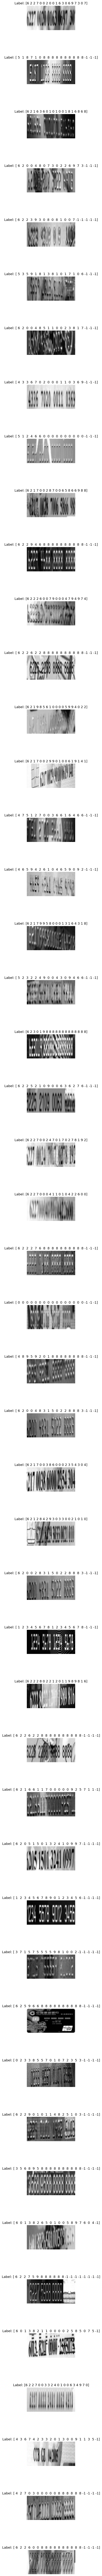

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline


# Function to display images in a grid
def show_images(images, labels, n_cols=4):
    n_images = len(images)
    n_rows = (n_images // n_cols) + (n_images % n_cols > 0)
    
    plt.figure(figsize=(3, n_rows * 3))
    
    for idx in range(n_images):
        plt.subplot(n_rows, n_cols, idx + 1)
        plt.imshow(images[idx].permute(1, 2, 0), cmap='gray')  # Convert to (H, W, C) format
        plt.title(f'Label: {labels[idx]}')
        plt.axis('off')  # Hide axes
        
    plt.tight_layout()
    plt.show()

# Iterate through the train_loader to collect all images
all_images = []
all_labels = []

for inputs, targets in train_loader:
    all_images.extend(inputs)  # Extend the list with the batch of images
    all_labels.extend(targets.numpy())  # Extend the list with the batch of labels

# Show all images in the training set
show_images(all_images, all_labels, n_cols=1)

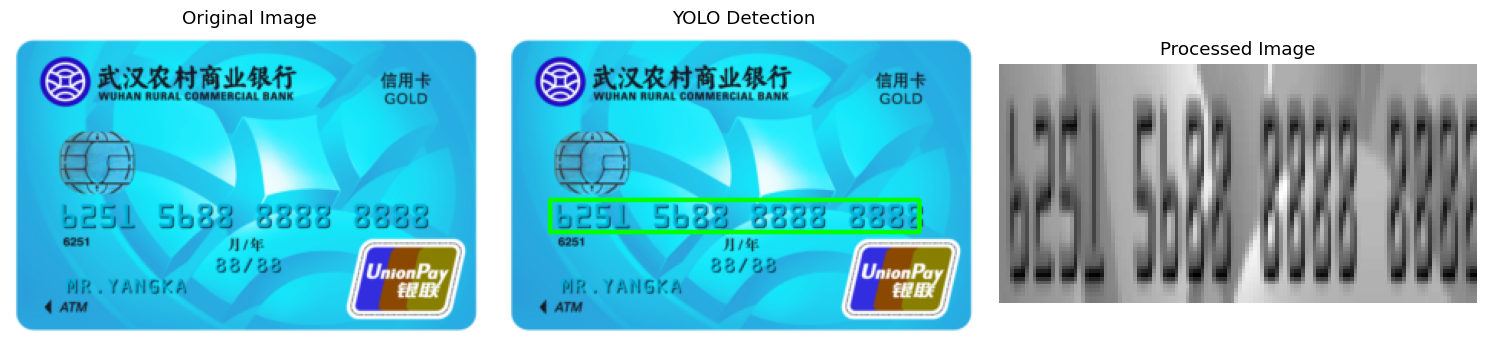

Label: 625156888888888


In [41]:
visualize_preprocessing(test_dataset,1)

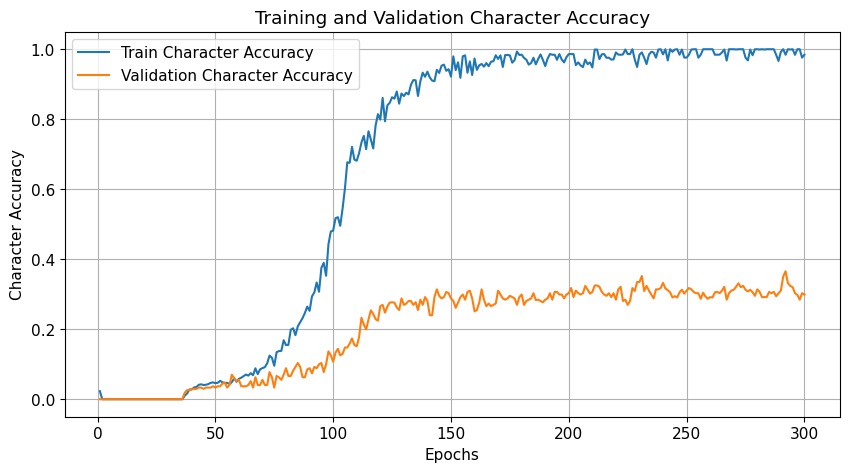

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_accuracy(history):
    epochs = range(1, len(history['train_char_acc']) + 1)

    plt.figure(figsize=(10, 5))
    
    # Plot character accuracy
    plt.plot(epochs, history['train_char_acc'], label='Train Character Accuracy')
    plt.plot(epochs, history['val_char_acc'], label='Validation Character Accuracy')
    
    plt.xlabel('Epochs')
    plt.ylabel('Character Accuracy')
    plt.title('Training and Validation Character Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot
plot_accuracy(history)